# Expat advice: Relocating from Ireland to USA
## IBM Applied Data Science Capstone / Final project in the IBM Data Science Professional Certificate series
#### Author:  [Lenka Čížková](https://www.linkedin.com/in/lenka-cizkova)
[Click here to read the Introduction](https://github.com/lenka-cizkova/Coursera_Capstone/blob/master/IBM_Data_Science_Capstone_Final_Report_v1.pdf)

___
Copyright &copy; 2019-2020 [Lenka Čížková](https://www.linkedin.com/in/lenka-cizkova).  
Several functions to retrieve Foursquare data are based on the lesson _Segmenting and Clustering Neighborhoods in New York City_ , part of a course on _Coursera_ called [_Applied Data Science Capstone_](http://cocl.us/DP0701EN_Coursera_Week3_LAB2): Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu).  
This notebook and its source code are released under the terms of the [MIT License](https://choosealicense.com/licenses/mit/).

## Contents:

1. National parks for Kayleigh
   - natural parks, statistics
   - visualisation (map)
   - clustering the parks? (area, number of visitors, visitor density)
1. Top universities for Sean
   - international ranking, statistics, comparison US vs World vs Ireland
   - US universities in the Top 500
   - visualisation (map)
   - Foursquare to find venues close to the universities, identification of anomalies
   - clustering the universities? (venues, scores)
1. Parks vs universities   
   - distances between the universities and the national parks; the first selection round
1. Foursquare to find the venues relevant for the rest of the family; the second selection round:
   - Climbing for Brian (rock climbing around & not many existing climbing gyms)
   - Zoo exhibits & skating for Orla
   - No/not many Irish restaurants, enough museums for Shauna
1. Identifying the most suitable places for the family

---

# Technical background: Installing & importing the Python libraries

In [1]:
# install BeautifulSoup4: (for webscraping)
#!conda install -c conda-forge beautifulsoup4 --yes
!pip install beautifulsoup4
print('\n===>>> beautifulsoup4 installed!\n')

# install lxml: 
#!conda install -c conda-forge lxml --yes
!pip install lxml
print('\n===>>> lxml installed!\n')

# install geocoder: (to retrieve geographical coordinates)
#!conda install -c conda-forge geocoder --yes
!pip install geocoder
print('\n===>>> geocoder installed!\n')

# install folium: (to generate maps)
#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
!pip install folium --upgrade
print('\n===>>> folium installed!\n')

# install selenium: (e.g., for webscraping dynamically generated content)
#!conda install -c conda-forge selenium --yes
!pip install selenium
print('\n===>>> selenium installed!\n')

# install geopy: (e.g., calculating distance based on geographical coordinates)
!pip install geopy
print('\n===>>> geopy installed!\n')

print('\n===>>> ready to go!')


===>>> beautifulsoup4 installed!


===>>> lxml installed!


===>>> geocoder installed!

Requirement already up-to-date: folium in d:\lenka-hp\soft\anaconda3\lib\site-packages (0.10.1)

===>>> folium installed!


===>>> selenium installed!


===>>> geopy installed!


===>>> ready to go!


In [2]:
# import the libraries:
import numpy as np
import pandas as pd
import math
import requests
import geocoder # to retrieve latitude and longitude
import csv
import json
import folium # map rendering library
import matplotlib.colors as colors
import branca
import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle # used here to define colors
from geopy.distance import geodesic # to calculate distance for given (pairs of) geographic coordinates
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn import metrics
from sklearn.cluster import KMeans
#from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
#from google.colab import files 

#!conda install -c conda-forge geopy --yes 
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Libraries imported.


The variable `save` indicates whether the results (various dataframes generated by the code) should be saved (as csv) after important steps. I am using it in case of unstable internet connection, to be able to go on from any chosen cell without the necessity to run all the cells, just by reading the dataframes from the csv files generated previously (as indicated by the variable `load`). This can be useful especially when taking into account limitations on the number of queries from Foursquare.

Under Google Colab, this can be combined with `files.download` and `files.upload`

In [486]:
save = True # generated dataframes should be saved
load = False # previously saved files should be read and saved into respective dataframes
colab = False # working under Google Colab (some functionality differs, e.g., working with chromium, files are deleted regularly so they need to be downloaded to/uploaded from a local PC)

---

# Part A: National Parks in U.S.

We will retrieve the list of National Parks from Wikipedia, https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States, using `pandas.read_html`. 
(Click [here](https://beenje.github.io/blog/posts/parsing-html-tables-in-python-with-pandas/) for information and examples.)

The table containing information on the National Parks is the 2nd table on the website (1st one being Contents). So, we can use 
<code>
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States')
df[1]
</code>
or use parameter `match` (str or compiled regular expression, optional) as in the cell below, to only retrieve (the set of) tables containing text matching this regex or string - this is very useful if there are many tables on the website.

In [4]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_parks_of_the_United_States', match='Acadia')[0] # encoding = utf-8-sig ???
df

Name  Image  \
0                 Acadia    NaN   
1         American Samoa    NaN   
2                 Arches    NaN   
3               Badlands    NaN   
4               Big Bend    NaN   
..                   ...    ...   
57             Wind Cave    NaN   
58  Wrangell–St. Elias *    NaN   
59           Yellowstone    NaN   
60            Yosemite *    NaN   
61                  Zion    NaN   

                                             Location  \
0            Maine44°21′N 68°13′W﻿ / ﻿44.35°N 68.21°W   
1   American Samoa14°15′S 170°41′W﻿ / ﻿14.25°S 170...   
2           Utah38°41′N 109°34′W﻿ / ﻿38.68°N 109.57°W   
3   South Dakota43°45′N 102°30′W﻿ / ﻿43.75°N 102.50°W   
4          Texas29°15′N 103°15′W﻿ / ﻿29.25°N 103.25°W   
..                                                ...   
57  South Dakota43°34′N 103°29′W﻿ / ﻿43.57°N 103.48°W   
58        Alaska61°00′N 142°00′W﻿ / ﻿61.00°N 142.00°W   
59  Wyoming, Montana, Idaho44°36′N 110°30′W﻿ / ﻿44...   
60    California37°50′N 119°30′W﻿ / ﻿37.83°N 119.50°W   
61          Utah37°18′N 113°03′W﻿ / ﻿37.30°N 113.05°W   

   Date established as park[5][10]                    Area (2019)[11]  \
0                February 26, 1919        49,076.63 acres (198.6 km2)   
1                 October 31, 1988          8,256.67 acres (33.4 km2)   
2                November 12, 1971        76,678.98 acres (310.3 km2)   
3                November 10, 1978       242,755.94 acres (982.4 km2)   
4                    June 12, 1944     801,163.21 acres (3,242.2 km2)   
..                             ...                                ...   
57                 January 9, 1903        33,970.84 acres (137.5 km2)   
58                December 2, 1980  8,323,146.48 acres (33,682.6 km2)   
59                   March 1, 1872   2,219,790.71 acres (8,983.2 km2)   
60                 October 1, 1890     761,747.50 acres (3,082.7 km2)   
61               November 19, 1919       147,242.66 acres (595.9 km2)   

    Recreation visitors (2018)[8]  \
0                         3537575   
1                           28626   
2                         1663557   
3                         1008942   
4                          440091   
..                            ...   
57                         656397   
58                          79450   
59                        4115000   
60                        4009436   
61                        4320033   

                                          Description  
0   Covering most of Mount Desert Island and other...  
1   The southernmost national park is on three Sam...  
2   This site features more than 2,000 natural san...  
3   The Badlands are a collection of buttes, pinna...  
4   Named for the prominent bend in the Rio Grande...  
..                                                ...  
57  Wind Cave is distinctive for its calcite fin f...  
58  An over 8 million acres (32,375 km2) plot of m...  
59  Situated on the Yellowstone Caldera, the park ...  
60  Yosemite features sheer granite cliffs, except...  
61  Located at the junction of the Colorado Platea...  

[62 rows x 7 columns]

## Clean the data
We only need the columns **Name**, **Location**, **Area** and **Recreation visitors**, so let's drop the other columns. We will also clean the column names.

In [5]:
parks = df[['Name',
            'Location',
            'Area (2019)[11]',
            'Recreation visitors (2018)[8]']].rename(
    columns={'Area (2019)[11]':'Area', 
             'Recreation visitors (2018)[8]':'Visitors per year'})           
parks.head(3)

Name                                           Location  \
0          Acadia           Maine44°21′N 68°13′W﻿ / ﻿44.35°N 68.21°W   
1  American Samoa  American Samoa14°15′S 170°41′W﻿ / ﻿14.25°S 170...   
2          Arches          Utah38°41′N 109°34′W﻿ / ﻿38.68°N 109.57°W   

                          Area  Visitors per year  
0  49,076.63 acres (198.6 km2)            3537575  
1    8,256.67 acres (33.4 km2)              28626  
2  76,678.98 acres (310.3 km2)            1663557

In [6]:
location = parks['Location'].str.split('/',n=1,expand=True)
location.head(3)

0                   1
0            Maine44°21′N 68°13′W﻿     ﻿44.35°N 68.21°W
1  American Samoa14°15′S 170°41′W﻿    ﻿14.25°S 170.68°W
2            Utah38°41′N 109°34′W﻿    ﻿38.68°N 109.57°W

The geographical coordinates of the parks can be retrieved from column 1 of dataframe `location`. 

Notice that due to UNICODE coding, the strings contain '\ufeff' (which is invisible in the dataframe but generates an error message when trying to convert to numbers) that we need to get rid off. (Example of `replace` [here](https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column/28252957#28252957).)

In [7]:
aux = location[1].str.split(' ',n=2,expand=True).replace(regex=True,to_replace=r'\ufeff',value=r'')
aux.head(3)

0        1         2
0    44.35°N   68.21°W
1    14.25°S  170.68°W
2    38.68°N  109.57°W

Let's retrieve the values of latitude and longitude for each park. Notice that S in the latitude or W in the longitude means the result needs to be a negative number.

In [8]:
# for the latitudes on the Southern Hemisphere, multiply by -1:
l = aux[1].str.split('°',n=2,expand=True).replace('N',1).replace('S',-1).astype(float)
lat = l[0] * l[1]

# for the longitudes on the Western Hemisphere, multiply by -1:
l = aux[2].str.split('°',n=2,expand=True).replace('E',1).replace('W',-1).astype(float)
lng = l[0] * l[1]

Now, let's get the respective states from column 0 of dataframe `location`: split on the character '°' and remove the last two characters (which belong to the latitude).

In [9]:
state = location[0].str.split('°',n=1,expand=True)[0].str[:-2]
state.head(3)

0             Maine
1    American Samoa
2              Utah
Name: 0, dtype: object

Finally, let's get the area in km2, i.e., the number in the parentheses.

In [10]:
aux = pd.DataFrame(parks['Area'].str.split('(',n=1,expand=True)[1])    # now the items are like '198.6 km2)'
area = aux[1].str.split('km2',n=1,expand=True).replace(regex=True,to_replace=r',',value=r'')[0].astype(float)
area

0       198.6
1        33.4
2       310.3
3       982.4
4      3242.2
       ...   
57      137.5
58    33682.6
59     8983.2
60     3082.7
61      595.9
Name: 0, Length: 62, dtype: float64

In [11]:
parks['Latitude'] = lat
parks['Longitude'] = lng
parks['State'] = state
parks['Area'] = area
parks.rename(columns={'Area':'Area in km2'}, inplace=True)
if 'Location' in parks.columns:
    parks.drop(columns = ['Location'],inplace=True)
parks.head()

Name  Area in km2  Visitors per year  Latitude  Longitude  \
0          Acadia        198.6            3537575     44.35     -68.21   
1  American Samoa         33.4              28626    -14.25    -170.68   
2          Arches        310.3            1663557     38.68    -109.57   
3        Badlands        982.4            1008942     43.75    -102.50   
4        Big Bend       3242.2             440091     29.25    -103.25   

            State  
0           Maine  
1  American Samoa  
2            Utah  
3    South Dakota  
4           Texas

## Let's check how crowded are the parks. 
We will define variable `crowded` as the visitor density, i.e., the number of visitors per year per km2.

In [12]:
parks['Crowded'] = (parks['Visitors per year'] / parks['Area in km2']).astype(float).round(2)
parks.head()

Name  Area in km2  Visitors per year  Latitude  Longitude  \
0          Acadia        198.6            3537575     44.35     -68.21   
1  American Samoa         33.4              28626    -14.25    -170.68   
2          Arches        310.3            1663557     38.68    -109.57   
3        Badlands        982.4            1008942     43.75    -102.50   
4        Big Bend       3242.2             440091     29.25    -103.25   

            State   Crowded  
0           Maine  17812.56  
1  American Samoa    857.07  
2            Utah   5361.12  
3    South Dakota   1027.02  
4           Texas    135.74

### Save the parks dataframe.

In [13]:
if save:
    parks.to_csv('Top_US_Universities_2020_National_Parks.csv', index=False)

In [14]:
# getting back the data generated so far, after a kernel restart etc, to spare Foursquare queries:
# upload 'Top_US_Universities_2020_National_Parks.csv' !!!

if load:
    #uploaded = files.upload()
    parks = pd.read_csv('Top_US_Universities_2020_National_Parks.csv')
    parks

### Let's look at the descriptive statistics:

In [15]:
parks[['Area in km2','Visitors per year','Crowded']].describe()

Area in km2  Visitors per year       Crowded
count     62.000000       6.200000e+01  6.200000e+01
mean    3420.788710       1.394863e+06  4.433794e+04
std     6646.028274       1.897715e+06  3.197370e+05
min        0.800000       9.591000e+03  3.100000e-01
25%      229.400000       3.121205e+05  3.654875e+02
50%      889.500000       6.506595e+05  9.950700e+02
75%     2989.525000       1.674884e+06  2.554323e+03
max    33682.600000       1.142120e+07  2.520225e+06

We can see that there are big differences between the parks concerning their area, number of visitors per year as well as visitor density.  
Let's check which parks are the least and the most crowded.

In [16]:
parks[parks['Crowded'] == parks['Crowded'].min()]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
19  Gates of the Arctic      30448.1               9591     67.78     -153.3   

     State  Crowded  
19  Alaska     0.31

In [17]:
parks[parks['Crowded'] == parks['Crowded'].max()]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
20  Gateway Arch          0.8            2016180     38.63     -90.19   

       State    Crowded  
20  Missouri  2520225.0

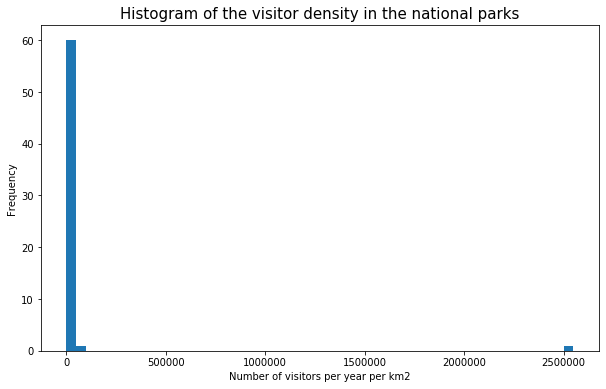

In [18]:
plt.figure(figsize=(10,6))
binwidth = 50000
aux = plt.hist(parks['Crowded'],bins=range(0,binwidth*(2+int(parks['Crowded'].max()/binwidth)),binwidth))
plt.title('Histogram of the visitor density in the national parks', {'fontsize': 15})
plt.xlabel('Number of visitors per year per km2')
plt.ylabel('Frequency')
plt.show()

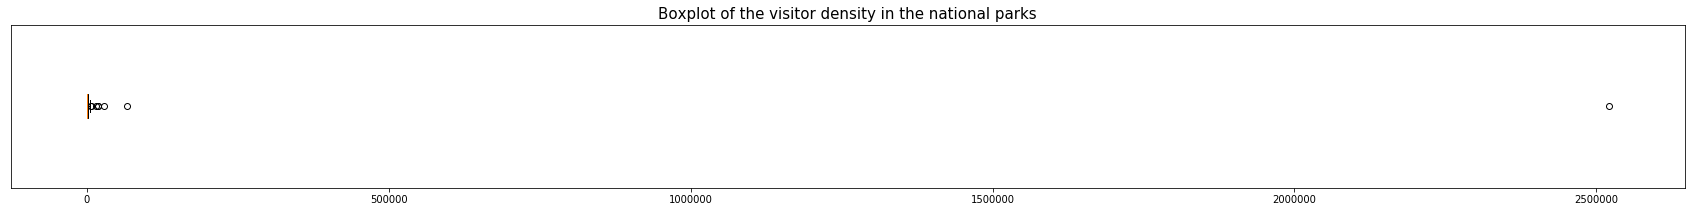

In [19]:
plt.figure(figsize=(30,3))
aux = plt.boxplot(parks['Crowded'],vert=False)
plt.title('Boxplot of the visitor density in the national parks', {'fontsize': 15})
plt.yticks([]) # remove the y-ticks
plt.show()

[Reference/Example 3D graphs](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html)  

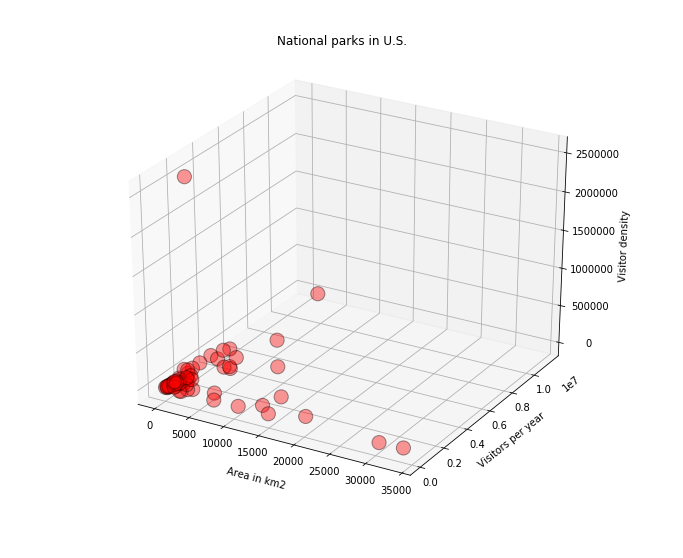

In [20]:
title = 'National parks in U.S.'
X = parks['Area in km2']
Y = parks['Visitors per year']
Z = parks['Crowded']

plt.figure(figsize=(12,10))

ax = plt.subplot(1,1,1,projection='3d')   
ax.scatter(X,Y,Z,s=200,c='r',alpha=0.4,linewidths=1,edgecolors='k')

#ax.w_xaxis.set_ticklabels([])
#ax.w_yaxis.set_ticklabels([])
#ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('\nArea in km2', linespacing=3)
ax.set_ylabel('\nVisitors per year')
ax.set_zlabel('\nVisitor density', linespacing=7)
ax.tick_params(axis='z', which='major', pad=15)
ax.set_title(title)
ax.dist = 12

plt.show()

As we can see, the Gateway Arch is an extreme outlier. Except of that, it is not a natural park such as Kayleigh searches for. 

![Gateway Arch](https://upload.wikimedia.org/wikipedia/commons/0/00/St_Louis_night_expblend_cropped.jpg)
Thus, we will drop it from the list of the national parks and re-do the descriptive statistics without the Gateway Arch.

In [21]:
parks = parks[parks['Name'] != 'Gateway Arch'].reset_index(drop=True) 
parks[['Area in km2','Visitors per year','Crowded']].describe()

Area in km2  Visitors per year       Crowded
count     61.000000       6.100000e+01     61.000000
mean    3476.854098       1.384678e+06   3749.629508
std     6686.383097       1.911755e+06   9686.138333
min       22.500000       9.591000e+03      0.310000
25%      261.800000       3.089620e+05    362.660000
50%      895.900000       6.449220e+05    971.890000
75%     3082.700000       1.663557e+06   2479.630000
max    33682.600000       1.142120e+07  66972.760000

In [22]:
parks[parks['Crowded'] == parks['Crowded'].max()]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
30  Hot Springs         22.5            1506887     34.51     -93.05   

       State   Crowded  
30  Arkansas  66972.76

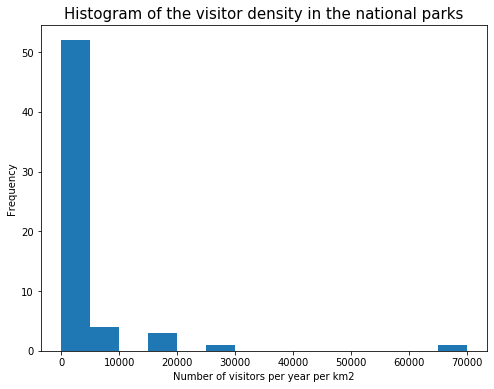

In [23]:
plt.figure(figsize=(8,6))
binwidth = 5000
aux = plt.hist(parks['Crowded'],bins=range(0,binwidth*(2+int(parks['Crowded'].max()/binwidth)),binwidth))
plt.title('Histogram of the visitor density in the national parks', {'fontsize': 15})
plt.xlabel('Number of visitors per year per km2')
plt.ylabel('Frequency')
plt.show()

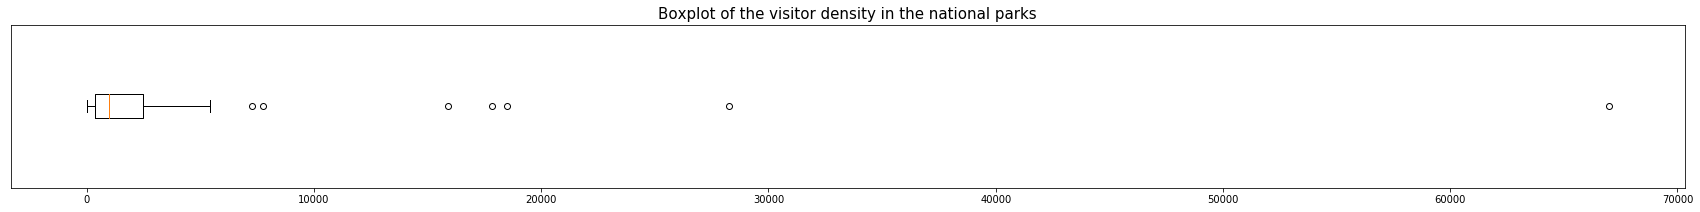

In [24]:
plt.figure(figsize=(30,3))
aux = plt.boxplot(parks['Crowded'],vert=False)
plt.title('Boxplot of the visitor density in the national parks', {'fontsize': 15})
plt.yticks([])
plt.show()

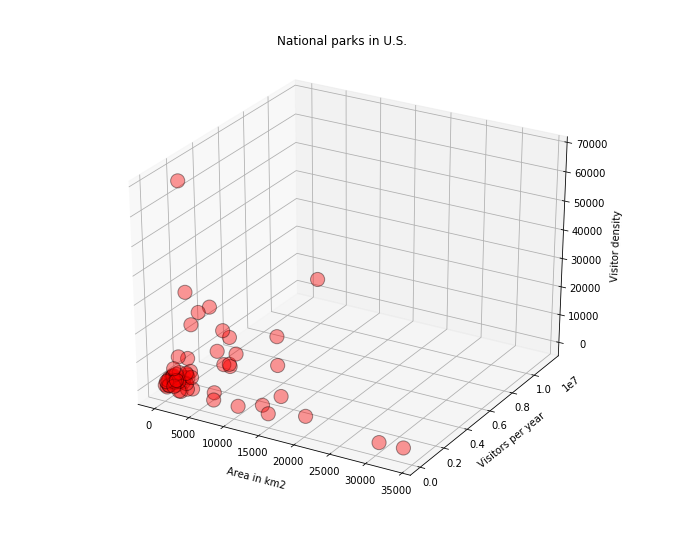

In [25]:
title = 'National parks in U.S.'
X = parks['Area in km2']
Y = parks['Visitors per year']
Z = parks['Crowded']

plt.figure(figsize=(12,10))

ax = plt.subplot(1,1,1,projection='3d')   
ax.scatter(X,Y,Z,s=200,c='r',alpha=0.4,linewidths=1,edgecolors='k')

#ax.w_xaxis.set_ticklabels([])
#ax.w_yaxis.set_ticklabels([])
#ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('\nArea in km2', linespacing=3)
ax.set_ylabel('\nVisitors per year')
ax.set_zlabel('\nVisitor density', linespacing=5)
ax.tick_params(axis='z', which='major', pad=10)
ax.set_title(title)
ax.dist = 12

plt.show()

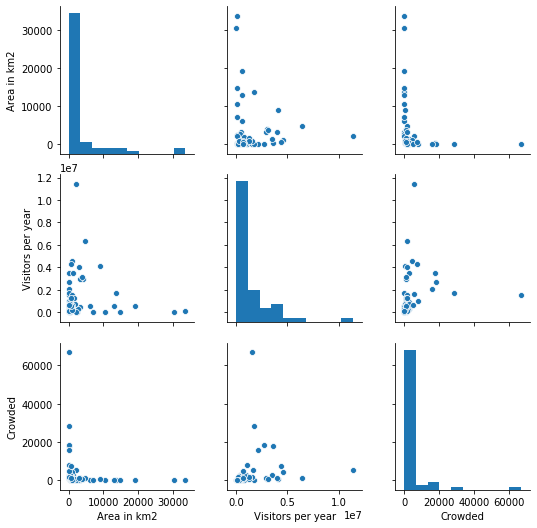

In [26]:
#ax = sns.pairplot(parks,vars=['Area in km2','Visitors per year','Crowded'],corner=True) # corner is only available in seaborn 0.10.0+
ax = sns.pairplot(parks,vars=['Area in km2','Visitors per year','Crowded'])

There are still quite big differences between the parks, so, we will check the clustering in a moment.

## Visualize the national parks!

The color and the size of the markers will show the visitor density of the park (using a logarithmic scale) and its area, respectively.

First, get the geographical coordinates of U.S.

In [27]:
# get the geographical coordinates of United States:
address = 'United States'
g = geocoder.arcgis(address)
lat_lng_coords = g.latlng
latitude  = g.latlng[0]
longitude = g.latlng[1]

# we will need these coordinates later again:
US_latitude  = latitude
US_longitude = longitude

print('The geographical coordinates of U.S. are {}, {}.'.format(latitude, longitude))

The geographical coordinates of U.S. are 39.39870315600007, -99.41461918999994.


In [434]:
# create a map of US using latitude and longitude values:
map_US = folium.Map(location=[US_latitude, US_longitude], zoom_start=3)

# define the color map to visualize a ratio: (originally, I went up to vmax = 6, but that was only necessary for Gateway Arch, which I have removed because it is not a natural park)
key = 'Crowded'
vmin = 0
vmax = 5
colormap = branca.colormap.LinearColormap(colors=['green','red'],
                             index=[vmin,vmax],
                             vmin=vmin, 
                             vmax=vmax)
colormap = colormap.to_step(index=[0, 1, 2, 3, 4, 5])
colormap.caption = 'Visitor density (log10(number of visitors per year per km2))'
#colormap = colormap.to_step(index=[1, 10, 100, 1000, 10000, 100000],method='log') # logarithmic scale seems not to be working well
#colormap.caption = 'Visitor density (number of visitors per year per km2)'
colormap.add_to(map_US)

# add markers to map
group0 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">national parks</span>')
for lat, lng, name, area, crowd in zip(parks['Latitude'], 
                                        parks['Longitude'], 
                                        parks['Name'], 
                                        parks['Area in km2'], 
                                        parks[key]):
    c = colormap(math.log10(crowd))
    a = 2*math.log10(area)+1
    label = '{}: \narea = {} km2,\n {} visitors per km2'.format(name, area, int(crowd))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=a,
        popup=label,
        key_on=parks[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,
        parse_html=False).add_to(group0)  
group0.add_to(map_US)
folium.map.LayerControl('topright', collapsed=False).add_to(map_US)

# add the colormap showing the visitor density of the parks:
map_US.add_child(colormap)    

map_US.save('map_parks.html')

map_US

In [29]:
parks

Name  Area in km2  Visitors per year  Latitude  Longitude  \
0                 Acadia        198.6            3537575     44.35     -68.21   
1         American Samoa         33.4              28626    -14.25    -170.68   
2                 Arches        310.3            1663557     38.68    -109.57   
3               Badlands        982.4            1008942     43.75    -102.50   
4               Big Bend       3242.2             440091     29.25    -103.25   
..                   ...          ...                ...       ...        ...   
56             Wind Cave        137.5             656397     43.57    -103.48   
57  Wrangell–St. Elias *      33682.6              79450     61.00    -142.00   
58           Yellowstone       8983.2            4115000     44.60    -110.50   
59            Yosemite *       3082.7            4009436     37.83    -119.50   
60                  Zion        595.9            4320033     37.30    -113.05   

                      State   Crowded  
0                     Maine  17812.56  
1            American Samoa    857.07  
2                      Utah   5361.12  
3              South Dakota   1027.02  
4                     Texas    135.74  
..                      ...       ...  
56             South Dakota   4773.80  
57                   Alaska      2.36  
58  Wyoming, Montana, Idaho    458.08  
59               California   1300.62  
60                     Utah   7249.59  

[61 rows x 7 columns]

## Clustering the National Parks

### K-Means: Finding the best value of k
We will try to use the elbow method to find the optimal value of k.

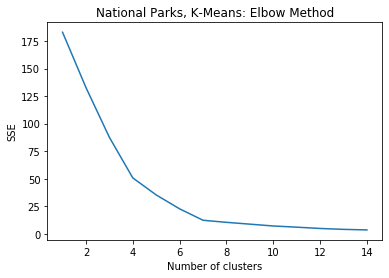

In [30]:
X = parks[['Area in km2','Visitors per year','Crowded']]
X = np.nan_to_num(X)
Xscaled = StandardScaler().fit_transform(X)

maxK = 15

kmeans = [KMeans(n_clusters=i, max_iter=1000) for i in range(1,maxK)]
sse = [km.fit(Xscaled).inertia_ for km in kmeans]

plt.figure()
plt.plot(range(1,maxK), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("National Parks, K-Means: Elbow Method")
plt.show()

In [31]:
print('nr.clusters | SSE')
print('--------------------------------')
for i in range(1,11):
    print('{:11d} | {:14.10f}'.format(i,sse[i-1]))

nr.clusters | SSE
--------------------------------
          1 | 183.0000000000
          2 | 132.7870859226
          3 |  87.5785834725
          4 |  50.7167063297
          5 |  35.2529856216
          6 |  22.6183359641
          7 |  12.2485574737
          8 |  10.3584447728
          9 |   8.7097587591
         10 |   7.0475462950


There seem to be two elbows: at k=4 and at k=7. Based on the plot above, it is hard to tell which of them is better. Therefore, let's check the silhouette score, which often gives a better idea concerning the optimal value of k than the elbow method.

[Silhouette score:](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
> - The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
> - The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

[Silhouette analysis:](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)
>The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

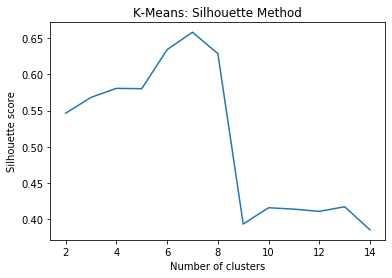

In [32]:
silhouette_score = [metrics.silhouette_score(Xscaled, km.labels_, metric='euclidean') for km in kmeans[1:]]

plt.figure()
plt.plot(range(2,maxK), silhouette_score)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("K-Means: Silhouette Method")
plt.show()

In [33]:
print('nr.clusters | Silhouette score')
print('------------------------------')
for i in range(2,11):
    print('{:11d} | {: 13.10f}'.format(i,silhouette_score[i-2]))

nr.clusters | Silhouette score
------------------------------
          2 |  0.5464700217
          3 |  0.5682509419
          4 |  0.5806820849
          5 |  0.5802138928
          6 |  0.6340383513
          7 |  0.6580292941
          8 |  0.6286291275
          9 |  0.3936814091
         10 |  0.4161243638


Based on the silhouette score, we can conclude that the optimal value for K-Means is k=7.

In [34]:
# set number of clusters (best value found above: k=7)
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Xscaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 6, 0, 0, 1, 1, 4, 3, 0,
       3, 3, 1, 1, 5, 1, 1, 1, 2, 6, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 3, 3])

Let's check another clustering method, the [AffinityPropagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation).  
Affinity Propagation suggests clustering into 8 clusters which is not much different from 7 clusters by K-Means:

Estimated number of clusters: 8
Silhouette Coefficient: 0.519


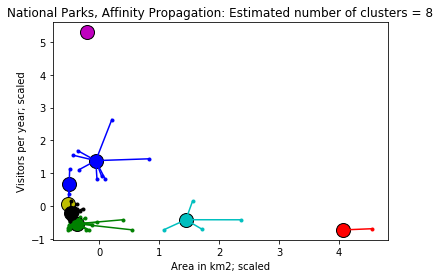

In [35]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Compute Affinity Propagation
af = AffinityPropagation().fit(Xscaled)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xscaled, labels, metric='sqeuclidean'))

# Plot result
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = Xscaled[cluster_centers_indices[k]]
    plt.plot(Xscaled[class_members, 0], Xscaled[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in Xscaled[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('National Parks, Affinity Propagation: Estimated number of clusters = %d' % n_clusters_)
plt.xlabel('Area in km2; scaled')
plt.ylabel('Visitors per year; scaled')
plt.show()

Let's create a new dataframe that includes the data on the national parks as well as the respective labels assigned by both the K-Means and the Affinity Propagation methods.

In [36]:
# add clustering labels as the last columns:
parks_labeled = parks
parks_labeled.insert(parks_labeled.shape[1], 'Cluster Labels K-Means', kmeans.labels_)
parks_labeled.insert(parks_labeled.shape[1], 'Cluster Labels Affinity Propagation', af.labels_)

In [37]:
parks_labeled

Name  Area in km2  Visitors per year  Latitude  Longitude  \
0                 Acadia        198.6            3537575     44.35     -68.21   
1         American Samoa         33.4              28626    -14.25    -170.68   
2                 Arches        310.3            1663557     38.68    -109.57   
3               Badlands        982.4            1008942     43.75    -102.50   
4               Big Bend       3242.2             440091     29.25    -103.25   
..                   ...          ...                ...       ...        ...   
56             Wind Cave        137.5             656397     43.57    -103.48   
57  Wrangell–St. Elias *      33682.6              79450     61.00    -142.00   
58           Yellowstone       8983.2            4115000     44.60    -110.50   
59            Yosemite *       3082.7            4009436     37.83    -119.50   
60                  Zion        595.9            4320033     37.30    -113.05   

                      State   Crowded  Cluster Labels K-Means  \
0                     Maine  17812.56                       6   
1            American Samoa    857.07                       1   
2                      Utah   5361.12                       1   
3              South Dakota   1027.02                       1   
4                     Texas    135.74                       1   
..                      ...       ...                     ...   
56             South Dakota   4773.80                       1   
57                   Alaska      2.36                       4   
58  Wyoming, Montana, Idaho    458.08                       3   
59               California   1300.62                       3   
60                     Utah   7249.59                       3   

    Cluster Labels Affinity Propagation  
0                                     0  
1                                     1  
2                                     6  
3                                     6  
4                                     1  
..                                  ...  
56                                    6  
57                                    2  
58                                    7  
59                                    7  
60                                    7  

[61 rows x 9 columns]

### Save the labeled parks

In [38]:
# now save the corrected & clustered data to a csv file:
if save:
    parks_labeled.to_csv('Top_US_Universities_2020_Parks_Labeled.csv', index=False)

In [39]:
#if save:
#    files.download('Top_US_Universities_2020_Parks_Labeled.csv')

In [40]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_Parks_Labeled.csv !!!

if load:
    #uploaded = files.upload()
    parks_labeled = pd.read_csv('Top_US_Universities_2020_Parks_Labeled.csv')
    parks_labeled

### Comparing the clusterings of the parks
[Reference/Example 3D graphs](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html)  
In the following figure, we can see that the clustering by K-Means is nearly the same as the clustering by Affinity Propagation. The only difference is that one of the K-Means clusters becomes two clusters using the Affinity Propagation.

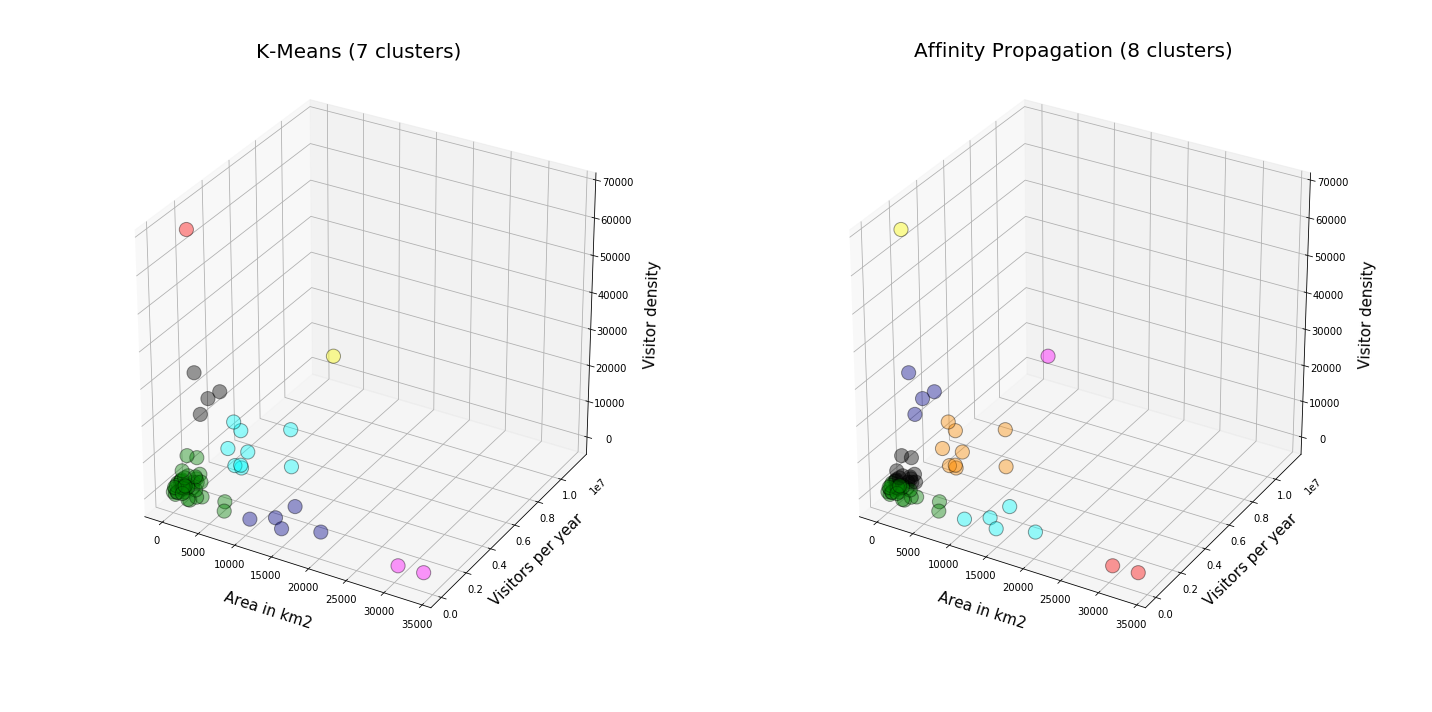

In [451]:
#colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
#col = 'bgrcmykbgrcmykbgrcmykbgrcmyk' # 7 colours (even cycling) are not enough to show well the 8 cluster (affinity propagation) because 2 clusters appears to become one
col = ['darkblue','green','red','cyan','magenta','yellow','black','darkorange','black','grey']

titles = ['K-Means (7 clusters)', 'Affinity Propagation (8 clusters)']
X = parks_labeled['Area in km2']
Y = parks_labeled['Visitors per year']
Z = parks_labeled['Crowded']
labels_ = [parks_labeled['Cluster Labels K-Means'],parks_labeled['Cluster Labels Affinity Propagation']]
colors = [[col[i] for i in labels_[0]],[col[j] for j in labels_[1]]]

plt.figure(figsize=(20,10))

for i,labels,c in zip(range(len(labels_)),labels_,colors):
    ax = plt.subplot(1,2,i+1,projection='3d')   
    ax.scatter(X,Y,Z,s=200,c=c,alpha=0.4,linewidths=1,edgecolors='k')

    #ax.w_xaxis.set_ticklabels([])
    #ax.w_yaxis.set_ticklabels([])
    #ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('\nArea in km2', linespacing=3, fontsize=15)
    ax.set_ylabel('\nVisitors per year', fontsize=15)
    ax.set_zlabel('\nVisitor density', linespacing=5, fontsize=15)
    ax.tick_params(axis='z', which='major', pad=10)
    
    ax.set_title(titles[i], fontsize=20)
    ax.dist = 12

plt.tight_layout()
plt.show()

## Visualizing the clusters of the national parks

In this visualization, I am using the folium's markers with pop-up labels, with icons made of 'circle' stacked over 'map-marker'. These icons have a limited colour scheme:

['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

Creating a legend for a folium map: read here. I believe that having a legend can make it easier to interpret the clusters.

Unfortunately, the colours used for icons don't match perfectly with usual python colours so I had to be a bit creative to get them as close as possible to each other.


In [432]:
# create map
map_clusters = folium.Map(location=[US_latitude, US_longitude], zoom_start=3)

# set color scheme for the clusters
#colors = ['mediumblue', 'gold', 'ivory', 'magenta', 'lawngreen', 'aqua', 'red', 'black']
colors = ['blue', 'beige', 'orange', 'purple', 'lightgreen', 'darkblue', 'black', 'red', 'darkgreen']
colors_l = ['skyblue', 'navajowhite', 'orange', 'mediumorchid', 'lightgreen', 'steelblue', 'black', 'crimson', 'darkgreen']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(parks_labeled['Latitude'], parks_labeled['Longitude'], parks_labeled['Name'], parks_labeled['Cluster Labels K-Means']) :
    label = folium.Popup('{}:\nCluster {}'.format(poi, int(cluster)), parse_html=True)
    if (cluster == -1):    # originally non-clustered
        cluster = kclusters
    folium.Marker([lat,lon], popup=label, icon=folium.Icon(color=colors[int(cluster)], prefix='fa', icon='circle')).add_to(map_clusters)
    
legend_html = '''
     <div style = "position: fixed; top: 80px; left: 20px; width: 110px; height: 230px; border:2px solid grey; z-index:9999; font-size:14px; ">
     &nbsp; Legend: 
     <br>&nbsp; Cluster   0 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:skyblue"></i>
     <br>&nbsp; Cluster   1 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:navajowhite"></i>
     <br>&nbsp; Cluster   2 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:orange"></i>
     <br>&nbsp; Cluster   3 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:mediumorchid"></i>
     <br>&nbsp; Cluster   4 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:lightgreen"></i>
     <br>&nbsp; Cluster   5 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:steelblue"></i>
     <br>&nbsp; Cluster   6 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:black"></i>
     <!-- <br>&nbsp; Cluster   7 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:crimson"></i> -->
     <!-- <br>&nbsp; Cluster   8 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:darkgreen"></i> -->
      </div>
     '''
map_clusters.get_root().html.add_child(folium.Element(legend_html))
       
map_clusters

## Examine the clusters

<div style = "font-size:20px; ">
     &nbsp; Cluster   0 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:skyblue"></i> consists of 5 parks (4 of which in Alaska) with a large area (10000-20000 km2) and a low visitor density (< 125).
</div>

In [43]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 0]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
15  Death Valley      13793.3            1678660     36.24    -116.82   
16        Denali      19185.8             594660     63.33    -150.50   
21   Glacier Bay      13044.6             597915     58.50    -137.00   
34        Katmai      14870.3              37818     58.50    -155.00   
38    Lake Clark      10602.0              14479     60.97    -153.42   

                 State  Crowded  Cluster Labels K-Means  \
15  California, Nevada   121.70                       0   
16              Alaska    30.99                       0   
21              Alaska    45.84                       0   
34              Alaska     2.54                       0   
38              Alaska     1.37                       0   

    Cluster Labels Affinity Propagation  
15                                    3  
16                                    3  
21                                    3  
34                                    3  
38                                    3

<div style = "font-size:20px; ">
     &nbsp; Cluster   1 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:navajowhite"></i> is the biggest one, consisting of about 2/3 of all the parks, with a relatively small area and a lower number of visitors than cluster 3.
</div>

In [44]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 1]

Name  Area in km2  Visitors per year  Latitude  \
1                 American Samoa         33.4              28626    -14.25   
2                         Arches        310.3            1663557     38.68   
3                       Badlands        982.4            1008942     43.75   
4                       Big Bend       3242.2             440091     29.25   
5                       Biscayne        700.0             469253     25.65   
6   Black Canyon of the Gunnison        124.6             308962     38.57   
8                    Canyonlands       1366.2             739449     38.20   
9                   Capitol Reef        979.0            1227627     38.20   
10            Carlsbad Caverns *        189.3             465912     32.17   
11               Channel Islands       1009.9             366250     34.01   
12                      Congaree        107.1             145929     33.78   
13                   Crater Lake        741.5             720659     42.94   
17                  Dry Tortugas        261.8              56810     24.63   
18                    Everglades       6106.5             597124     25.32   
24                   Great Basin        312.3             153094     38.98   
25              Great Sand Dunes        434.4             442905     37.73   
27           Guadalupe Mountains        349.5             172347     31.92   
28                     Haleakalā        134.6            1044084     20.72   
29             Hawaiʻi Volcanoes       1317.7            1116891     19.38   
32                   Isle Royale       2314.0              25798     48.10   
35                  Kenai Fjords       2710.0             321596     59.92   
36                  Kings Canyon       1869.2             699023     36.80   
37                  Kobuk Valley       7084.9              14937     67.55   
39               Lassen Volcanic        431.4             499435     40.49   
40                  Mammoth Cave        218.6             533206     37.18   
41                  Mesa Verde *        212.4             563420     37.18   
42                 Mount Rainier        956.6            1518491     46.85   
43                North Cascades       2042.8              30085     48.70   
45              Petrified Forest        895.9             644922     35.07   
46                     Pinnacles        108.0             222152     36.48   
47                     Redwood *        562.5             482536     41.30   
49                       Saguaro        371.2             957405     32.25   
50                       Sequoia       1635.2            1229594     36.43   
51                    Shenandoah        806.2            1264880     38.53   
52            Theodore Roosevelt        285.1             749389     46.97   
53                Virgin Islands         60.9             112287     18.33   
54                     Voyageurs        883.1             239656     48.50   
55                   White Sands        592.2             603008     32.78   
56                     Wind Cave        137.5             656397     43.57   

    Longitude                State  Crowded  Cluster Labels K-Means  \
1     -170.68       American Samoa   857.07                       1   
2     -109.57                 Utah  5361.12                       1   
3     -102.50         South Dakota  1027.02                       1   
4     -103.25                Texas   135.74                       1   
5      -80.08              Florida   670.36                       1   
6     -107.72             Colorado  2479.63                       1   
8     -109.93                 Utah   541.25                       1   
9     -111.17                 Utah  1253.96                       1   
10    -104.44           New Mexico  2461.24                       1   
11    -119.42           California   362.66                       1   
12     -80.78       South Carolina  1362.55                       1   
13    -122.10               Oregon   971.89            

<div style = "font-size:20px; ">
     &nbsp; Cluster   2 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:orange"></i> consists of only 1 park (Hot Springs) with by far the highest visitor density (66973 visitors per year per km2).
</div>

In [45]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 2]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
30  Hot Springs         22.5            1506887     34.51     -93.05   

       State   Crowded  Cluster Labels K-Means  \
30  Arkansas  66972.76                       2   

    Cluster Labels Affinity Propagation  
30                                    5

<div style = "font-size:20px; ">
     &nbsp; Cluster   3 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:mediumorchid"></i> consists of 9 parks with a large number of visitors per year (3 to 6 million), less crowded than cluster 6 due to a larger area.
</div>

In [46]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 3]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
20         Glacier       4100.0            2965309     48.80    -114.00   
22  Grand Canyon *       4862.9            6380495     36.06    -112.14   
23     Grand Teton       1254.7            3491151     43.73    -110.80   
33     Joshua Tree       3217.9            2942382     33.79    -115.90   
44         Olympic       3733.8            3104455     47.97    -123.50   
48  Rocky Mountain       1075.7            4590493     40.40    -105.58   
58     Yellowstone       8983.2            4115000     44.60    -110.50   
59      Yosemite *       3082.7            4009436     37.83    -119.50   
60            Zion        595.9            4320033     37.30    -113.05   

                      State  Crowded  Cluster Labels K-Means  \
20                  Montana   723.25                       3   
22                  Arizona  1312.08                       3   
23                  Wyoming  2782.46                       3   
33               California   914.38                       3   
44               Washington   831.45                       3   
48                 Colorado  4267.45                       3   
58  Wyoming, Montana, Idaho   458.08                       3   
59               California  1300.62                       3   
60                     Utah  7249.59                       3   

    Cluster Labels Affinity Propagation  
20                                    7  
22                                    7  
23                                    7  
33                                    7  
44                                    7  
48                                    7  
58                                    7  
59                                    7  
60                                    7

<div style = "font-size:20px; ">
     &nbsp; Cluster   4 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:lightgreen"></i> consists of only 2 parks in Alaska with a much larger area than the other parks. Both of them have a relatively low number of visitors per year and thus, a low visitor density.
</div>

In [47]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 4]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
19   Gates of the Arctic      30448.1               9591     67.78     -153.3   
57  Wrangell–St. Elias *      33682.6              79450     61.00     -142.0   

     State  Crowded  Cluster Labels K-Means  \
19  Alaska     0.31                       4   
57  Alaska     2.36                       4   

    Cluster Labels Affinity Propagation  
19                                    2  
57                                    2

<div style = "font-size:20px; ">
     &nbsp; Cluster   5 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:steelblue"></i> consists of only 1 park (Great Smoky Mountains) with by far the highest number of visitors per year.
</div>

In [48]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 5]

Name  Area in km2  Visitors per year  Latitude  \
26  Great Smoky Mountains       2114.2           11421200     35.68   

    Longitude                      State  Crowded  Cluster Labels K-Means  \
26     -83.53  North Carolina, Tennessee  5402.14                       5   

    Cluster Labels Affinity Propagation  
26                                    4

<div style = "font-size:20px; ">
     &nbsp; Cluster   6 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:black"></i> consists of 4 parks with a high visitor density (> 15000 visitors per year per km2), having a small area combined with several million visitors per year. 
</div>

In [49]:
parks_labeled[parks_labeled['Cluster Labels K-Means'] == 6]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
0            Acadia        198.6            3537575   44.3500   -68.2100   
7      Bryce Canyon        145.0            2679478   37.5700  -112.1800   
14  Cuyahoga Valley        131.8            2096053   41.2400   -81.5500   
31    Indiana Dunes         62.1            1756079   41.6533   -87.0524   

      State   Crowded  Cluster Labels K-Means  \
0     Maine  17812.56                       6   
7      Utah  18479.16                       6   
14     Ohio  15903.29                       6   
31  Indiana  28278.24                       6   

    Cluster Labels Affinity Propagation  
0                                     0  
7                                     0  
14                                    0  
31                                    0

---

# Part B: Top U.S. Universities
The data on the top universities can be scraped from the website of [THE World University Rankings 2020](https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking). The content of the website is dynamically generated. The viewer can set, among others, the region they are interested in, and the number of universities to be shown per page. The table consists of two parts: Ranking and Scores, which need to be scraped separately. 

I have dealt with the dynamically generated content using the Python's selenium library, combined with the Beautiful Soup 4. According to my experience, [Google Colaboratory](https://colab.research.google.com/) is a suitable place to work with the Jupyter Notebooks including selenium.

## Technical background: Install chromium, its driver, and selenium
Steps as described by [Darek Tidwell](https://darektidwell.com/using-selenium-with-google-colaboratory/) 
(originally, I've copied this code from [stackoverflow](https://stackoverflow.com/a/56851661) but Darek's is older so I point to him).

[Another possibility by @lewiskori;](https://dev.to/lewiskori/beginner-s-guide-to-web-scraping-with-python-s-selenium-3fl9) I've used his example to learn how selenium works.

[Google Colab — The Beginner’s Guide](https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa)

[Reference on uploading/downloading local files to/from Google Colab](https://colab.research.google.com/notebooks/io.ipynb)

In [50]:
# install chromium, its driver, and selenium
if colab:
    !apt-get update
    !apt install chromium-chromedriver
    !cp /usr/lib/chromium-browser/chromedriver /usr/bin
else:
    !pip install chromedriver
    !pip install selenium
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

print('===>>> chromium & selenium installed!')

===>>> chromium & selenium installed!


## So, let's explore THE World University Rankings 2020!
In the following code, `/length/25` or `/length/100` would get the data on 25 or 100 universities, respectively, per page. We would need to get every page separately (using `/page/0`, `/page/1` etc). On the other hand, `/length/-1` makes it possible to get the data on all the universities in one go.

In [79]:
if colab:
    driver = webdriver.Chrome('chromedriver',options=options)
else:
    path = "d:/lenka-hp/soft/"
    driver = webdriver.Chrome(path+'chromedriver.exe',options=options)
urlstats = 'https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking#!/page/0/length/-1/sort_by/rank/sort_order/asc/cols/stats'
stats = driver.get(urlstats)
# print(driver.page_source)  # results: show the fetched html code

The result is _very_ long, here we show just its beginning and we are by far not yet at the information we need... :

```
<html xmlns="http://www.w3.org/1999/xhtml" lang="en" xml:lang="en" dir="ltr" prefix="og: http://ogp.me/ns#" class="js"><head style="">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <meta http-equiv="Content-Type" content="text/html; charset=utf-8" lang="en">
<script src="https://js-agent.newrelic.com/nr-1153.min.js"></script><script src="https://www.googletagservices.com/activeview/js/current/osd.js?cb=%2Fr20100101"></script><script src="https://securepubads.g.doubleclick.net/gpt/pubads_impl_rendering_2019121002.js"></script><script src="//bat.bing.com/bat.js" async=""></script><script async="" src="//static.ads-twitter.com/uwt.js"></script><script src="https://connect.facebook.net/signals/config/2637390693045590?v=2.9.15&amp;r=stable" async=""></script><script async="" src="//connect.facebook.net/en_US/fbevents.js"></script><script async="" src="//www.googleadservices.com/pagead/conversion_async.js"></script><script async="" src="//www.google-analytics.com/analytics.js"></script><script type="text/javascript" id="www-widgetapi-script" src="https://s.ytimg.com/yts/jsbin/www-widgetapi-vfldHtazm/www-widgetapi.js" async=""></script><script async="" type="text/javascript" src="https://www.googletagservices.com/tag/js/gpt.js"></script><script src="//www.youtube.com/iframe_api"></script><script>(window.NREUM||(NREUM={})).loader_config={xpid:"VgUAWVRUChABVVBWAgIOVg==",licenseKey:"da4493c478",applicationID:"11145390"};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(20),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(s.console=!0,o.indexOf("dev")!==-1&&(s.dev=!0),o.indexOf("nr_dev")!==-1&&(s.nrDev=!0))}catch(c){}s.nrDev&&i.on("internal-error",function(t){r(t.stack)}),s.dev&&i.on("fn-err",function(t,n,e){r(e.stack)}),s.dev&&(r("NR AGENT IN DEVELOPMENT MODE"),r("flags: "+a(s,function(t,n){return t}).join(", ")))},{}],2:[function(t,n,e){function r(t,n,e,r,s){try{p?p-=1:o(s||new UncaughtException(t,n,e),!0)}catch(f){try{i("ierr",[f,c.now(),!0])}catch(d){}}return"function"==typeof u&&u.apply(this,a(arguments))}function UncaughtException(t,n,e){this.message=t||"Uncaught error with no additional information",this.sourceURL=n,this.line=e}function o(t,n){var e=n?null:c.now();i("err",[t,e])}var i=t("handle"),a=t(21),s=t("ee"),c=t("loader"),f=t("gos"),u=window.onerror,d=!1,l="nr@seenError",p=0;c.features.err=!0,t(1),window.onerror=r;try{throw new Error}catch(h){"stack"in h&&(t(9),t(8),"addEventListener"in window&&t(5),c.xhrWrappable&&t(10),d=!0)}s.on("fn-start",function(t,n,e){d&&(p+=1)}),s.on("fn-err",function(t,n,e){d&&!e[l]&&(f(e,l,function(){return!0}),this.thrown=!0,o(e))}),s.on("fn-end",function(){d&&!this.thrown&&p>0&&(p-=1)}),s.on("internal-error",function(t){i("ierr",[t,c.now(),!0])})},{}],3:[function(t,n,e){t("loader").features.ins=!0},{}],4:[function(t,n,e){function r(t){}if(window.performance&&window.performance.timing&&window.performance.getEntriesByType){var o=t("ee"),i=t("handle"),a=t(9),s=t(8),c="learResourceTimings",f="addEventListener",u="resourcetimingbufferfull",d="bstResource",l="resource",p="-start",h="-end",m="fn"+p,w="fn"+h,v="bstTimer",g="pushState",y=t("loader");y.features.stn=!0,t(7),"addEventListener"in window&&t(5);var x=NREUM.o.EV;o.on(m,function(t,n){var e=t[0];e instanceof x&&(this.bstStart=y.now())}),o.on(w,function(t,n){var e=t[0];e instanceof x&&i("bst",[e,n,this.bstStart,y.now()])}),a.on(m,function(t,n,e){this.bstStart=y.now(),this.bstType=e}),a.on(w,function(t,n){i(v,[n,this.bstStart,y.now(),this.bstType])}),s.on(m,function(){this.bstStart=y.now()}),s.on(w,function(t,n){i(v,[n,this.bstStart,y.now(),"requestAnimationFrame"])}),o.on(g+p,function(t){this.time=y.now(),this.startPath=location.pathname+location.hash}),o.on(g+h,function(t){i("bstHist",[location.pathname+location.hash,this.startPath,this.time])}),f in window.performance&&(window.performance["c"+c]?window.performance[f](u,function(t){i(d,[window.performance.getEntriesByType(l)]),window.performance["c"+c]()},!1):window.performance[f]("webkit"+u,function(t){i(d,[window.performance.getEntriesByType(l)]),window.performance["webkitC"+c]()},!1)),document[f]("scroll",r,{passive:!0}),document[f]("keypress",r,!1),document[f]("click",r,!1)}},{}],5:[function(t,n,e){function r(t){for(var n=t;n&&!n.hasOwnProperty(u);)n=Object.getPrototypeOf(n);n&&o(n)}function o(t){s.inPlace(t,[u,d],"-",i)}function i(t,n){return t[1]}var a=t("ee").get("events"),s=t("wrap-function")(a,!0),c=t("gos"),f=XMLHttpRequest,u="addEventListener",d="removeEventListener";n.exports=a,"getPrototypeOf"in Object?(r(document),r(window),r(f.prototype)):f.prototype.hasOwnProperty(u)&&(o(window),o(f.prototype)),a.on(u+"-start",function(t,n){var e=t[1],r=c(e,"nr@wrapped",function(){function t(){if("function"==typeof e.handleEvent)return e.handleEvent.apply(e,arguments)}var n={object:t,"function":e}[typeof e];return n?s(n,"fn-",null,n.name||"anonymous"):e});this.wrapped=t[1]=r}),a.on(d+"-start",function(t){t[1]=this.wrapped||t[1]})},{}],6:[function(t,n,e){function r(t,n,e){var r=t[n];"function"==typeof r&&(t[n]=function(){var t=i(arguments),n={};o.emit(e+"before-start",[t],n);var a;n[m]&&n[m].dt&&(a=n[m].dt);var s=r.apply(this,t);return o.emit(e+"start",[t,a],s),s.then(function(t){return o.emit(e+"end",[null,t],s),t},function(t){throw o.emit(e+"end",[t],s),t})})}var o=t("ee").get("fetch"),i=t(21),a=t(20);n.exports=o;var s=window,c="fetch-",f=c+"body-",u=["arrayBuffer","blob","json","text","formData"],d=s.Request,l=s.Response,p=s.fetch,h="prototype",m="nr@context";d&&l&&p&&(a(u,function(t,n){r(d[h],n,f),r(l[h],n,f)}),r(s,"fetch",c),o.on(c+"end",function(t,n){var e=this;if(n){var r=n.headers.get("content-length");null!==r&&(e.rxSize=r),o.emit(c+"done",[null,n],e)}else o.emit(c+"done",[t],e)}))},{}],7:[function(t,n,e){var r=t("ee").get("history"),o=t("wrap-function")(r);n.exports=r;var i=window.history&&window.history.constructor&&window.history.constructor.prototype,a=window.history;i&&i.pushState&&i.replaceState&&(a=i),o.inPlace(a,["pushState","replaceState"],"-")},{}],8:[function(t,n,e){var r=t("ee").get("raf"),o=t("wrap-function")(r),i="equestAnimationFrame";n.exports=r,o.inPlace(window,["r"+i,"mozR"+i,"webkitR"+i,"msR"+i],"raf-"),r.on("raf-start",function(t){t[0]=o(t[0],"fn-")})},{}],9:[function(t,n,e){function r(t,n,e){t[0]=a(t[0],"fn-",null,e)}function o(t,n,e){this.method=e,this.timerDuration=isNaN(t[1])?0:+t[1],t[0]=a(t[0],"fn-",this,e)}var i=t("ee").get("timer"),a=t("wrap-function")(i),s="setTimeout",c="setInterval",f="clearTimeout",u="-start",d="-";n.exports=i,a.inPlace(window,[s,"setImmediate"],s+d),a.inPlace(window,[c],c+d),a.inPlace(window,[f,"clearImmediate"],f+d),i.on(c+u,r),i.on(s+u,o)},{}],10:[function(t,n,e){function r(t,n){d.inPlace(n,["onreadystatechange"],"fn-",s)}function o(){var t=this,n=u.context(t);t.readyState>3&&!n.resolved&&(n.resolved=!0,u.emit("xhr-resolved",[],t)),d.inPlace(t,g,"fn-",s)}function i(t){y.push(t),h&&(b?b.then(a):w?w(a):(E=-E,R.data=E))}function a(){for(var t=0;t<y.length;t++)r([],y[t]);y.length&&(y=[])}function s(t,n){return n}function c(t,n){for(var e in t)n[e]=t[e];return n}t(5);var f=t("ee"),u=f.get("xhr"),d=t("wrap-function")(u),l=NREUM.o,p=l.XHR,h=l.MO,m=l.PR,w=l.SI,v="readystatechange",g=["onload","onerror","onabort","onloadstart","onloadend","onprogress","ontimeout"],y=[];n.exports=u;var x=window.XMLHttpRequest=function(t){var n=new p(t);try{u.emit("new-xhr",[n],n),n.addEventListener(v,o,!1)}catch(e){try{u.emit("internal-error",[e])}catch(r){}}return n};if(c(p,x),x.prototype=p.prototype,d.inPlace(x.prototype,["open","send"],"-xhr-",s),u.on("send-xhr-start",function(t,n){r(t,n),i(n)}),u.on("open-xhr-start",r),h){var b=m&&m.resolve();if(!w&&!m){var E=1,R=document.createTextNode(E);new h(a).observe(R,{characterData:!0})}}else f.on("fn-end",function(t){t[0]&&t[0].type===v||a()})},{}],11:[function(t,n,e){function r(){var t=window.NREUM;if(!t.loader_config)return null;var n=(t.loader_config.accountID||"").toString()||null,e=(t.loader_config.agentID||"").toString()||null,r=(t.loader_config.trustKey||"").toString()||null;if(!n||!e)return null;var a=i.generateCatId(),s=i.generateCatId(),c=Date.now(),f=o(a,s,c,n,e,r);return{header:f,guid:a,traceId:s,timestamp:c}}function o(t,n,e,r,o,i){var a="btoa"in window&&"function"==typeof window.btoa;if(!a)return null;var s={v:[0,1],d:{ty:"Browser",ac:r,ap:o,id:t,tr:n,ti:e}};return i&&r!==i&&(s.d.tk=i),btoa(JSON.stringify(s))}var i=t(18);n.exports={generateTracePayload:r,generateTraceHeader:o}},{}],12:[function(t,n,e){function r(t){var n=this.params,e=this.metrics;if(!this.ended){this.ended=!0;for(var r=0;r<p;r++)t.removeEventListener(l[r],this.listener,!1);n.aborted||(e.duration=s.now()-this.startTime,this.loadCaptureCalled||4!==t.readyState?null==n.status&&(n.status=0):a(this,t),e.cbTime=this.cbTime,d.emit("xhr-done",[t],t),c("xhr",[n,e,this.startTime]))}}function o(t,n){var e=t.responseType;if("json"===e&&null!==n)return n;var r="arraybuffer"===e||"blob"===e||"json"===e?t.response:t.responseText;return w(r)}function i(t,n){var e=f(n),r=t.params;r.host=e.hostname+":"+e.port,r.pathname=e.pathname,t.sameOrigin=e.sameOrigin}function a(t,n){t.params.status=n.status;var e=o(n,t.lastSize);if(e&&(t.metrics.rxSize=e),t.sameOrigin){var r=n.getResponseHeader("X-NewRelic-App-Data");r&&(t.params.cat=r.split(", ").pop())}t.loadCaptureCalled=!0}var s=t("loader");if(s.xhrWrappable){var c=t("handle"),f=t(13),u=t(11).generateTracePayload,d=t("ee"),l=["load","error","abort","timeout"],p=l.length,h=t("id"),m=t(16),w=t(15),v=window.XMLHttpRequest;s.features.xhr=!0,t(10),t(6),d.on("new-xhr",function(t){var n=this;n.totalCbs=0,n.called=0,n.cbTime=0,n.end=r,n.ended=!1,n.xhrGuids={},n.lastSize=null,n.loadCaptureCalled=!1,t.addEventListener("load",function(e){a(n,t)},!1),m&&(m>34||m<10)||window.opera||t.addEventListener("progress",function(t){n.lastSize=t.loaded},!1)}),d.on("open-xhr-start",function(t){this.params={method:t[0]},i(this,t[1]),this.metrics={}}),d.on("open-xhr-end",function(t,n){"loader_config"in NREUM&&"xpid"in NREUM.loader_config&&this.sameOrigin&&n.setRequestHeader("X-NewRelic-ID",NREUM.loader_config.xpid);var e=!1;if("init"in NREUM&&"distributed_tracing"in NREUM.init&&(e=!!NREUM.init.distributed_tracing.enabled),e&&this.sameOrigin){var r=u();r&&r.header&&(n.setRequestHeader("newrelic",r.header),this.dt=r)}}),d.on("send-xhr-start",function(t,n){var e=this.metrics,r=t[0],o=this;if(e&&r){var i=w(r);i&&(e.txSize=i)}this.startTime=s.now(),this.listener=function(t){try{"abort"!==t.type||o.loadCaptureCalled||(o.params.aborted=!0),("load"!==t.type||o.called===o.totalCbs&&(o.onloadCalled||"function"!=typeof n.onload))&&o.end(n)}catch(e){try{d.emit("internal-error",[e])}catch(r){}}};for(var a=0;a<p;a++)n.addEventListener(l[a],this.listener,!1)}),d.on("xhr-cb-time",function(t,n,e){this.cbTime+=t,n?this.onloadCalled=!0:this.called+=1,this.called!==this.totalCbs||!this.onloadCalled&&"function"==typeof e.onload||this.end(e)}),d.on("xhr-load-added",function(t,n){var e=""+h(t)+!!n;this.xhrGuids&&!this.xhrGuids[e]&&(this.xhrGuids[e]=!0,this.totalCbs+=1)}),d.on("xhr-load-removed",function(t,n){var e=""+h(t)+!!n;this.xhrGuids&&this.xhrGuids[e]&&(delete this.xhrGuids[e],this.totalCbs-=1)}),d.on("addEventListener-end",function(t,n){n instanceof v&&"load"===t[0]&&d.emit("xhr-load-added",[t[1],t[2]],n)}),d.on("removeEventListener-end",function(t,n){n instanceof v&&"load"===t[0]&&d.emit("xhr-load-removed",[t[1],t[2]],n)}),d.on("fn-start",function(t,n,e){n instanceof v&&("onload"===e&&(this.onload=!0),("load"===(t[0]&&t[0].type)||this.onload)&&(this.xhrCbStart=s.now()))}),d.on("fn-end",function(t,n){this.xhrCbStart&&d.emit("xhr-cb-time",[s.now()-this.xhrCbStart,this.onload,n],n)}),d.on("fetch-before-start",function(t){var n,e=t[1]||{};"string"==typeof t[0]?n=t[0]:t[0]&&t[0].url&&(n=t[0].url),n&&(this.sameOrigin=f(n).sameOrigin);var r=!1;if("init"in NREUM&&"distributed_tracing"in NREUM.init&&(r=!!NREUM.init.distributed_tracing.enabled),r&&this.sameOrigin){var o=u();if(!o||!o.header)return;var i=o.header;if("string"==typeof t[0]){var a={};for(var s in e)a[s]=e[s];a.headers=new Headers(e.headers||{}),a.headers.set("newrelic",i),this.dt=o,t.length>1?t[1]=a:t.push(a)}else t[0]&&t[0].headers&&(t[0].headers.append("newrelic",i),this.dt=o)}})}},{}],13:[function(t,n,e){n.exports=function(t){var n=document.createElement("a"),e=window.location,r={};n.href=t,r.port=n.port;var o=n.href.split("://");!r.port&&o[1]&&(r.port=o[1].split("/")[0].split("@").pop().split(":")[1]),r.port&&"0"!==r.port||(r.port="https"===o[0]?"443":"80"),r.hostname=n.hostname||e.hostname,r.pathname=n.pathname,r.protocol=o[0],"/"!==r.pathname.charAt(0)&&(r.pathname="/"+r.pathname);var i=!n.protocol||":"===n.protocol||n.protocol===e.protocol,a=n.hostname===document.domain&&n.port===e.port;return r.sameOrigin=i&&(!n.hostname||a),r}},{}],14:[function(t,n,e){function r(){}function o(t,n,e){return function(){return i(t,[f.now()].concat(s(arguments)),n?null:this,e),n?void 0:this}}var i=t("handle"),a=t(20),s=t(21),c=t("ee").get("tracer"),f=t("loader"),u=NREUM;"undefined"==typeof window.newrelic&&(newrelic=u);var d=["setPageViewName","setCustomAttribute","setErrorHandler","finished","addToTrace","inlineHit","addRelease"],l="api-",p=l+"ixn-";a(d,function(t,n){u[n]=o(l+n,!0,"api")}),u.addPageAction=o(l+"addPageAction",!0),u.setCurrentRouteName=o(l+"routeName",!0),n.exports=newrelic,u.interaction=function(){return(new r).get()};var h=r.prototype={createTracer:function(t,n){var e={},r=this,o="function"==typeof n;return i(p+"tracer",[f.now(),t,e],r),function(){if(c.emit((o?"":"no-")+"fn-start",[f.now(),r,o],e),o)try{return n.apply(this,arguments)}catch(t){throw c.emit("fn-err",[arguments,this,t],e),t}finally{c.emit("fn-end",[f.now()],e)}}}};a("actionText,setName,setAttribute,save,ignore,onEnd,getContext,end,get".split(","),function(t,n){h[n]=o(p+n)}),newrelic.noticeError=function(t,n){"string"==typeof t&&(t=new Error(t)),i("err",[t,f.now(),!1,n])}},{}],15:[function(t,n,e){n.exports=function(t){if("string"==typeof t&&t.length)return t.length;if("object"==typeof t){if("undefined"!=typeof ArrayBuffer&&t instanceof ArrayBuffer&&t.byteLength)return t.byteLength;if("undefined"!=typeof Blob&&t instanceof Blob&&t.size)return t.size;if(!("undefined"!=typeof FormData&&t instanceof FormData))try{return JSON.stringify(t).length}catch(n){return}}}},{}],16:[function(t,n,e){var r=0,o=navigator.userAgent.match(/Firefox[\/\s](\d+\.\d+)/);o&&(r=+o[1]),n.exports=r},{}],17:[function(t,n,e){function r(t,n){var e=t.getEntries();e.forEach(function(t){"first-paint"===t.name?a("timing",["fp",Math.floor(t.startTime)]):"first-contentful-paint"===t.name&&a("timing",["fcp",Math.floor(t.startTime)])})}function o(t){if(t instanceof c&&!u){var n,e=Math.round(t.timeStamp);n=e>1e12?Date.now()-e:s.now()-e,u=!0,a("timing",["fi",e,{type:t.type,fid:n}])}}if(!("init"in NREUM&&"page_view_timing"in NREUM.init&&"enabled"in NREUM.init.page_view_timing&&NREUM.init.page_view_timing.enabled===!1)){var i,a=t("handle"),s=t("loader"),c=NREUM.o.EV;if("PerformanceObserver"in window&&"function"==typeof window.PerformanceObserver){i=new PerformanceObserver(r);try{i.observe({entryTypes:["paint"]})}catch(f){}}if("addEventListener"in document){var u=!1,d=["click","keydown","mousedown","pointerdown","touchstart"];d.forEach(function(t){document.addEventListener(t,o,!1)})}}},{}],18:[function(t,n,e){function r(){function t(){return n?15&n[e++]:16*Math.random()|0}var n=null,e=0,r=window.crypto||window.msCrypto;r&&r.getRandomValues&&(n=r.getRandomValues(new Uint8Array(31)));for(var o,i="xxxxxxxx-xxxx-4xxx-yxxx-xxxxxxxxxxxx",a="",s=0;s<i.length;s++)o=i[s],"x"===o?a+=t().toString(16):"y"===o?(o=3&t()|8,a+=o.toString(16)):a+=o;return a}function o(){function t(){return n?15&n[e++]:16*Math.random()|0}var n=null,e=0,r=window.crypto||window.msCrypto;r&&r.getRandomValues&&Uint8Array&&(n=r.getRandomValues(new Uint8Array(31)));for(var o=[],i=0;i<16;i++)o.push(t().toString(16));return o.join("")}n.exports={generateUuid:r,generateCatId:o}},{}],19:[function(t,n,e){function r(t,n){if(!o)return!1;if(t!==o)return!1;if(!n)return!0;if(!i)return!1;for(var e=i.split("."),r=n.split("."),a=0;a<r.length;a++)if(r[a]!==e[a])return!1;return!0}var o=null,i=null,a=/Version\/(\S+)\s+Safari/;if(navigator.userAgent){var s=navigator.userAgent,c=s.match(a);c&&s.indexOf("Chrome")===-1&&s.indexOf("Chromium")===-1&&(o="Safari",i=c[1])}n.exports={agent:o,version:i,match:r}},{}],20:[function(t,n,e){function r(t,n){var e=[],r="",i=0;for(r in t)o.call(t,r)&&(e[i]=n(r,t[r]),i+=1);return e}var o=Object.prototype.hasOwnProperty;n.exports=r},{}],21:[function(t,n,e){function r(t,n,e){n||(n=0),"undefined"==typeof e&&(e=t?t.length:0);for(var r=-1,o=e-n||0,i=Array(o<0?0:o);++r<o;)i[r]=t[n+r];return i}n.exports=r},{}],22:[function(t,n,e){n.exports={exists:"undefined"!=typeof window.performance&&window.performance.timing&&"undefined"!=typeof window.performance.timing.navigationStart}},{}],ee:[function(t,n,e){function r(){}function o(t){function n(t){return t&&t instanceof r?t:t?c(t,s,i):i()}function e(e,r,o,i){if(!l.aborted||i){t&&t(e,r,o);for(var a=n(o),s=m(e),c=s.length,f=0;f<c;f++)s[f].apply(a,r);var d=u[y[e]];return d&&d.push([x,e,r,a]),a}}function p(t,n){g[t]=m(t).concat(n)}function h(t,n){var e=g[t];if(e)for(var r=0;r<e.length;r++)e[r]===n&&e.splice(r,1)}function m(t){return g[t]||[]}function w(t){return d[t]=d[t]||o(e)}function v(t,n){f(t,function(t,e){n=n||"feature",y[e]=n,n in u||(u[n]=[])})}var g={},y={},x={on:p,addEventListener:p,removeEventListener:h,emit:e,get:w,listeners:m,context:n,buffer:v,abort:a,aborted:!1};return x}function i(){return new r}function a(){(u.api||u.feature)&&(l.aborted=!0,u=l.backlog={})}var s="nr@context",c=t("gos"),f=t(20),u={},d={},l=n.exports=o();l.backlog=u},{}],gos:[function(t,n,e){function r(t,n,e){if(o.call(t,n))return t[n];var r=e();if(Object.defineProperty&&Object.keys)try{return Object.defineProperty(t,n,{value:r,writable:!0,enumerable:!1}),r}catch(i){}return t[n]=r,r}var o=Object.prototype.hasOwnProperty;n.exports=r},{}],handle:[function(t,n,e){function r(t,n,e,r){o.buffer([t],r),o.emit(t,n,e)}var o=t("ee").get("handle");n.exports=r,r.ee=o},{}],id:[function(t,n,e){function r(t){var n=typeof t;return!t||"object"!==n&&"function"!==n?-1:t===window?0:a(t,i,function(){return o++})}var o=1,i="nr@id",a=t("gos");n.exports=r},{}],loader:[function(t,n,e){function r(){if(!E++){var t=b.info=NREUM.info,n=p.getElementsByTagName("script")[0];if(setTimeout(u.abort,3e4),!(t&&t.licenseKey&&t.applicationID&&n))return u.abort();f(y,function(n,e){t[n]||(t[n]=e)}),c("mark",["onload",a()+b.offset],null,"api");var e=p.createElement("script");e.src="https://"+t.agent,n.parentNode.insertBefore(e,n)}}function o(){"complete"===p.readyState&&i()}function i(){c("mark",["domContent",a()+b.offset],null,"api")}function a(){return R.exists&&performance.now?Math.round(performance.now()):(s=Math.max((new Date).getTime(),s))-b.offset}var s=(new Date).getTime(),c=t("handle"),f=t(20),u=t("ee"),d=t(19),l=window,p=l.document,h="addEventListener",m="attachEvent",w=l.XMLHttpRequest,v=w&&w.prototype;NREUM.o={ST:setTimeout,SI:l.setImmediate,CT:clearTimeout,XHR:w,REQ:l.Request,EV:l.Event,PR:l.Promise,MO:l.MutationObserver};var g=""+location,y={beacon:"bam.nr-data.net",errorBeacon:"bam.nr-data.net",agent:"js-agent.newrelic.com/nr-1153.min.js"},x=w&&v&&v[h]&&!/CriOS/.test(navigator.userAgent),b=n.exports={offset:s,now:a,origin:g,features:{},xhrWrappable:x,userAgent:d};t(14),t(17),p[h]?(p[h]("DOMContentLoaded",i,!1),l[h]("load",r,!1)):(p[m]("onreadystatechange",o),l[m]("onload",r)),c("mark",["firstbyte",s],null,"api");var E=0,R=t(22)},{}],"wrap-function":[function(t,n,e){function r(t){return!(t&&t instanceof Function&&t.apply&&!t[a])}var o=t("ee"),i=t(21),a="nr@original",s=Object.prototype.hasOwnProperty,c=!1;n.exports=function(t,n){function e(t,n,e,o){function nrWrapper(){var r,a,s,c;try{a=this,r=i(arguments),s="function"==typeof e?e(r,a):e||{}}catch(f){l([f,"",[r,a,o],s])}u(n+"start",[r,a,o],s);try{return c=t.apply(a,r)}catch(d){throw u(n+"err",[r,a,d],s),d}finally{u(n+"end",[r,a,c],s)}}return r(t)?t:(n||(n=""),nrWrapper[a]=t,d(t,nrWrapper),nrWrapper)}function f(t,n,o,i){o||(o="");var a,s,c,f="-"===o.charAt(0);for(c=0;c<n.length;c++)s=n[c],a=t[s],r(a)||(t[s]=e(a,f?s+o:o,i,s))}function u(e,r,o){if(!c||n){var i=c;c=!0;try{t.emit(e,r,o,n)}catch(a){l([a,e,r,o])}c=i}}function d(t,n){if(Object.defineProperty&&Object.keys)try{var e=Object.keys(t);return e.forEach(function(e){Object.defineProperty(n,e,{get:function(){return t[e]},set:function(n){return t[e]=n,n}})}),n}catch(r){l([r])}for(var o in t)s.call(t,o)&&(n[o]=t[o]);return n}function l(n){try{t.emit("internal-error",n)}catch(e){}}return t||(t=o),e.inPlace=f,e.flag=a,e}},{}]},{},["loader",2,12,4,3]);</script>
<meta baidu-gxt-verify-token="264dee6caa2e44b18a2ebf9ed11b782b">
<meta name="twitter:image" content="https://www.timeshighereducation.com/sites/default/themes/custom/the_responsive/img/social/ranking-dataset-share.jpg">
<meta name="twitter:title" content="World University Rankings 2020">
<meta name="twitter:site" content="@timeshighered">
<meta name="twitter:card" content="summary_large_image">
<link rel="shortcut icon" href="https://www.timeshighereducation.com/sites/default/themes/custom/the_responsive/favicon.ico" type="image/vnd.microsoft.icon">
<script type="application/ld+json">{
    "@context": "http://schema.org",
    "@graph": [
        {
            "publisher": {
                "@type": "Organization",
                "@id": "https://www.timeshighereducation.com",
                "name": "Times Higher Education (THE)",
                "url": "https://www.timeshighereducation.com",
                "logo": {
                    "@type": "ImageObject",
                    "url": "https://www.timeshighereducation.com/sites/default/themes/custom/the_responsive/img/logo/logo-wur-2x.png",
                    "width": "612px",
                    "height": "200px"
                }
            },
            "@type": "WebSite",
            "@id": "https://www.timeshighereducation.com",
            "name": "Times Higher Education (THE)",
            "url": "https://www.timeshighereducation.com"
        }
    ]
}</script>
<link href="https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking" rel="alternate" hreflang="en">
<link href="https://www.timeshighereducation.com/cn/world-university-rankings/2020/world-ranking" rel="alternate" hreflang="zh-hans">
<link rel="alternate" href="https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking" hreflang="X-default">
<meta name="description" content="The Times Higher Education World University Rankings 2020 includes almost 1,400 universities across 92 countries, standing as the largest and most diverse university rankings ever to date. The table is based on 13 carefully calibrated performance indicators that measure an institution’s performance across teaching, research, knowledge transfer and international outlook. The">
<link rel="canonical" href="https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking">
<link rel="shortlink" href="https://www.timeshighereducation.com/node/678789">
<meta property="mz:id" content="678789">
<meta property="og:site_name" content="Times Higher Education (THE)">
```
...

The first part of the table we want to work with has the following structure:

<table id="datatable-1" class="table wur-hash-processed wur-cols-processed wur-pagelen-processed dataTable no-footer rank-only stats usr-processed" data-module="rankings_table" role="grid" aria-describedby="datatable-1_info">

<thead>
<tr role="row">
<th class="rank sorting_asc" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="Rank: activate to sort column ascending">Rank</th>
<th class="name namesearch sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="NameCountry/Region: activate to sort column ascending">Name<br>Country/Region</th>
<th class="stats stats_number_students sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="No. of FTE Students: activate to sort column descending"><div class="rotate">No. of FTE Students</div></th>
<th class="stats stats_student_staff_ratio sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="No. of students per staff: activate to sort column descending"><div class="rotate">No. of students per staff</div></th>
<th class="stats stats_pc_intl_students sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="International Students: activate to sort column descending"><div class="rotate">International Students</div></th>
<th class="stats stats_female_male_ratio sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="Female:Male Ratio: activate to sort column descending"><div class="rotate">Female:Male Ratio</div></th>
</tr>
</thead>

<tbody>
<tr role="row" class="odd" data-nid="468"><td class="rank sorting_1 sorting_2">1</td><td class=" name namesearch"><a class="ranking-institution-title" href="/world-university-rankings/university-oxford" data-position="title" data-mz="">University of Oxford</a><div class="location"><span><a href="/location/a4zw0000000GnxQAAS">United Kingdom</a></span></div></td><td class=" stats stats_number_students">20,664</td><td class=" stats stats_student_staff_ratio">11.2</td><td class=" stats stats_pc_intl_students">41%</td><td class=" stats stats_female_male_ratio">46 : 54</td></tr>

<tr role="row" class="even" data-nid="128779"><td class="rank sorting_1 sorting_2">2</td><td class=" name namesearch"><a class="ranking-institution-title" href="/world-university-rankings/california-institute-technology" data-position="title" data-mz="">California Institute of Technology</a><div class="location"><span><a href="/location/a4zw0000000GnyEAAS">United States</a></span></div></td><td class=" stats stats_number_students">2,240</td><td class=" stats stats_student_staff_ratio">6.4</td><td class=" stats stats_pc_intl_students">30%</td><td class=" stats stats_female_male_ratio">34 : 66</td></tr>

</tbody>
</table>


```html
<table id="datatable-1" class="table wur-hash-processed wur-cols-processed wur-pagelen-processed dataTable no-footer rank-only stats usr-processed" data-module="rankings_table" role="grid" aria-describedby="datatable-1_info">

<thead>
<tr role="row">
<th class="rank sorting_asc" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="Rank: activate to sort column ascending">Rank</th>
<th class="name namesearch sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="NameCountry/Region: activate to sort column ascending">Name<br>Country/Region</th>
<th class="stats stats_number_students sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="No. of FTE Students: activate to sort column descending"><div class="rotate">No. of FTE Students</div></th>
<th class="stats stats_student_staff_ratio sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="No. of students per staff: activate to sort column descending"><div class="rotate">No. of students per staff</div></th>
<th class="stats stats_pc_intl_students sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="International Students: activate to sort column descending"><div class="rotate">International Students</div></th>
<th class="stats stats_female_male_ratio sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="Female:Male Ratio: activate to sort column descending"><div class="rotate">Female:Male Ratio</div></th>
</tr>
</thead>

<tbody>
<tr role="row" class="odd" data-nid="468">
<td class="rank sorting_1 sorting_2">1</td>
<td class=" name namesearch">
  <a class="ranking-institution-title" href="/world-university-rankings/university-oxford" data-position="title" data-mz="">University of Oxford</a>
  <div class="location">
    <span><a href="/location/a4zw0000000GnxQAAS">United Kingdom</a></span>
  </div></td>
<td class=" stats stats_number_students">20,664</td>
<td class=" stats stats_student_staff_ratio">11.2</td>
<td class=" stats stats_pc_intl_students">41%</td>
<td class=" stats stats_female_male_ratio">46 : 54</td></tr>

<tr role="row" class="even" data-nid="128779">
<td class="rank sorting_1 sorting_2">2</td>
<td class=" name namesearch">
  <a class="ranking-institution-title" href="/world-university-rankings/california-institute-technology" data-position="title" data-mz="">California Institute of Technology</a>
  <div class="location">
    <span><a href="/location/a4zw0000000GnyEAAS">United States</a></span>
  </div></td>
<td class=" stats stats_number_students">2,240</td>
<td class=" stats stats_student_staff_ratio">6.4</td>
<td class=" stats stats_pc_intl_students">30%</td>
<td class=" stats stats_female_male_ratio">34 : 66</td>
</tr>

</tbody>
</table>
```

## Now we could parse the html document using different locator types in selenium...
-    Find Element By ID
-    Find Element By Name
-    Find Element By Class Name
-    Find Element By XPath
-    Find Element By CSS Selector
-    Find Element By Link Text
-    Find Element By Partial Link Text
-    Find Element By Tag Name

Reference: [_A Practical Guide for Finding Elements with Selenium_ by Klaus](https://dev.to/endtest/a-practical-guide-for-finding-elements-with-selenium-4djf)


## ... but it will be easier to switch from selenium to BeautifulSoup to parse the html code.
Reference: [Better web scraping in Python with Selenium, Beautiful Soup, and pandas](https://www.freecodecamp.org/news/better-web-scraping-in-python-with-selenium-beautiful-soup-and-pandas-d6390592e251/)

In [80]:
# selenium hands the page source to Beautiful Soup:
bigsoup = BeautifulSoup(driver.page_source, 'lxml')

# all necessary parts can be found under class 'dataTable':\n",
soup = bigsoup.find('table',{'class':'dataTable'})

## Getting the contents of the table:
- We have just found the right table (based on class = "dataTable"; notice that there are more class names specified for this table, we can use any of them as long as it's unique in the code, to be sure we get the right table).
- Let's first retrieve the header of the table; later, we will use it to name the columns of the dataframe.
- Next, we will go through all _rows_ of the table (tagged by `<tr>`).
- For every row, we go through all _data cells_ (tagged by `<td>`).
- For every data cell, we have to check whether it's _pure data or a link_ (tagged by `<a>`).
  If it's a link, we need to get the content of the link; otherwise, directly the content of the cell.
  Now, we have a string with the content of the data cell. If the string contains whitespaces, we will strip it.
- Variable <code>data</code> will contain all the strings from the current row of the table.
- Variable <code>table</code> will contain all the rows of the table.
- Notice that the data on `Country/Region` can be found in the _same_ data cell as the name of the university (see an example below). Thus, for such a data cell we need to retrieve information on both the Name and the Country/Region. 
Reference: [Understand the Find() function in Beautiful Soup](https://stackoverflow.com/questions/34301815/understand-the-find-function-in-beautiful-soup)
- Similarly, the column name `Country/Region` can be found in the _same_ header cell as `Name`; these are only separated by a `<br>`-tag. Reference: [Beautiful Soup 4: Strings and stripped_strings](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings)


```html
<td class=" name namesearch">
  <a class="ranking-institution-title" href="/world-university-rankings/university-oxford" data-position="title" data-mz="">University of Oxford
  </a>
  <div class="location">
    <span>
      <a href="/location/a4zw0000000GnxQAAS">United Kingdom
      </a>
    </span>
  </div>
</td>
```


```html
<th class="name namesearch sorting" tabindex="0" aria-controls="datatable-1" rowspan="1" colspan="1" aria-label="NameCountry/Region: activate to sort column ascending">Name<br>Country/Region</th>
```

In [81]:
# retrieving the header:
table_stats_header = [] # empty list, reserved for the table's header
header = soup.find('thead')

# loop over all header cells = <th> tag:
for cell in header.find_all('th') :
  s = list(cell.stripped_strings)
  table_stats_header.extend(s)
  
table_stats_header

['Rank',
 'Name',
 'Country/Region',
 'No. of FTE Students',
 'No. of students per staff',
 'International Students',
 'Female:Male Ratio']

### First part of the table: Ranking

In [54]:
table_stats = [] #empty list, reserved for the whole table
# loop over all rows = <tr> tag:
for row in soup.find_all('tr')[1:] :    # skip the first row (header of the table, retrieved earlier)
  data = [] # empty list, reserved for one row

  # loop over all data cells in this row = <td> tag:
  for cell in row.find_all('td') :
    try: # check whether it's the data cell with the name and the location of the university:
      str_name = cell.find('a', {'class':'ranking-institution-title'}).contents    # <a class="ranking-institution-title">-tag contains the name of the university
      div_loc = cell.find('div', {'class':'location'})
      str_loc = div_loc.find('a').contents    # <a>-tag inside of a <div class="location">-tag, contains the location of the university
      data.append(str_name[0].strip())
      data.append(str_loc[0].strip())
      continue
    except: # this cell does not contain the name and the location of the university:
      try:
        str = cell.find('a').contents    # another link = <a> tag (not containing the name or location of the university)
      except:
        str = cell.contents    # otherwise get directly the content of the cell
      data.append(str[0].strip())    # strip

  table_stats.append(data)
table_stats[:3]

[['1',
  'University of Oxford',
  'United Kingdom',
  '20,664',
  '11.2',
  '41%',
  '46 : 54'],
 ['2',
  'California Institute of Technology',
  'United States',
  '2,240',
  '6.4',
  '30%',
  '34 : 66'],
 ['3',
  'University of Cambridge',
  'United Kingdom',
  '18,978',
  '10.9',
  '37%',
  '47 : 53']]

How many universities have we retrieved?

In [55]:
len(table_stats)

1397

Turn the scraped data into a pandas DataFrame:

In [56]:
# turn the scraped data into a pandas DataFrame:
df_stats = pd.DataFrame(table_stats)
df_stats.columns = table_stats_header 
df_stats

Rank                                   Name  Country/Region  \
0         1                   University of Oxford  United Kingdom   
1         2     California Institute of Technology   United States   
2         3                University of Cambridge  United Kingdom   
3         4                    Stanford University   United States   
4         5  Massachusetts Institute of Technology   United States   
...     ...                                    ...             ...   
1392  1001+                     Yuan Ze University          Taiwan   
1393  1001+                     Zagazig University           Egypt   
1394  1001+                   University of Zagreb         Croatia   
1395  1001+                   University of Zanjan            Iran   
1396  1001+      Zhejiang University of Technology           China   

     No. of FTE Students No. of students per staff International Students  \
0                 20,664                      11.2                    41%   
1                  2,240                       6.4                    30%   
2                 18,978                      10.9                    37%   
3                 16,135                       7.3                    23%   
4                 11,247                       8.6                    34%   
...                  ...                       ...                    ...   
1392               8,356                      19.5                     8%   
1393             156,419                      24.0                     1%   
1394              68,216                      18.9                     3%   
1395               9,980                      25.1                     0%   
1396              31,228                      14.7                     8%   

     Female:Male Ratio  
0              46 : 54  
1              34 : 66  
2              47 : 53  
3              43 : 57  
4              39 : 61  
...                ...  
1392           42 : 58  
1393           53 : 47  
1394           59 : 41  
1395           54 : 46  
1396               n/a  

[1397 rows x 7 columns]

### Now we have the first part of the table, **Ranking**. Let's go further with the second part of the table, **Scores**, using the same approach.

In [85]:
# we have to restart the drive to be able to get the other part of the table
if colab:
    driver = webdriver.Chrome('chromedriver',options=options)
else:
    path = "d:/lenka-hp/soft/"
    driver = webdriver.Chrome(path+'chromedriver.exe',options=options)

urlscore = 'https://www.timeshighereducation.com/world-university-rankings/2020/world-ranking#!/page/0/length/-1/sort_by/rank/sort_order/asc/cols/scores'
score = driver.get(urlscore)
#print(driver.page_source)  # results

In [86]:
# selenium hands the page source to Beautiful Soup
bigsoup=BeautifulSoup(driver.page_source, 'lxml')

# all necessary parts can be found under class 'dataTable':\n",
soup = bigsoup.find('table',{'class':'dataTable'})

In [87]:
# retrieving the header:
table_score_header = [] # empty list, reserved for the table's header
header = soup.find('thead')

# loop over all header cells = <th> tag:
for cell in header.find_all('th') :
  s = list(cell.stripped_strings)
  table_score_header.extend(s)
  
table_score_header

['Rank',
 'Name',
 'Country/Region',
 'Overall',
 'Teaching',
 'Research',
 'Citations',
 'Industry Income',
 'International Outlook']

In [88]:
table_score = [] #empty list, reserved for the whole table
# loop over all rows = <tr> tag:
for row in soup.find_all('tr')[1:] :    # skip the first row (header of the table, retrieved earlier)
  data = [] # empty list, reserved for one row

  # loop over all data cells in this row = <td> tag:
  for cell in row.find_all('td') :
    try: # check whether it's the data cell with the name and the location of the university:
      str_name = cell.find('a', {'class':'ranking-institution-title'}).contents    # <a class="ranking-institution-title">-tag contains the name of the university
      div_loc = cell.find('div', {'class':'location'})
      str_loc = div_loc.find('a').contents    # <a>-tag inside of a <div class="location">-tag, contains the location of the university
      data.append(str_name[0].strip())
      data.append(str_loc[0].strip())
      continue
    except: # this cell does not contain the name and the location of the university:
      try:
        str = cell.find('a').contents    # another link = <a> tag (not containing the name or location of the university)
      except:
        str = cell.contents    # otherwise get directly the content of the cell
      data.append(str[0].strip())    # strip

  table_score.append(data)
table_score[:3]

[['1',
  'University of Oxford',
  'United Kingdom',
  '95.4',
  '90.5',
  '99.6',
  '98.4',
  '65.5',
  '96.4'],
 ['2',
  'California Institute of Technology',
  'United States',
  '94.5',
  '92.1',
  '97.2',
  '97.9',
  '88.0',
  '82.5'],
 ['3',
  'University of Cambridge',
  'United Kingdom',
  '94.4',
  '91.4',
  '98.7',
  '95.8',
  '59.3',
  '95.0']]

How many universities have we retrieved in the second part?

In [89]:
len(table_score)

1397

In [90]:
# turn the scraped data into a pandas DataFrame:
df_score = pd.DataFrame(table_score)
df_score.columns = table_score_header 
df_score

Rank                                   Name  Country/Region    Overall  \
0         1                   University of Oxford  United Kingdom       95.4   
1         2     California Institute of Technology   United States       94.5   
2         3                University of Cambridge  United Kingdom       94.4   
3         4                    Stanford University   United States       94.3   
4         5  Massachusetts Institute of Technology   United States       93.6   
...     ...                                    ...             ...        ...   
1392  1001+                     Yuan Ze University          Taiwan  10.7–22.1   
1393  1001+                     Zagazig University           Egypt  10.7–22.1   
1394  1001+                   University of Zagreb         Croatia  10.7–22.1   
1395  1001+                   University of Zanjan            Iran  10.7–22.1   
1396  1001+      Zhejiang University of Technology           China  10.7–22.1   

     Teaching Research Citations Industry Income International Outlook  
0        90.5     99.6      98.4            65.5                  96.4  
1        92.1     97.2      97.9            88.0                  82.5  
2        91.4     98.7      95.8            59.3                  95.0  
3        92.8     96.4      99.9            66.2                  79.5  
4        90.5     92.4      99.5            86.9                  89.0  
...       ...      ...       ...             ...                   ...  
1392     17.3     13.9      15.5            47.0                  28.3  
1393     13.6      7.7      29.6            34.4                  38.8  
1394     17.8     12.9      25.3            37.4                  33.0  
1395     17.0     12.3      28.5            43.8                  18.7  
1396     16.7     14.2      32.3            51.4                  24.4  

[1397 rows x 9 columns]

### Merge both parts of the table:

In [91]:
df_univ = pd.concat([df_stats,df_score.drop(columns=['Rank','Name','Country/Region'])], axis=1)
df_univ.rename(columns = {'No. of FTE Students':'No. of FTE students'},inplace=True)
df_univ

Rank                                   Name  Country/Region  \
0         1                   University of Oxford  United Kingdom   
1         2     California Institute of Technology   United States   
2         3                University of Cambridge  United Kingdom   
3         4                    Stanford University   United States   
4         5  Massachusetts Institute of Technology   United States   
...     ...                                    ...             ...   
1392  1001+                     Yuan Ze University          Taiwan   
1393  1001+                     Zagazig University           Egypt   
1394  1001+                   University of Zagreb         Croatia   
1395  1001+                   University of Zanjan            Iran   
1396  1001+      Zhejiang University of Technology           China   

     No. of FTE students No. of students per staff International Students  \
0                 20,664                      11.2                    41%   
1                  2,240                       6.4                    30%   
2                 18,978                      10.9                    37%   
3                 16,135                       7.3                    23%   
4                 11,247                       8.6                    34%   
...                  ...                       ...                    ...   
1392               8,356                      19.5                     8%   
1393             156,419                      24.0                     1%   
1394              68,216                      18.9                     3%   
1395               9,980                      25.1                     0%   
1396              31,228                      14.7                     8%   

     Female:Male Ratio    Overall Teaching Research Citations Industry Income  \
0              46 : 54       95.4     90.5     99.6      98.4            65.5   
1              34 : 66       94.5     92.1     97.2      97.9            88.0   
2              47 : 53       94.4     91.4     98.7      95.8            59.3   
3              43 : 57       94.3     92.8     96.4      99.9            66.2   
4              39 : 61       93.6     90.5     92.4      99.5            86.9   
...                ...        ...      ...      ...       ...             ...   
1392           42 : 58  10.7–22.1     17.3     13.9      15.5            47.0   
1393           53 : 47  10.7–22.1     13.6      7.7      29.6            34.4   
1394           59 : 41  10.7–22.1     17.8     12.9      25.3            37.4   
1395           54 : 46  10.7–22.1     17.0     12.3      28.5            43.8   
1396               n/a  10.7–22.1     16.7     14.2      32.3            51.4   

     International Outlook  
0                     96.4  
1                     82.5  
2                     95.0  
3                     79.5  
4                     89.0  
...                    ...  
1392                  28.3  
1393                  38.8  
1394                  33.0  
1395                  18.7  
1396                  24.4  

[1397 rows x 13 columns]

## Clean the data
- remove the comma in the 'No. of FTE students';
- calculate the ratio of international students; taking into account that data is missing for at least one university, coded as just '%' (contrary to, e.g., '14%') - we will code this as NaN.
- retrieve the ratio of female students;
- retype strings to int (or float) where relevant; this is important for the descriptive statistics that we will use later.

### How to retrieve the ratio of female students:
- the values of 'Female:Male Ratio' may have various datatypes, so, we will first turn them all to strings;
- split only on the first ':' (n=1) and return the result as a dataframe (expand=True; otherwise we'd get a list); 
- take only the 1st part (column) of the result (i.e., the female part);
- replace NaN ('n/a') by -100;
- turn the result into a float and divide by 100 to get the ratio;
- replace the original values of 'Female:Male Ratio' by new 'Female Ratio' and rename the column appropriately;
- replace -1 by NaN to show again the undefined values of Female Ratio.

### Retrieving the values of 'Overall' score:
- in some cases, the 'Overall'  score is not given as a single number (e.g., 50.2) but as a range (e.g., 50.1–53.7)
- in such a case, I'll assign the mean value of the range (e.g., (50.1 + 53.7)/2); to do this:
- split on the sign '–' (taking care to use the right sign!), retype as float and calculate mean.

In [92]:
df_univ_orig = df_univ.copy(deep=True)    # backup of original values that will never be changed; .copy.deepcopy can be used if necessary

In [93]:
#df_univ = df_univ_orig.copy(deep=True)    # to retrieve the backup version if ever necessary

In [94]:
# remove the comma in the No. of FTE students, retype as int:
df_univ['No. of FTE students'] = df_univ['No. of FTE students'].str.replace(',','').astype(int)

# retype No. of students per staff as float:
df_univ['No. of students per staff'] = df_univ['No. of students per staff'].astype(float)

# calculate the ratio of international students(percentage/100), rename the appropriate column: (take into account missing values!)
aux = pd.DataFrame(df_univ['International Students'].str.split('%',n=1,expand=True).iloc[:,0]).replace('','-1').astype(float)
df_univ.rename(columns={'International Students':'International students ratio'}, inplace=True)
#df_univ['International students ratio'] = (aux/100).replace(-0.01,np.nan)
df_univ['International students ratio'] = aux.replace(-1,np.nan)/100

# let's retrieve the ratio of female students:
aux = pd.DataFrame(df_univ['Female:Male Ratio'].str.split(':',n=1,expand=True).iloc[:,0]).replace(np.nan,'-100').replace('n/a','-100').astype(float)

# rename the ratio-of-female-students column, replace the values by the retrieved ratio and get back NaN's:
df_univ.rename(columns={'Female:Male Ratio':'Female Ratio'}, inplace=True)
df_univ['Female Ratio'] = aux.replace(-100,np.nan)/100

# retype the scores as float:
aux = df_univ['Overall'].str.split('–',n=1,expand=True)
df_univ['Overall'] = aux.astype(float).mean(axis=1)

df_univ['Teaching'] = df_univ['Teaching'].astype(float)
df_univ['Research'] = df_univ['Research'].astype(float)
df_univ['Citations'] = df_univ['Citations'].astype(float)
df_univ['Industry Income'] = df_univ['Industry Income'].astype(float)
df_univ['International Outlook'] = df_univ['International Outlook'].astype(float)

df_univ

Rank                                   Name  Country/Region  \
0         1                   University of Oxford  United Kingdom   
1         2     California Institute of Technology   United States   
2         3                University of Cambridge  United Kingdom   
3         4                    Stanford University   United States   
4         5  Massachusetts Institute of Technology   United States   
...     ...                                    ...             ...   
1392  1001+                     Yuan Ze University          Taiwan   
1393  1001+                     Zagazig University           Egypt   
1394  1001+                   University of Zagreb         Croatia   
1395  1001+                   University of Zanjan            Iran   
1396  1001+      Zhejiang University of Technology           China   

      No. of FTE students  No. of students per staff  \
0                   20664                       11.2   
1                    2240                        6.4   
2                   18978                       10.9   
3                   16135                        7.3   
4                   11247                        8.6   
...                   ...                        ...   
1392                 8356                       19.5   
1393               156419                       24.0   
1394                68216                       18.9   
1395                 9980                       25.1   
1396                31228                       14.7   

      International students ratio  Female Ratio  Overall  Teaching  Research  \
0                             0.41          0.46     95.4      90.5      99.6   
1                             0.30          0.34     94.5      92.1      97.2   
2                             0.37          0.47     94.4      91.4      98.7   
3                             0.23          0.43     94.3      92.8      96.4   
4                             0.34          0.39     93.6      90.5      92.4   
...                            ...           ...      ...       ...       ...   
1392                          0.08          0.42     16.4      17.3      13.9   
1393                          0.01          0.53     16.4      13.6       7.7   
1394                          0.03          0.59     16.4      17.8      12.9   
1395                          0.00          0.54     16.4      17.0      12.3   
1396                          0.08           NaN     16.4      16.7      14.2   

      Citations  Industry Income  International Outlook  
0          98.4             65.5                   96.4  
1          97.9             88.0                   82.5  
2          95.8             59.3                   95.0  
3          99.9             66.2                   79.5  
4          99.5             86.9                   89.0  
...         ...              ...                    ...  
1392       15.5             47.0                   28.3  
1393       29.6             34.4                   38.8  
1394       25.3             37.4                   33.0  
1395       28.5             43.8                   18.7  
1396       32.3             51.4                   24.4  

[1397 rows x 13 columns]

### Save the dataframe with all the universities

In [95]:
if save:
    df_univ.to_csv('Top_US_Universities_2020_All_univ.csv', index=False)

In [96]:
# getting back the data generated so far, after a kernel restart etc, to spare Foursquare queries:
# upload 'Top_US_Universities_2020_All_univ.csv' !!!

if load:
    #uploaded = files.upload()
    df_univ = pd.read_csv('Top_US_Universities_2020_All_univ.csv.csv')
    df_univ

## Descriptive statistics of the universities:

In [243]:
df_univ.describe()

No. of FTE students  No. of students per staff  \
count          1397.000000                1397.000000   
mean          23741.153185                  19.012026   
std           32821.296774                  16.913747   
min             558.000000                   0.900000   
25%           10267.000000                  12.400000   
50%           17848.000000                  16.400000   
75%           29437.000000                  21.900000   
max          830104.000000                 493.500000   

       International students ratio  Female Ratio      Overall     Teaching  \
count                   1395.000000   1331.000000  1397.000000  1397.000000   
mean                       0.113577      0.498850    34.588332    28.221832   
std                        0.117738      0.123528    17.081937    14.147078   
min                        0.000000      0.000000    16.400000    11.200000   
25%                        0.020000      0.430000    16.400000    18.300000   
50%                        0.080000      0.520000    31.750000    23.800000   
75%                        0.170000      0.580000    45.650000    33.600000   
max                        0.830000      1.000000    95.400000    92.800000   

          Research    Citations  Industry Income  International Outlook  
count  1397.000000  1397.000000      1397.000000            1397.000000  
mean     23.970365    48.091482        46.469435              47.098926  
std      17.535404    27.737472        16.270320              23.287695  
min       6.800000     1.700000        34.400000              13.100000  
25%      11.600000    23.300000        35.700000              27.400000  
50%      18.000000    45.500000        39.400000              43.100000  
75%      30.100000    71.900000        49.800000              62.800000  
max      99.600000   100.000000       100.000000              99.700000

We can see that there are 2 missing values for International students ratio, and 66 missing values for Female Ratio.

Let's check pairwise relationships in the data.

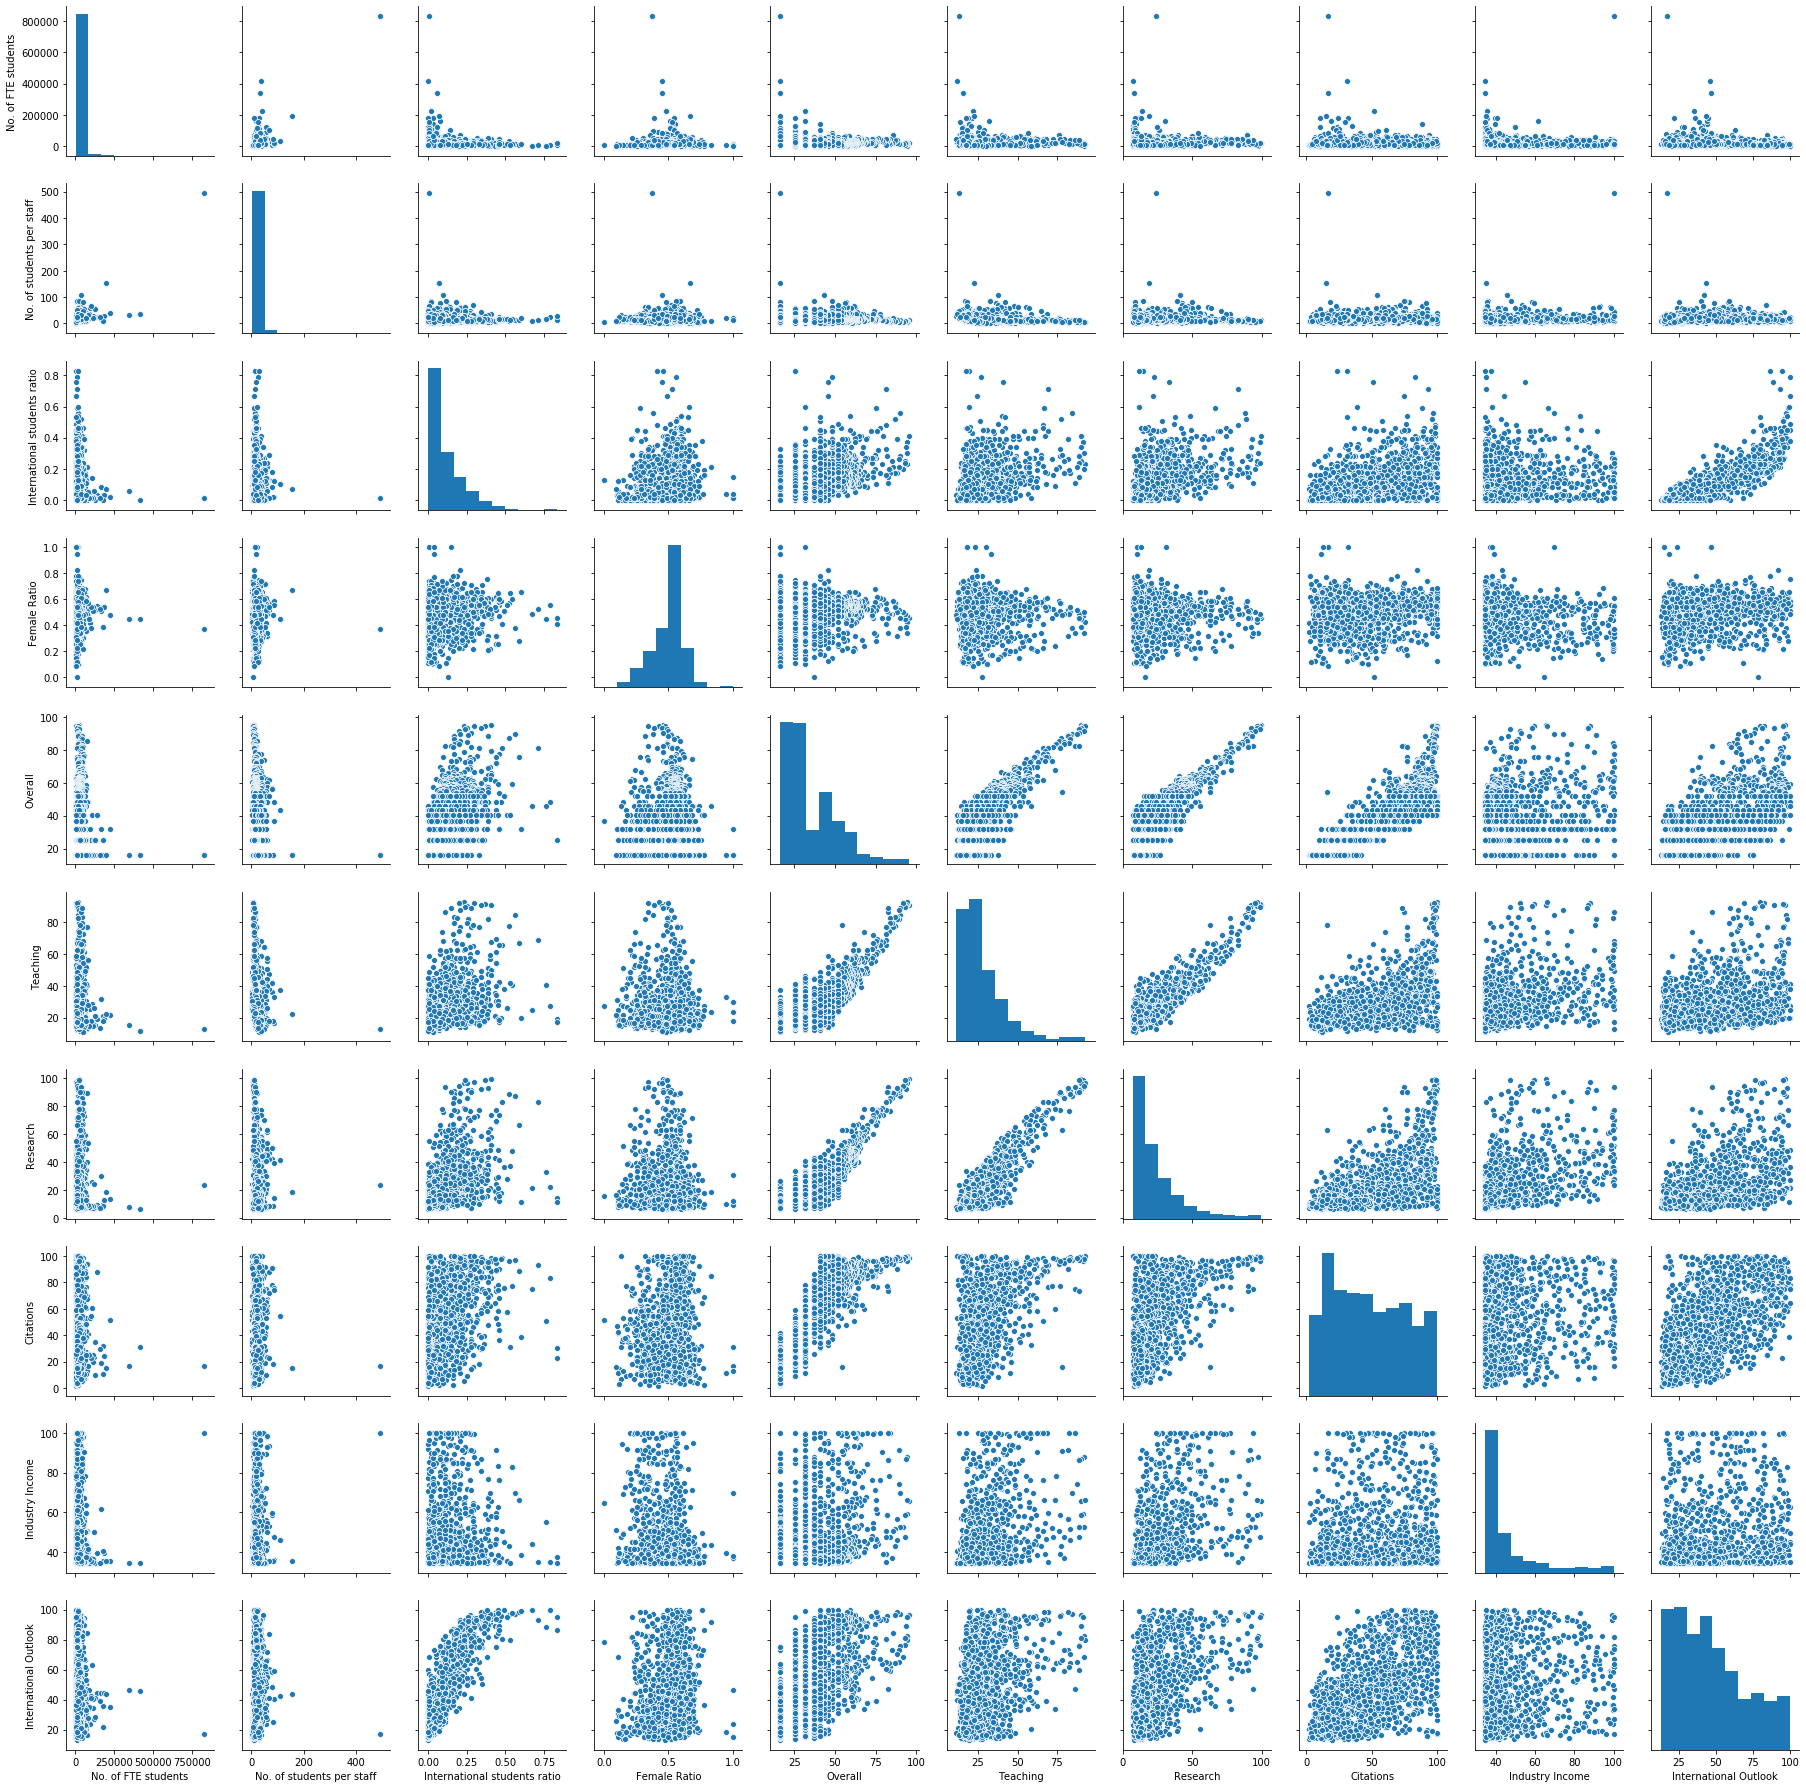

In [246]:
sns.pairplot(df_univ.dropna())

The `Overall` score is [calculated](https://www.timeshighereducation.com/world-university-rankings/world-university-rankings-2020-methodology) from the values of the indicators `Teaching` (30%), `Research` (30%), `Citations` (30%), `Industry Income` (2.5%) and `International Outlook` (7.5%), and hence, it is not surprising to see positive correlations between these variables.

Next, we want to find out whether there is any relation between the `Overall` score and any of  the variables in the first part of the table: `No. of FTE students`, `No. of students per staff`, `International students ratio` and `Female Ratio`.

### `Overall` score vs. `No. of FTE students`

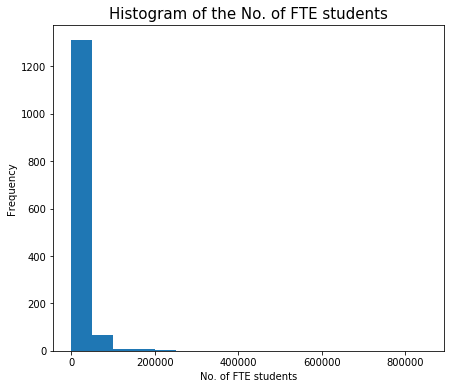

In [352]:
plt.figure(figsize=(7,6))
binwidth = 50000
data = df_univ['No. of FTE students']
aux = plt.hist(data,bins=range(0,binwidth*(2+int(data.max()/binwidth)),binwidth))
plt.title('Histogram of the No. of FTE students', {'fontsize': 15})
plt.xlabel('No. of FTE students')
plt.ylabel('Frequency')
plt.show()

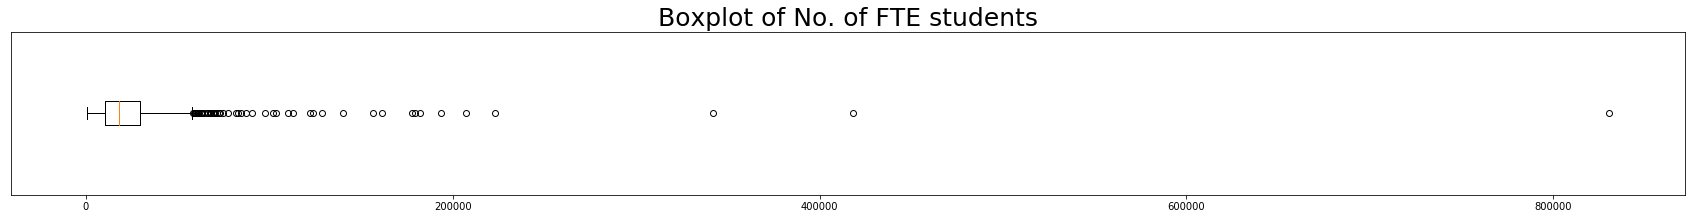

In [454]:
plt.figure(figsize=(30,3))
aux = plt.boxplot(df_univ['No. of FTE students'],vert=False)
plt.title('Boxplot of No. of FTE students', {'fontsize': 25})
plt.yticks([])
plt.show()

In [305]:
df_univ[df_univ['No. of FTE students']>=0.3*df_univ['No. of FTE students'].max()+0.7*df_univ['No. of FTE students'].min()]

Rank                  Name Country/Region  No. of FTE students  \
1005  1001+   Al-Azhar University          Egypt               342151   
1012  1001+    Anadolu University         Turkey               830104   
1360  1001+  Tribhuvan University          Nepal               418053   

      No. of students per staff  International students ratio  Female Ratio  \
1005                       32.6                          0.06          0.45   
1012                      493.5                          0.01          0.37   
1360                       36.0                          0.00          0.45   

      Overall  Teaching  Research  Citations  Industry Income  \
1005     16.4      15.2       8.3       16.5             34.5   
1012     16.4      13.0      24.1       16.5            100.0   
1360     16.4      11.4       6.9       30.8             34.4   

      International Outlook  
1005                   46.7  
1012                   17.3  
1360                   45.8

                     No. of FTE students   Overall
No. of FTE students             1.000000 -0.026884
Overall                        -0.026884  1.000000
                     No. of FTE students   Overall
No. of FTE students             1.000000  0.001555
Overall                         0.001555  1.000000


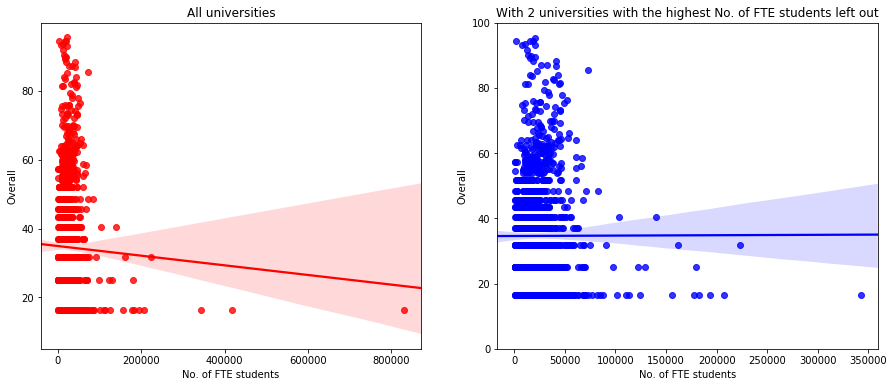

In [452]:
f,axes = plt.subplots(1, 2, figsize=(15, 6)) 
# parameter sharex=True could be used to achieve the same range for the x-axis but this is undesired in this case
sns.regplot(x='No. of FTE students',y='Overall',data=df_univ, ax=axes[0],color='r').set_title('All universities')
sns.regplot(x='No. of FTE students',y='Overall',data=df_univ[df_univ['No. of FTE students']<400000], ax=axes[1],
            color='b').set_title('With 2 universities with the highest No. of FTE students left out')
plt.ylim(0,100)

print(df_univ[['No. of FTE students','Overall']].corr())
print(df_univ[df_univ['No. of FTE students']<400000][['No. of FTE students','Overall']].corr())

### `Overall` score vs. `No. of students per staff`

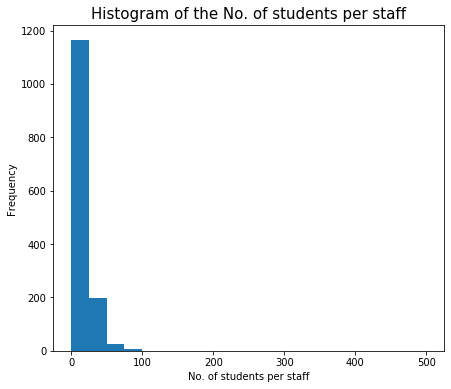

In [353]:
plt.figure(figsize=(7,6))
binwidth = 25
data = df_univ['No. of students per staff']
aux = plt.hist(data,bins=range(0,binwidth*(2+int(data.max()/binwidth)),binwidth))
plt.title('Histogram of the No. of students per staff', {'fontsize': 15})
plt.xlabel('No. of students per staff')
plt.ylabel('Frequency')
plt.show()

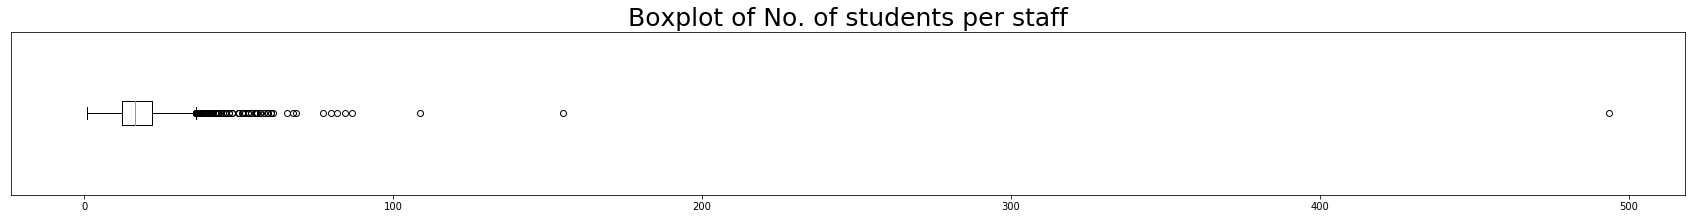

In [455]:
plt.figure(figsize=(30,3))
aux = plt.boxplot(df_univ['No. of students per staff'],vert=False)
plt.title('Boxplot of No. of students per staff', {'fontsize': 25})
plt.yticks([])
plt.show()

In [306]:
df_univ[df_univ['No. of students per staff']>=0.3*df_univ['No. of students per staff'].max()+0.7*df_univ['No. of students per staff'].min()]

Rank                        Name Country/Region  No. of FTE students  \
1012  1001+          Anadolu University         Turkey               830104   
1314  1001+  University of South Africa   South Africa               193874   

      No. of students per staff  International students ratio  Female Ratio  \
1012                      493.5                          0.01          0.37   
1314                      155.2                          0.07          0.67   

      Overall  Teaching  Research  Citations  Industry Income  \
1012     16.4      13.0      24.1       16.5            100.0   
1314     16.4      22.1      19.1       15.0             35.2   

      International Outlook  
1012                   17.3  
1314                   43.7

                           No. of students per staff  Overall
No. of students per staff                    1.00000 -0.02358
Overall                                     -0.02358  1.00000
                           No. of students per staff   Overall
No. of students per staff                   1.000000  0.006415
Overall                                     0.006415  1.000000


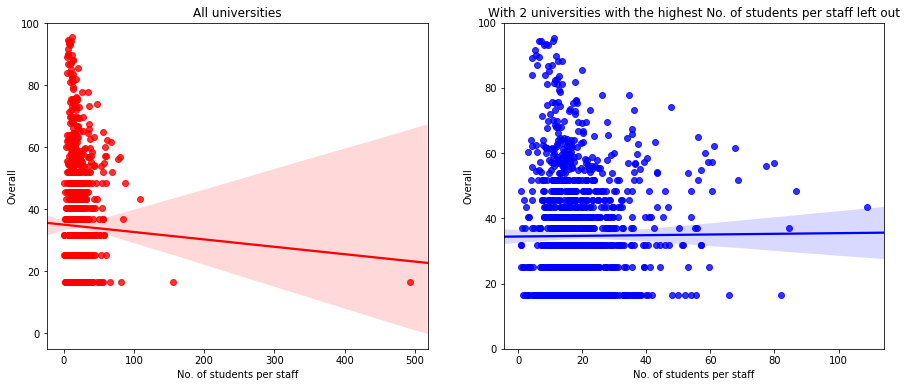

In [459]:
f,axes = plt.subplots(1, 2, figsize=(15, 6)) 
# parameter sharex=True could be used to achieve the same range for the x-axis but this is undesired in this case
sns.regplot(x='No. of students per staff',y='Overall',data=df_univ, ax=axes[0],color='r').set_title('All universities')
sns.regplot(x='No. of students per staff',y='Overall',data=df_univ[df_univ['No. of students per staff']<150], ax=axes[1],
            color='b').set_title('With 2 universities with the highest No. of students per staff left out')
plt.ylim(0,100)

print(df_univ[['No. of students per staff','Overall']].corr())
print(df_univ[df_univ['No. of students per staff']<150][['No. of students per staff','Overall']].corr())

### `Overall` score vs. `International students ratio`

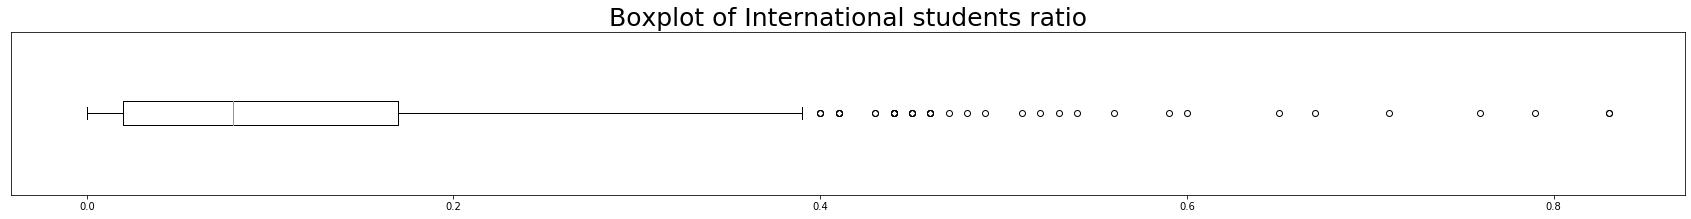

In [461]:
plt.figure(figsize=(30,3))
aux = plt.boxplot(df_univ['International students ratio'].dropna(),vert=False)
plt.title('Boxplot of International students ratio', {'fontsize': 25})
plt.yticks([])
plt.show()

International students ratio   Overall
International students ratio                      1.000000  0.562808
Overall                                           0.562808  1.000000

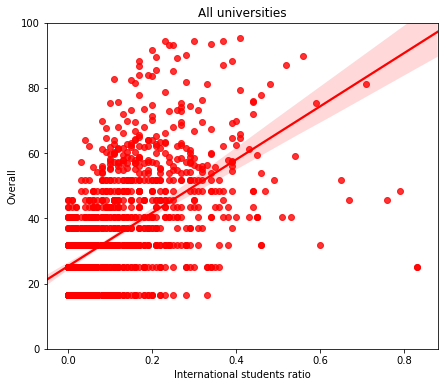

In [364]:
plt.figure(figsize=(7,6))
sns.regplot(x='International students ratio',y='Overall',data=df_univ,color='r').set_title('All universities')
plt.ylim(0,100)
df_univ[['International students ratio','Overall']].corr()

### `Overall` vs. `Female Ratio`

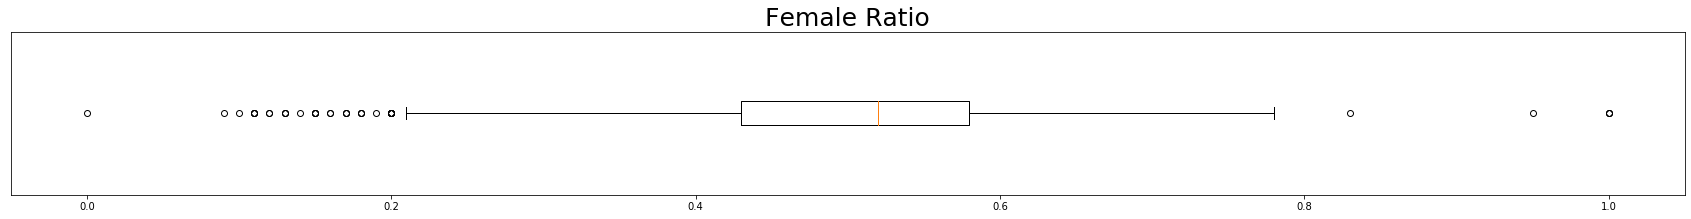

In [462]:
plt.figure(figsize=(30,3))
aux = plt.boxplot(df_univ['Female Ratio'].dropna(),vert=False)
plt.title('Female Ratio', {'fontsize': 25})
plt.yticks([])
plt.show()

Female Ratio   Overall
Female Ratio      1.000000  0.059456
Overall           0.059456  1.000000

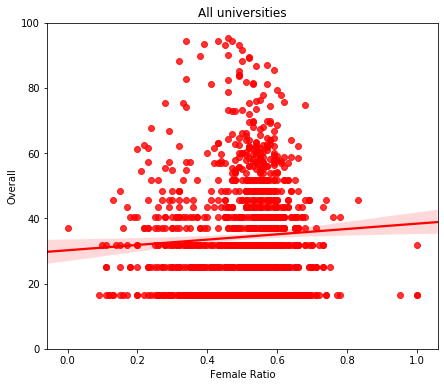

In [362]:
plt.figure(figsize=(7,6))
sns.regplot(x='Female Ratio',y='Overall',data=df_univ,color='r').set_title('All universities')
plt.ylim(0,100)
df_univ[['Female Ratio','Overall']].corr()

We can see that the variables `No. of FTE students`, `No. of students per staff` and `Female Ratio` are no good predictors for the `Overall` score since the respective regression lines are close to horizontal and the data points are very scattered and far from the fitted line. The respective correlations are low.

On the other hand, both the scatterplot with the fitted regression line and the correlation do suggest a relation between the `International students ratio` and the `Overall` score.

## Are the U.S. universities that good?
## Let's compare the (ranked) U.S. universities to the rest of the world:

In [97]:
# US:
df_univ[df_univ['Country/Region'] == 'United States'].describe()

No. of FTE students  No. of students per staff  \
count           172.000000                 172.000000   
mean          22829.168605                  14.874419   
std           13487.184146                   6.052773   
min            1809.000000                   1.000000   
25%           12125.000000                  10.950000   
50%           21404.000000                  15.550000   
75%           30422.500000                  18.325000   
max           66872.000000                  35.300000   

       International students ratio  Female Ratio     Overall    Teaching  \
count                    172.000000    166.000000  172.000000  172.000000   
mean                       0.134070      0.510783   49.870930   41.159302   
std                        0.086766      0.084394   18.829367   19.419580   
min                        0.010000      0.180000   16.400000   15.900000   
25%                        0.077500      0.480000   37.000000   26.900000   
50%                        0.110000      0.520000   45.650000   35.750000   
75%                        0.180000      0.560000   61.525000   49.675000   
max                        0.480000      0.740000   94.500000   92.800000   

         Research   Citations  Industry Income  International Outlook  
count  172.000000  172.000000       172.000000             172.000000  
mean    36.823837   73.155814        44.927326              48.540698  
std     24.014286   20.590929        13.668793              15.121290  
min      7.700000   23.300000        34.400000              19.700000  
25%     19.475000   58.775000        36.200000              37.550000  
50%     27.950000   74.650000        39.800000              46.100000  
75%     47.000000   93.325000        47.525000              59.675000  
max     98.600000  100.000000        99.900000              89.000000

In [98]:
# non-US:
df_univ[df_univ['Country/Region'] != 'United States'].describe()

No. of FTE students  No. of students per staff  \
count          1225.000000                1225.000000   
mean          23869.203265                  19.592980   
std           34685.265939                  17.844134   
min             558.000000                   0.900000   
25%            9986.000000                  12.500000   
50%           17432.000000                  16.500000   
75%           29311.000000                  22.500000   
max          830104.000000                 493.500000   

       International students ratio  Female Ratio      Overall     Teaching  \
count                   1223.000000   1165.000000  1225.000000  1225.000000   
mean                       0.110695      0.497150    32.442531    26.405306   
std                        0.121212      0.128072    15.679147    12.196524   
min                        0.000000      0.000000    16.400000    11.200000   
25%                        0.020000      0.420000    16.400000    17.800000   
50%                        0.070000      0.530000    31.750000    22.700000   
75%                        0.160000      0.580000    40.550000    30.800000   
max                        0.830000      1.000000    95.400000    91.400000   

          Research    Citations  Industry Income  International Outlook  
count  1225.000000  1225.000000      1225.000000            1225.000000  
mean     22.165633    44.572245        46.685959              46.896490  
std      15.609538    26.787556        16.596379              24.212544  
min       6.800000     1.700000        34.400000              13.100000  
25%      11.100000    20.600000        35.700000              25.800000  
50%      16.600000    40.700000        39.300000              42.300000  
75%      28.400000    66.900000        50.400000              63.400000  
max      99.600000   100.000000       100.000000              99.700000

In [99]:
# more concrete, Ireland:
df_univ[df_univ['Country/Region'] == 'Ireland'].describe()

No. of FTE students  No. of students per staff  \
count             9.000000                   9.000000   
mean          13718.444444                  22.744444   
std            5603.862443                   3.201215   
min            2265.000000                  18.000000   
25%           12619.000000                  21.100000   
50%           14221.000000                  21.900000   
75%           16853.000000                  24.000000   
max           22541.000000                  28.300000   

       International students ratio  Female Ratio    Overall   Teaching  \
count                      9.000000      7.000000   9.000000   9.000000   
mean                       0.242222      0.540000  43.766667  25.744444   
std                        0.167016      0.061101  10.343114   7.798736   
min                        0.100000      0.430000  25.200000  15.700000   
25%                        0.170000      0.515000  37.000000  20.300000   
50%                        0.180000      0.570000  45.650000  24.900000   
75%                        0.290000      0.580000  51.900000  30.100000   
max                        0.650000      0.590000  56.400000  41.700000   

        Research  Citations  Industry Income  International Outlook  
count   9.000000   9.000000         9.000000               9.000000  
mean   28.011111  67.811111        41.544444              83.155556  
std     8.669695  18.120047         3.827895               8.635553  
min    13.300000  32.900000        35.100000              71.800000  
25%    23.500000  54.600000        39.200000              78.200000  
50%    26.900000  75.400000        42.400000              81.300000  
75%    29.900000  77.500000        43.900000              92.500000  
max    43.900000  90.000000        47.500000              94.400000

## And what about the U.S. vs. non-U.S. universities in Top 500 of the ranking?
(Top **N** can be changed in the variable `maxRank`.)

In [100]:
maxRank = 500
top500 = df_univ[:maxRank]
# US:
top500[top500['Country/Region'] == 'United States'].describe()

No. of FTE students  No. of students per staff  \
count           121.000000                 121.000000   
mean          24549.958678                  13.147934   
std           14433.236336                   5.341865   
min            1809.000000                   1.000000   
25%           12735.000000                   9.400000   
50%           23116.000000                  13.000000   
75%           33186.000000                  16.600000   
max           66872.000000                  27.600000   

       International students ratio  Female Ratio     Overall    Teaching  \
count                    121.000000    115.000000  121.000000  121.000000   
mean                       0.151983      0.511652   58.109504   48.005785   
std                        0.083363      0.070883   16.108460   19.086240   
min                        0.010000      0.290000   40.550000   17.100000   
25%                        0.090000      0.480000   45.650000   33.900000   
50%                        0.140000      0.520000   51.900000   42.800000   
75%                        0.200000      0.550000   68.100000   57.500000   
max                        0.480000      0.740000   94.500000   92.800000   

         Research   Citations  Industry Income  International Outlook  
count  121.000000  121.000000       121.000000             121.000000  
mean    44.854545   83.545455        47.840496              52.735537  
std     24.356755   13.024631        14.977275              14.455967  
min     10.300000   55.500000        34.400000              19.700000  
25%     25.300000   72.700000        38.000000              40.900000  
50%     35.300000   84.400000        42.100000              52.200000  
75%     59.300000   96.400000        50.500000              63.300000  
max     98.600000  100.000000        99.900000              89.000000

In [101]:
# non-US:
top500[top500['Country/Region'] != 'United States'].describe()

No. of FTE students  No. of students per staff  \
count           379.000000                 379.000000   
mean          21758.841689                  20.975198   
std           15744.823464                  13.314893   
min             558.000000                   2.600000   
25%           10924.000000                  12.700000   
50%           18642.000000                  17.200000   
75%           29280.500000                  24.850000   
max          140126.000000                 108.800000   

       International students ratio  Female Ratio     Overall    Teaching  \
count                    379.000000    355.000000  379.000000  379.000000   
mean                       0.202427      0.511606   51.848549   37.386807   
std                        0.137621      0.116201   10.989742   14.844771   
min                        0.000000      0.130000   40.550000   11.900000   
25%                        0.105000      0.470000   43.400000   27.150000   
50%                        0.170000      0.550000   48.450000   35.200000   
75%                        0.290000      0.580000   57.500000   44.150000   
max                        0.790000      0.830000   95.400000   91.400000   

         Research   Citations  Industry Income  International Outlook  
count  379.000000  379.000000       379.000000             379.000000  
mean    38.352507   75.102639        54.777045              69.153298  
std     17.601131   15.998098        20.085157              21.622945  
min      7.600000   15.600000        34.400000              15.600000  
25%     26.300000   64.650000        38.500000              53.250000  
50%     35.500000   75.800000        45.800000              72.600000  
75%     47.150000   88.000000        66.850000              87.750000  
max     99.600000  100.000000       100.000000              99.700000

In [102]:
# Ireland:
top500[top500['Country/Region'] == 'Ireland'].describe()

No. of FTE students  No. of students per staff  \
count             6.000000                   6.000000   
mean          13620.333333                  23.166667   
std            7047.007270                   3.760674   
min            2265.000000                  18.000000   
25%           10446.000000                  21.300000   
50%           15382.000000                  22.500000   
75%           16859.000000                  25.725000   
max           22541.000000                  28.300000   

       International students ratio  Female Ratio    Overall   Teaching  \
count                      6.000000      4.000000   6.000000   6.000000   
mean                       0.285000      0.575000  49.991667  29.150000   
std                        0.192328      0.017321   4.205403   7.234846   
min                        0.120000      0.550000  45.650000  20.300000   
25%                        0.172500      0.572500  46.350000  25.450000   
50%                        0.235000      0.580000  50.175000  28.600000   
75%                        0.297500      0.582500  51.900000  30.625000   
max                        0.650000      0.590000  56.400000  41.700000   

        Research  Citations  Industry Income  International Outlook  
count   6.000000   6.000000         6.000000                6.00000  
mean   31.683333  78.850000        42.800000               86.65000  
std     7.426013   5.902796         3.439767                7.62804  
min    23.100000  73.600000        37.300000               78.20000  
25%    27.625000  75.625000        41.500000               80.17500  
50%    29.850000  76.900000        43.150000               86.90000  
75%    34.850000  79.600000        44.350000               93.40000  
max    43.900000  90.000000        47.500000               94.40000

We can see that even the best university in Ireland scores under the mean of the Top-500-U.S. universities in Overall (56.4 vs. 58.1), Teaching (41.7 vs. 48.0) and Research (43.9 vs. 44.9) scores. The typical No. of students per staff is substantially higher in Ireland than in the U.S. (23.2 in average vs. 13.1) which could possibly explain a part of the difference in the scores.

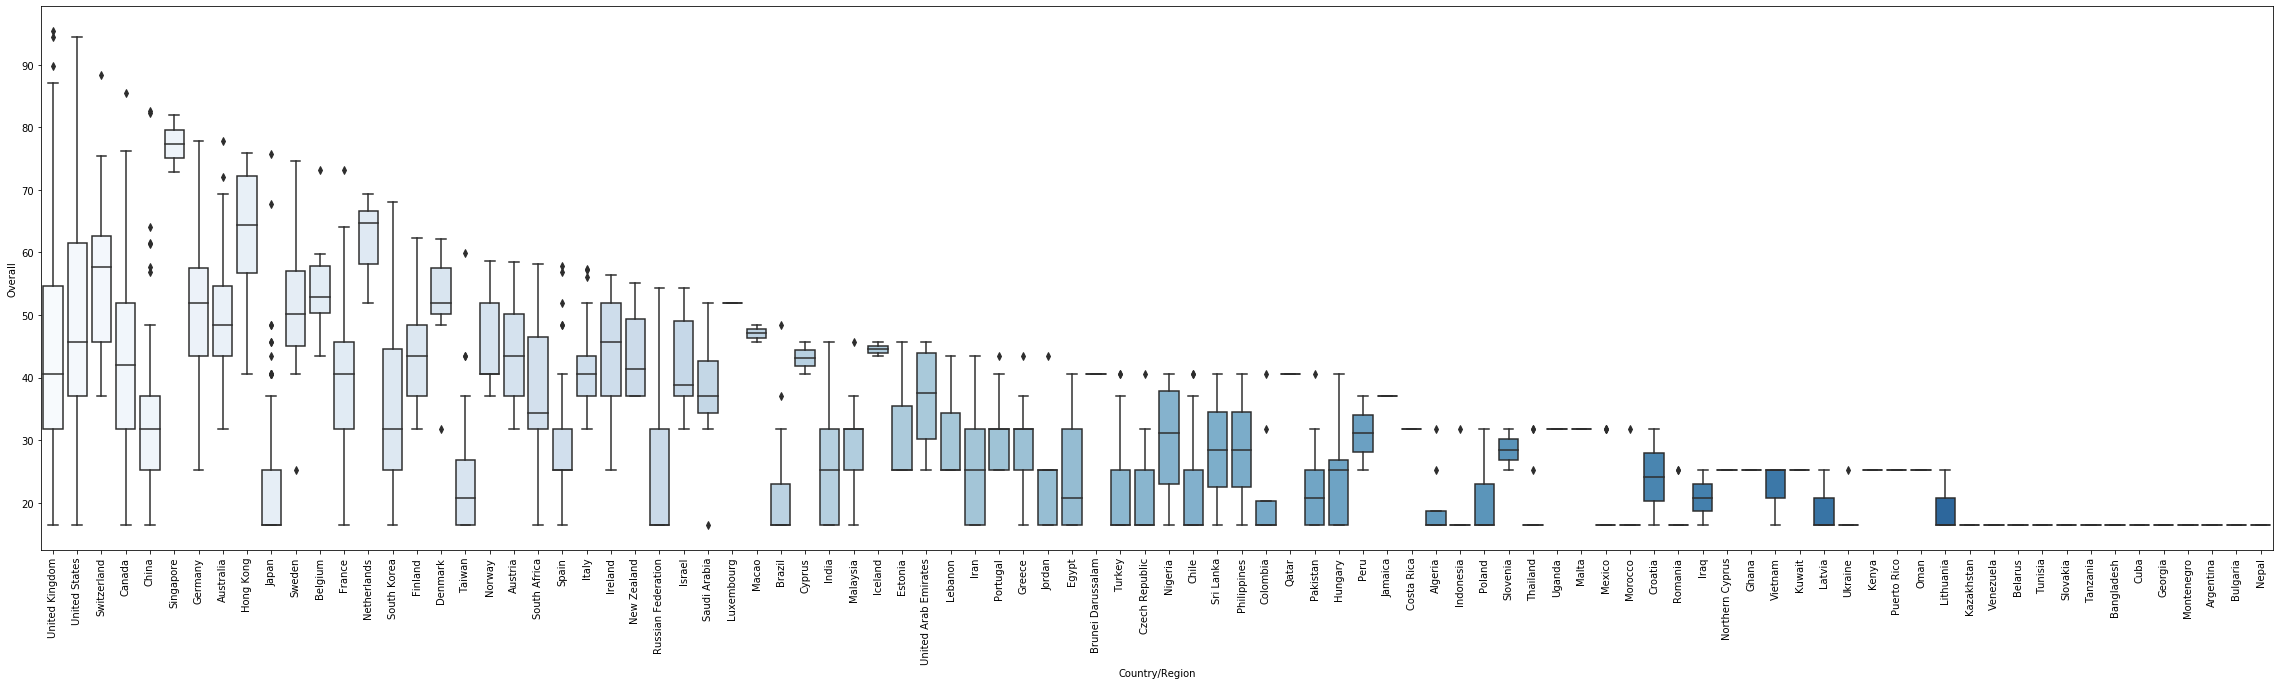

In [412]:
plt.figure(figsize=(40,10))
#df_univ_countries=pd.melt(df_univ,id_vars=['Country/Region'],value_vars=['Overall'],var_name='score')
#ax=sns.boxplot(x='Country/Region',y='value',data=df_univ_countries,palette=sns.color_palette("Blues",n_colors=100))#hue='score')
ax=sns.boxplot(x='Country/Region',y='Overall',data=df_univ,palette=sns.color_palette("Blues",n_colors=100))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

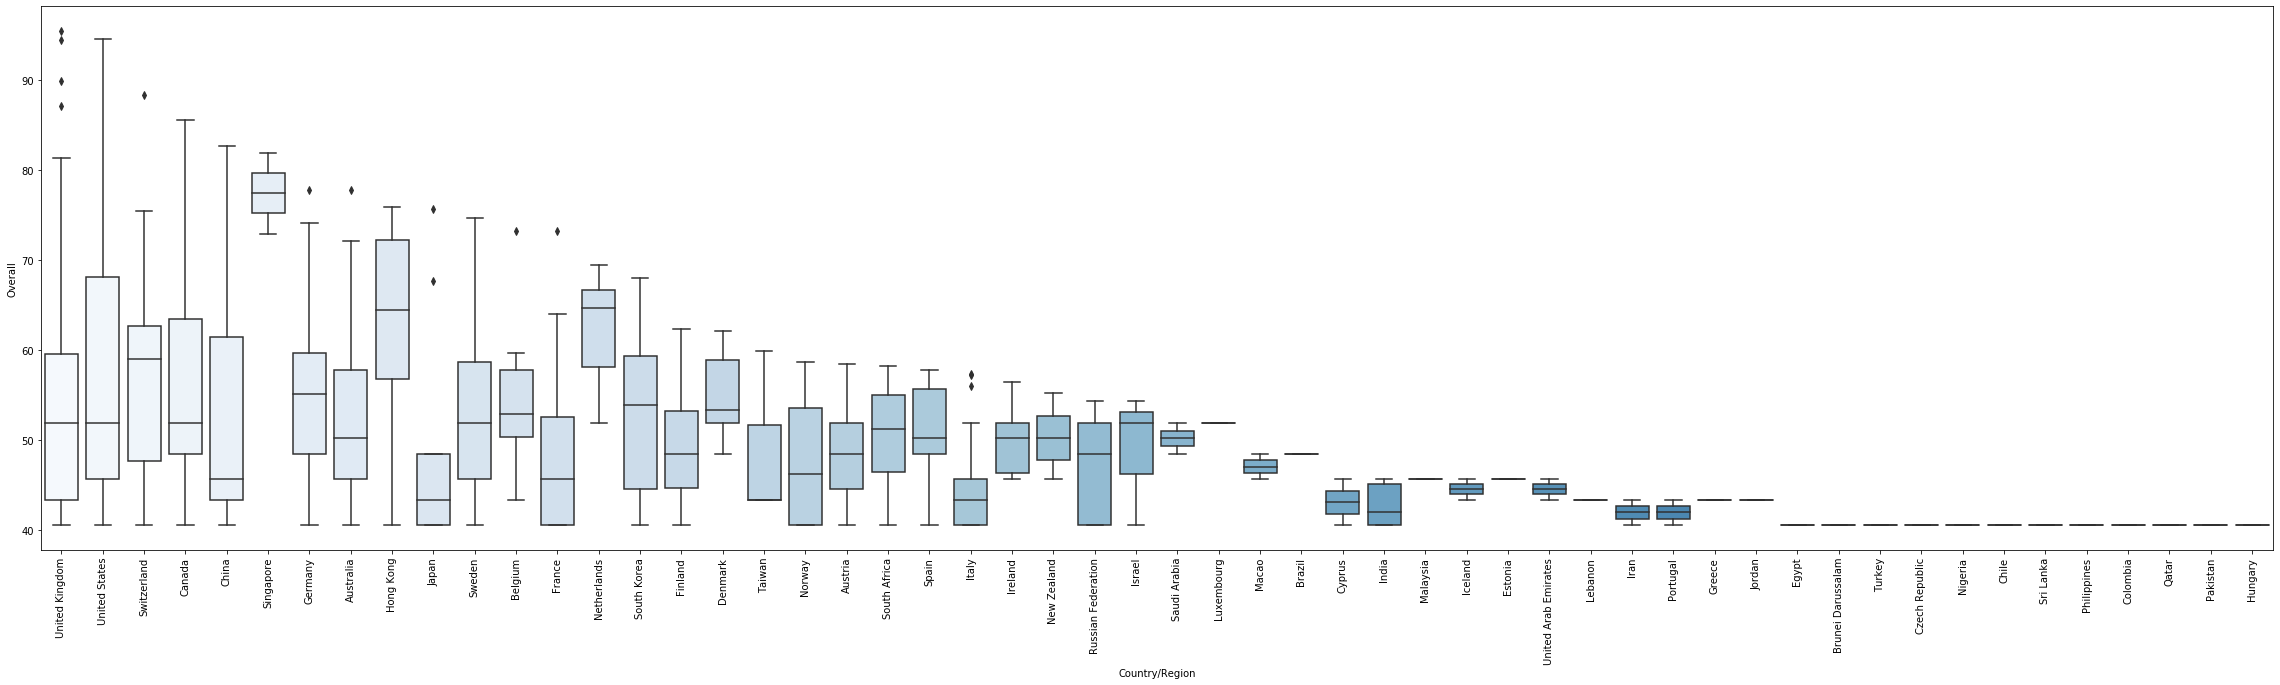

In [425]:
plt.figure(figsize=(40,10))
#df_univ_countries=pd.melt(df_univ,id_vars=['Country/Region'],value_vars=['Overall'],var_name='score')
#ax=sns.boxplot(x='Country/Region',y='value',data=df_univ_countries,palette=sns.color_palette("Blues",n_colors=100))#hue='score')
ax=sns.boxplot(x='Country/Region',y='Overall',data=df_univ[:500],palette=sns.color_palette("Blues",n_colors=60))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## Now, let's filter the U.S. universities that are in the Top 500 of the ranking. In the following parts, we only deal with these universities.


In [103]:
#maxRank = 500
univ = df_univ[:maxRank]
univ = univ[univ['Country/Region'] == 'United States'].reset_index(drop=True).drop(columns=['Country/Region'])   # we don't need 'Country/Region' anymore
univ

Rank                                   Name  No. of FTE students  \
0          2     California Institute of Technology                 2240   
1          4                    Stanford University                16135   
2          5  Massachusetts Institute of Technology                11247   
3          6                   Princeton University                 7983   
4          7                     Harvard University                20823   
..       ...                                    ...                  ...   
116  401–500              Oklahoma State University                21494   
117  401–500       Rensselaer Polytechnic Institute                 7798   
118  401–500  University of South Carolina-Columbia                32291   
119  401–500     University of Texas at San Antonio                24435   
120  401–500                    University of Tulsa                 5067   

     No. of students per staff  International students ratio  Female Ratio  \
0                          6.4                          0.30          0.34   
1                          7.3                          0.23          0.43   
2                          8.6                          0.34          0.39   
3                          8.1                          0.25          0.45   
4                          9.2                          0.24          0.49   
..                         ...                           ...           ...   
116                       15.8                          0.07          0.50   
117                       15.6                          0.20          0.32   
118                       16.2                          0.05          0.55   
119                       24.5                          0.04          0.51   
120                       12.4                          0.16          0.45   

     Overall  Teaching  Research  Citations  Industry Income  \
0      94.50      92.1      97.2       97.9             88.0   
1      94.30      92.8      96.4       99.9             66.2   
2      93.60      90.5      92.4       99.5             86.9   
3      93.20      90.3      96.3       98.8             58.6   
4      93.00      89.2      98.6       99.1             47.3   
..       ...       ...       ...        ...              ...   
116    40.55      24.1      21.5       71.1             36.9   
117    40.55      30.0      28.7       58.9             67.0   
118    40.55      33.2      25.5       63.7             36.2   
119    40.55      18.1      21.1       78.0             36.2   
120    40.55      33.5      16.2       68.9             50.5   

     International Outlook  
0                     82.5  
1                     79.5  
2                     89.0  
3                     81.1  
4                     76.3  
..                     ...  
116                   44.3  
117                   52.1  
118                   43.2  
119                   36.4  
120                   39.6  

[121 rows x 12 columns]

Get the geographical coordinates of the universities.

In [104]:
# loop over all universities:
lat_lng = []
for i in range(univ.shape[0]) :
    # get the name:
    name = univ.loc[i, 'Name']
    
    # initialize the coordinates to None:
    lat_lng_coords = None
    
    # loop until you get the coordinates:
    while(lat_lng_coords is None) :
        g = geocoder.arcgis('{}, United States'.format(name))
        lat_lng_coords = g.latlng
        lat_lng.append(lat_lng_coords)
        print('retrieved for ', name, ':\n  ... lat =', lat_lng_coords[0], ' lng =', lat_lng_coords[1])
        
print('\n===>>> Done!')

retrieved for  California Institute of Technology :
  ... lat = 34.135899930464426  lng = -118.12652997446475
retrieved for  Stanford University :
  ... lat = 37.429070000000024  lng = -122.16977999999995
retrieved for  Massachusetts Institute of Technology :
  ... lat = 42.358970000000056  lng = -71.09349999999995
retrieved for  Princeton University :
  ... lat = 40.3495400656405  lng = -74.6600899173385
retrieved for  Harvard University :
  ... lat = 42.37588000000005  lng = -71.12339999999995
retrieved for  Yale University :
  ... lat = 41.314500011108564  lng = -72.92326005554244
retrieved for  University of Chicago :
  ... lat = 41.79001001832193  lng = -87.60126995989475
retrieved for  University of Pennsylvania :
  ... lat = 39.953050000000076  lng = -75.19401999999997
retrieved for  Johns Hopkins University :
  ... lat = 39.32913000000008  lng = -76.61792999999994
retrieved for  University of California, Berkeley :
  ... lat = 37.86948000000007  lng = -122.25928999999996
retrie

retrieved for  Colorado School of Mines :
  ... lat = 39.74935000000005  lng = -105.22220999999996
retrieved for  University of New Mexico (Main campus) :
  ... lat = 35.08343000000008  lng = -106.61974999999995
retrieved for  North Carolina State University :
  ... lat = 35.78696003000736  lng = -78.66509997778294
retrieved for  Nova Southeastern University :
  ... lat = 25.929509933349024  lng = -80.16514994892952
retrieved for  Rush University :
  ... lat = 41.87367000000006  lng = -87.66909006333275
retrieved for  Stony Brook University :
  ... lat = 40.914300000000026  lng = -73.11620999999997
retrieved for  Temple University :
  ... lat = 39.980329930607766  lng = -75.15747999163277
retrieved for  The University of Tennessee-Knoxville :
  ... lat = 35.96973644688231  lng = -83.93621319913909
retrieved for  University of Texas at Dallas :
  ... lat = 32.98432997403493  lng = -96.74944000245091
retrieved for  Tulane University :
  ... lat = 29.93535003231499  lng = -90.123179978793

## Combine the university data with the geographical coordinates

In [105]:
ll = pd.DataFrame(lat_lng)
ll.columns = ['Latitude', 'Longitude']
univ_ll = pd.concat([univ,ll], axis=1)

univ_ll[9:14]

Rank                                   Name  No. of FTE students  \
9   =13     University of California, Berkeley                41081   
10   16                    Columbia University                26586   
11   17  University of California, Los Angeles                41066   
12   19                     Cornell University                22319   
13   20                        Duke University                15309   

    No. of students per staff  International students ratio  Female Ratio  \
9                        13.7                          0.17          0.50   
10                        5.8                          0.37           NaN   
11                        9.4                          0.17          0.54   
12                        9.8                          0.25          0.49   
13                        4.3                          0.19          0.49   

    Overall  Teaching  Research  Citations  Industry Income  \
9      88.3      83.0      90.6       99.2             46.1   
10     87.0      85.6      82.6       98.2             44.8   
11     86.8      83.1      88.6       97.3             51.3   
12     85.1      79.7      86.0       96.6             37.1   
13     84.0      82.4      76.8       97.0             99.9   

    International Outlook  Latitude  Longitude  
9                    70.4  37.86948 -122.25929  
10                   79.3  40.80816  -73.96365  
11                   64.1  33.92775 -118.37275  
12                   73.4  42.44635  -76.48269  
13                   61.5  36.00009  -78.93065

In [106]:
# now save the cleaned data to a csv file:
if save:
    univ_ll.to_csv('Top_US_Universities_2020_LatLng_cleaned.csv', index=False)

In [107]:
#from google.colab import files
#if save:
#    files.download('Top_US_Universities_2020_LatLng_cleaned.csv')

In [108]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_LatLng_cleaned.csv !!!

if load:
    #uploaded = files.upload()
    univ_ll = pd.read_csv('Top_US_Universities_2020_LatLng_cleaned.csv')
    univ_ll

Let's visualize the universities with the size (area) of the marker proportional to the number of students and the color indicating the ratio of international students.

Remark: Making legend (except of the colorbar) can be a bit tricky. Check, for example, [this](https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd), [this](https://stackoverflow.com/questions/52911688/python-folium-choropleth-map-colors-incorrect/52981115#52981115) and [this](https://github.com/python-visualization/folium/issues/528#issuecomment-415414283).

In [465]:
# create a map of US using latitude and longitude values:
map_US = folium.Map(location=[US_latitude, US_longitude], zoom_start=4)

# define the color map to visualize a ratio:
key = 'International students ratio'
vmin = 0.10 #univ_ll[key].min()
vmax = 0.40 #univ_ll[key].max()
colormap = branca.colormap.LinearColormap(colors=['darkblue','gold'],
                             index=[vmin,vmax],
                             vmin=vmin, 
                             vmax=vmax)
#colormap = branca.colormap.linear.YlOrRd_09.scale(0, 8500)
#colormap = colormap.to_step(index=[0, 1000, 3000, 5000, 8500])
colormap.caption = 'Ratio of International Students'
colormap.add_to(map_US)

# add markers to map
group0 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">universities</span>')
for lat, lng, rank, univ, Nstudents, ratio in zip(univ_ll['Latitude'], 
                                        univ_ll['Longitude'], 
                                        univ_ll['Rank'],
                                        univ_ll['Name'], 
                                        univ_ll['No. of FTE students'], 
                                        univ_ll[key]):
    if (np.isnan(ratio)):
        c = 'black'
    else:
        c = colormap(ratio)
    label = '{}. {}: {} students, {}\% internationals'.format(rank, univ, Nstudents, int(ratio*100))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(math.sqrt(int(Nstudents))//20),
        popup=label,
        key_on=univ_ll[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,
        parse_html=False).add_to(group0)  
group0.add_to(map_US)
folium.map.LayerControl('topright', collapsed=False).add_to(map_US)

#group1 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">universities</span>')
#for lat, lng in zip(range(500,520), range(70,50,-1)):
#    folium.CircleMarker((lat/10, lng/10), color='blue', radius=2).add_to(group1)
#group1.add_to(map_US)

# add the colormap showing ratio of the international students:
map_US.add_child(colormap)    

map_US.save('map_universities.html')

map_US

## Combined visualization of both the universities and the national parks:

In [466]:
# create a map of US using latitude and longitude values:
map_US = folium.Map(location=[US_latitude, US_longitude], zoom_start=3)

################################################
# VISUALIZING THE NATIONAL PARKS:
# define the color map to visualize a ratio:
key = 'Crowded'
vmin = 0
vmax = 5
colormap = branca.colormap.LinearColormap(colors=['green','red'],
                             index=[vmin,vmax],
                             vmin=vmin, 
                             vmax=vmax)
colormap = colormap.to_step(index=[0, 1, 2, 3, 4, 5])
colormap.caption = 'Visitor density (log10(number of visitors per year per km2))'
#colormap = colormap.to_step(index=[1, 10, 100, 1000, 10000, 100000],method='log') # logarithmic scale seems not to be working well
#colormap.caption = 'Visitor density (number of visitors per year per km2)'

# add markers to map
group0 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">national parks</span>')
for lat, lng, name, area, crowd in zip(parks['Latitude'], 
                                        parks['Longitude'], 
                                        parks['Name'], 
                                        parks['Area in km2'], 
                                        parks[key]):
    c = colormap(math.log10(crowd))
    #a = math.log10(area)+4
    a = 2*math.log10(area)+1
    label = '{}: \narea = {} km2, {} visitors per km2'.format(name, area, int(crowd))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=a,
        popup=label,
        key_on=parks[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.3,
        parse_html=False).add_to(group0)  
group0.add_to(map_US)

################################################
# VISUALIZING THE UNIVERSITIES:
# define the color map to visualize a ratio:
key = 'International students ratio'
vmin_u = 0.10 #univ_ll[key].min()
vmax_u = 0.40 #univ_ll[key].max()
colormap_u = branca.colormap.LinearColormap(colors=['darkblue','gold'],
                             index=[vmin_u,vmax_u],
                             vmin=vmin_u, 
                             vmax=vmax_u)
#colormap = branca.colormap.linear.YlOrRd_09.scale(0, 8500)
#colormap = colormap.to_step(index=[0, 1000, 3000, 5000, 8500])
colormap_u.caption = 'Ratio of International Students'
#colormap_u.add_to(map_US)

# add markers to map
group1 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">universities</span>')
for lat, lng, rank, univ, Nstudents, ratio in zip(univ_ll['Latitude'], 
                                        univ_ll['Longitude'], 
                                        univ_ll['Rank'],
                                        univ_ll['Name'], 
                                        univ_ll['No. of FTE students'], 
                                        univ_ll[key]):
    if (np.isnan(ratio)):
        c = 'black'
    else:
        c = colormap_u(ratio)
    label = '{}. {}: {} students, {}\% internationals'.format(rank, univ, Nstudents, int(ratio*100))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(math.sqrt(int(Nstudents))//20),
        popup=label,
        key_on=univ_ll[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,
        parse_html=False).add_to(group1)  
group1.add_to(map_US)

############################################
# SHOWING BOTH COLORMAPS AND THE LAYER CONTROL:
# add the colormap showing ratio of the international students:
map_US.add_child(colormap_u)    
# add the colormap showing visitor density of the national parks:
map_US.add_child(colormap)
# add the layer control:
folium.map.LayerControl('topright', collapsed=False).add_to(map_US)

map_US.save('map_parks_and_universities.html')

map_US

## Now, let's explore the surroundings of the top universities in US.
We will use the Foursquare API, with regular calls `explore` and `search`.

Notice that the Foursquare API has a limit of 950 regular API calls per day and 50 premium API calls per day for Sandbox Tier Accounts. By verifying your account using a credit card, you may upgrade to the Personal Tier to increase this limit to 99,500 regular API calls per day and 500 premium API calls per day. ([Reference](https://developer.foursquare.com/docs/api/troubleshooting/rate-limits))

Define Foursquare Credentials (hidden cell).

In [111]:
# @hidden_cell
#CLIENT_ID = 'your-client-ID' # your Foursquare ID
CLIENT_ID = 'XXX'
#CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
CLIENT_SECRET = 'XXX'

### Foursquare parameters

I am going to use radius = 1500 to explore a larger area around the universities. 

Tip: check the retrieved data, using too large radius would have no sense if everywhere full 100 venues would be found !!! 

According to the [description of Foursquare API](https://developer.foursquare.com/docs/api/venues/search), up to 50 results can be returned. However, I have been able to retrieved up to 100 results per location.

In [112]:
VERSION = '20191209' # Foursquare API version
radius = 1500
LIMIT = 100

Before we proceed, let's borrow the get_category_type function and the getNearbyVenues function from the Foursquare lab (at Cognitive Class / learnt via IBM Data Science at Coursera).
All the information we need is in the items key. Retrieve the necessary information from json and put in into a DataFrame.

In [113]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [114]:
def getNearbyVenues(names, latitudes, longitudes, radius): #=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        if (len(results) == 0) :
            print('===>>>   ... No venues close to', name, '!!!')
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [115]:
univ_venues = getNearbyVenues(names=univ_ll['Name'], latitudes=univ_ll['Latitude'], longitudes=univ_ll['Longitude'], radius=radius)
print('\n===>>> All retrieved!')

California Institute of Technology
Stanford University
Massachusetts Institute of Technology
Princeton University
Harvard University
Yale University
University of Chicago
University of Pennsylvania
Johns Hopkins University
University of California, Berkeley
Columbia University
University of California, Los Angeles
Cornell University
Duke University
University of Michigan-Ann Arbor
Northwestern University
University of Washington
Carnegie Mellon University
New York University
University of California, San Diego
Georgia Institute of Technology
University of Texas at Austin
University of Illinois at Urbana-Champaign
University of Wisconsin-Madison
Washington University in St Louis
Brown University
University of North Carolina at Chapel Hill
University of California, Davis
University of California, Santa Barbara
Boston University
University of Southern California
Ohio State University (Main campus)
Penn State (Main campus)
University of Minnesota
Emory University
Michigan State University


In [116]:
univ_venues.shape

(9411, 7)

In [141]:
# now save the retrieved venues to a csv file:
if save:
    univ_venues.to_csv('Top_US_Universities_2020_Venues_orig.csv', index=False)

In [ ]:
#from google.colab import files
#if save:
#    files.download('Top_US_Universities_2020_Venues_orig.csv')

In [468]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_Venues_orig.csv !!!
if load:
    #uploaded = files.upload()
    univ_venues = pd.read_csv('Top_US_Universities_2020_Venues_orig.csv')
    univ_venues

## Correct mistaken values

Inspecting the results reveals that there are no venues close to New Mexico Institute of Mining and Technology. That seems to be quite rare.
```
New Mexico Institute of Mining and Technology
===>>>   ... No venues close to New Mexico Institute of Mining and Technology !!!
```

Let's check how many venues were returned for each university. 

In [117]:
nr_venues = univ_venues.groupby('Name').count()[['Venue']]
nr_venues

Venue
Name                                    
American University                  100
Arizona State University (Tempe)     100
Boston College                        33
Boston University                    100
Brandeis University                   81
...                                  ...
Washington State University          100
Washington University in St Louis    100
Wayne State University                88
William & Mary                       100
Yale University                      100

[120 rows x 1 columns]

Let's check whether there are any universities with less than 20 venues: this could suggest that the retrieved location is not right. 

In [471]:
univ_aux = univ_venues.groupby('Name').count()[['Venue']]
susp = univ_aux[univ_aux['Venue'] < 20].reset_index()
susp

Name  Venue
0   Ohio State University (Main campus)      3
1              Penn State (Main campus)      4
2       University of California, Davis     18
3      University of California, Merced      5
4  University of California, Santa Cruz      4
5                 University of Florida     18
6                 University of Houston     14
7       University of Missouri-Columbia      2
8        University of Nebraska-Lincoln     14

Indeed, (manually) checking via the Google Maps reveals several errors in the original geographical coordinates; below are the coordinates as shown by the Google Maps as well as suggested additions / changes to the `Name` to get the proper coordinates.
- New Mexico Institute of Mining and Technology => add 'New Mexico' or 'Socorro'; 34.0639857,-106.8868248
- Ohio State University (Main campus) => change to 'Ohio State University, Columbus'; 40.006918, -83.030418
- Penn State => change to 'Penn State University'; 40.7983317,-77.8609841
- University of Florida => add 'Gainesville'; 29.6436099,-82.3550447
- University of Houston => add 'Houston, Texas'; 29.719758, -95.342029
- University of Missouri-Columbia => only use 'University of Missouri', or change to 'University of Missouri, Columbia, Missouri'; 38.9397238,-92.3274538
- University of Nebraska-Lincoln => add 'Lincoln'; 40.820151, -96.700544
- The other three universities (University of California, Davis; University of California, Merced; University of California, Santa Cruz) seem to be located correctly.

The coordinates of the following universities were wrong when tried for the first time but are OK now:
- University of Iowa => add 'Iowa City'; 41.6625086,-91.555371
- University of Washington => add 'Seattle'; 47.6537469,-122.3191011

So, let's edit the names of these universities and see if we can get the right coordinates now.

In [129]:
univ_edit = pd.DataFrame([['New Mexico Institute of Mining and Technology','New Mexico Institute of Mining and Technology, Socorro'],
                          ['Ohio State University (Main campus)','Ohio State University, Columbus'],
                          ['Penn State (Main campus)','Penn State University'],
                          ['University of Florida','University of Florida, Gainesville'],
                          ['University of Houston','University of Houston, Calhoun Rd, Houston'],
                          #['University of Iowa','University of Iowa, Iowa City'],
                          ['University of Missouri-Columbia','University of Missouri, Columbia, Missouri'],
                          ['University of Nebraska-Lincoln','University of Nebraska-Lincoln, Lincoln'],
                          #['University of Washington','University of Washington, Seattle']
                         ], 
                         columns=['Name','Name-edit'])
univ_edit

Name  \
0  New Mexico Institute of Mining and Technology   
1            Ohio State University (Main campus)   
2                       Penn State (Main campus)   
3                          University of Florida   
4                          University of Houston   
5                University of Missouri-Columbia   
6                 University of Nebraska-Lincoln   

                                           Name-edit  
0  New Mexico Institute of Mining and Technology,...  
1                    Ohio State University, Columbus  
2                              Penn State University  
3                 University of Florida, Gainesville  
4         University of Houston, Calhoun Rd, Houston  
5         University of Missouri, Columbia, Missouri  
6            University of Nebraska-Lincoln, Lincoln

In [130]:
# loop over all edited universities:
lat_lng_edit = []
for i in range(univ_edit.shape[0]) :
    # get the name:
    name = univ_edit.loc[i, 'Name-edit']
    
    # initialize the coordinates to None:
    lat_lng_coords = None
    
    # loop until you get the coordinates:
    while(lat_lng_coords is None) :
        g = geocoder.arcgis('{}, United States'.format(name))
        lat_lng_coords = g.latlng
        lat_lng_edit.append(lat_lng_coords)
        print('retrieved for ', name, ':\n  ... lat =', lat_lng_coords[0], ' lng =', lat_lng_coords[1])
        
print('\n===>>> Done!')

retrieved for  New Mexico Institute of Mining and Technology, Socorro :
  ... lat = 34.06014000000005  lng = -106.89186999999998
retrieved for  Ohio State University, Columbus :
  ... lat = 40.00629997662921  lng = -83.0163800693923
retrieved for  Penn State University :
  ... lat = 40.80707000000007  lng = -77.85887999999994
retrieved for  University of Florida, Gainesville :
  ... lat = 29.649730000000034  lng = -82.34112999999996
retrieved for  University of Houston, Calhoun Rd, Houston :
  ... lat = 29.722240000000056  lng = -95.33781999999997
retrieved for  University of Missouri, Columbia, Missouri :
  ... lat = 38.94441000000006  lng = -92.32929999999999
retrieved for  University of Nebraska-Lincoln, Lincoln :
  ... lat = 40.816900020052685  lng = -96.70009999999996

===>>> Done!


These seem to be right, so let's put these new names and coordinates into a dataframe:

In [131]:
ll_edit = pd.DataFrame(lat_lng_edit)
ll_edit.columns = ['Latitude', 'Longitude']
univ_ll_edit = pd.concat([univ_edit,ll_edit], axis=1)
univ_ll_edit

Name  \
0  New Mexico Institute of Mining and Technology   
1            Ohio State University (Main campus)   
2                       Penn State (Main campus)   
3                          University of Florida   
4                          University of Houston   
5                University of Missouri-Columbia   
6                 University of Nebraska-Lincoln   

                                           Name-edit  Latitude  Longitude  
0  New Mexico Institute of Mining and Technology,...  34.06014 -106.89187  
1                    Ohio State University, Columbus  40.00630  -83.01638  
2                              Penn State University  40.80707  -77.85888  
3                 University of Florida, Gainesville  29.64973  -82.34113  
4         University of Houston, Calhoun Rd, Houston  29.72224  -95.33782  
5         University of Missouri, Columbia, Missouri  38.94441  -92.32930  
6            University of Nebraska-Lincoln, Lincoln  40.81690  -96.70010

Now, we can correct both the names and geographical coordinates in the original dataframe.

In [132]:
for i in range(len(univ_ll_edit)):
  ind = (univ_ll['Name'] == univ_ll_edit.loc[i,'Name'])    # finding original name that was not identifying enough
  univ_ll.loc[ind,'Name'] = univ_ll_edit.loc[i,'Name-edit']     # put the corrected name
  univ_ll.loc[ind,'Latitude'] = univ_ll_edit.loc[i,'Latitude']
  univ_ll.loc[ind,'Longitude'] = univ_ll_edit.loc[i,'Longitude']

In [133]:
univ_ll.tail(10)

Rank                                               Name  \
111  401–500                             University of Kentucky   
112  401–500         University of Missouri, Columbia, Missouri   
113  401–500                    University of Missouri-St Louis   
114  401–500            University of Nebraska-Lincoln, Lincoln   
115  401–500  New Mexico Institute of Mining and Technology,...   
116  401–500                          Oklahoma State University   
117  401–500                   Rensselaer Polytechnic Institute   
118  401–500              University of South Carolina-Columbia   
119  401–500                 University of Texas at San Antonio   
120  401–500                                University of Tulsa   

     No. of FTE students  No. of students per staff  \
111                27078                       12.4   
112                28513                       13.3   
113                 7019                       16.0   
114                24610                       17.2   
115                 1809                       11.3   
116                21494                       15.8   
117                 7798                       15.6   
118                32291                       16.2   
119                24435                       24.5   
120                 5067                       12.4   

     International students ratio  Female Ratio  Overall  Teaching  Research  \
111                          0.04          0.55    40.55      37.0      24.9   
112                          0.06          0.53    40.55      34.9      24.2   
113                          0.06          0.58    40.55      30.0      24.7   
114                          0.11          0.48    40.55      30.1      28.0   
115                          0.08          0.30    40.55      22.3      14.6   
116                          0.07          0.50    40.55      24.1      21.5   
117                          0.20          0.32    40.55      30.0      28.7   
118                          0.05          0.55    40.55      33.2      25.5   
119                          0.04          0.51    40.55      18.1      21.1   
120                          0.16          0.45    40.55      33.5      16.2   

     Citations  Industry Income  International Outlook  Latitude  Longitude  
111       55.5             38.4                   38.0  38.03904  -84.50669  
112       65.7             35.5                   39.9  38.94441  -92.32930  
113       70.3             40.4                   40.6  38.62289  -90.19101  
114       63.2             38.6                   56.7  40.81690  -96.70010  
115       70.6             78.1                   62.9  34.06014 -106.89187  
116       71.1             36.9                   44.3  36.12618  -97.07187  
117       58.9             67.0                   52.1  42.73080  -73.67591  
118       63.7             36.2                   43.2  33.99772  -81.03015  
119       78.0             36.2                   36.4  29.58503  -98.61723  
120       68.9             50.5                   39.6  36.15370  -95.94518

In [134]:
# now save the corrected data to a csv file:
if save:
    univ_ll.to_csv('Top_US_Universities_2020_LatLng_corrected.csv', index=False)

In [135]:
#if save:
#    files.download('Top_US_Universities_2020_LatLng_corrected.csv')

In [136]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_LatLng_corrected.csv !!!

if load:
    #uploaded = files.upload()
    univ_ll = pd.read_csv('Top_US_Universities_2020_LatLng_corrected.csv')
    univ_ll

In [137]:
univ_venues_edit = getNearbyVenues(names=univ_ll_edit['Name-edit'], latitudes=univ_ll_edit['Latitude'], longitudes=univ_ll_edit['Longitude'], radius=radius)
print('\n===>>> All retrieved!')

New Mexico Institute of Mining and Technology, Socorro
Ohio State University, Columbus
Penn State University
University of Florida, Gainesville
University of Houston, Calhoun Rd, Houston
University of Missouri, Columbia, Missouri
University of Nebraska-Lincoln, Lincoln

===>>> All retrieved!


In [138]:
# these are the newly retrieved venues for the corrected university coordinates:
univ_venues_edit

Name  Latitude  Longitude  \
0    New Mexico Institute of Mining and Technology,...  34.06014 -106.89187   
1    New Mexico Institute of Mining and Technology,...  34.06014 -106.89187   
2    New Mexico Institute of Mining and Technology,...  34.06014 -106.89187   
3    New Mexico Institute of Mining and Technology,...  34.06014 -106.89187   
4    New Mexico Institute of Mining and Technology,...  34.06014 -106.89187   
..                                                 ...       ...        ...   
488            University of Nebraska-Lincoln, Lincoln  40.81690  -96.70010   
489            University of Nebraska-Lincoln, Lincoln  40.81690  -96.70010   
490            University of Nebraska-Lincoln, Lincoln  40.81690  -96.70010   
491            University of Nebraska-Lincoln, Lincoln  40.81690  -96.70010   
492            University of Nebraska-Lincoln, Lincoln  40.81690  -96.70010   

                               Venue  Venue Latitude  Venue Longitude  \
0             M Mountain Coffeehouse       34.057322      -106.892443   
1                      Bodega Lounge       34.063017      -106.891849   
2                    The Capitol Bar       34.057045      -106.892619   
3    Socorro Springs Brewing Company       34.070112      -106.892552   
4                     Domino's Pizza       34.068281      -106.893383   
..                               ...             ...              ...   
488                Saltdogs Baseball       40.823220       -96.714153   
489                          Hiro 88       40.816543       -96.712091   
490                      Rocket Fizz       40.816880       -96.712283   
491                         10 Below       40.815602       -96.709000   
492        Destinations Coffee House       40.826277       -96.701556   

       Venue Category  
0         Coffee Shop  
1          Sports Bar  
2                 Bar  
3             Brewery  
4         Pizza Place  
..                ...  
488  Baseball Stadium  
489  Sushi Restaurant  
490       Candy Store  
491               Bar  
492       Coffee Shop  

[493 rows x 7 columns]

In [474]:
univ_venues_edit.groupby('Name').count()[['Venue']]

Venue
Name                                                     
New Mexico Institute of Mining and Technology, ...     23
Ohio State University, Columbus                        93
Penn State University                                  94
University of Florida, Gainesville                     52
University of Houston, Calhoun Rd, Houston             58
University of Missouri, Columbia, Missouri             73
University of Nebraska-Lincoln, Lincoln               100

We can see that now, using the right geographical coordinates, substantially more venues are found.

Next, we need to drop the mistaken venues for the edited universities and add the newly retrieved ones.

In [143]:
# drop the mistaken venues:
for name in univ_ll_edit['Name']:
  univ_venues = univ_venues[univ_venues['Name'] != name]
univ_venues

Name  Latitude  Longitude  \
0     California Institute of Technology   34.1359 -118.12653   
1     California Institute of Technology   34.1359 -118.12653   
2     California Institute of Technology   34.1359 -118.12653   
3     California Institute of Technology   34.1359 -118.12653   
4     California Institute of Technology   34.1359 -118.12653   
...                                  ...       ...        ...   
9406                 University of Tulsa   36.1537  -95.94518   
9407                 University of Tulsa   36.1537  -95.94518   
9408                 University of Tulsa   36.1537  -95.94518   
9409                 University of Tulsa   36.1537  -95.94518   
9410                 University of Tulsa   36.1537  -95.94518   

                        Venue  Venue Latitude  Venue Longitude  \
0      Turtle Pond at Caltech       34.136934      -118.125076   
1         Athenaeum - Caltech       34.136842      -118.121675   
2       Braun Athletic Center       34.133974      -118.127581   
3                       Float       34.139306      -118.131690   
4               Red Door Café       34.137354      -118.123820   
...                       ...             ...              ...   
9406   K-dub Food Truck Popup       36.159640       -95.957646   
9407       Fair Fellow Coffee       36.160054       -95.957505   
9408               Tday Magic       36.165316       -95.948219   
9409      Ziegler Art & Frame       36.160169       -95.958764   
9410  Animal Aid Thrift Store       36.140970       -95.939980   

              Venue Category  
0                       Lake  
1                 Restaurant  
2       Gym / Fitness Center  
3             Sandwich Place  
4                Coffee Shop  
...                      ...  
9406              Food Truck  
9407             Coffee Shop  
9408     American Restaurant  
9409     Arts & Crafts Store  
9410  Thrift / Vintage Store  

[9356 rows x 7 columns]

In [144]:
# add the newly retrieved venues:
univ_venues = pd.concat([univ_venues, univ_venues_edit])

In [145]:
print(univ_venues.shape)
univ_venues.tail()

(9849, 7)


Name  Latitude  Longitude  \
488  University of Nebraska-Lincoln, Lincoln   40.8169   -96.7001   
489  University of Nebraska-Lincoln, Lincoln   40.8169   -96.7001   
490  University of Nebraska-Lincoln, Lincoln   40.8169   -96.7001   
491  University of Nebraska-Lincoln, Lincoln   40.8169   -96.7001   
492  University of Nebraska-Lincoln, Lincoln   40.8169   -96.7001   

                         Venue  Venue Latitude  Venue Longitude  \
488          Saltdogs Baseball       40.823220       -96.714153   
489                    Hiro 88       40.816543       -96.712091   
490                Rocket Fizz       40.816880       -96.712283   
491                   10 Below       40.815602       -96.709000   
492  Destinations Coffee House       40.826277       -96.701556   

       Venue Category  
488  Baseball Stadium  
489  Sushi Restaurant  
490       Candy Store  
491               Bar  
492       Coffee Shop

In [146]:
# now save the venues to a csv file:
if save:
    univ_venues.to_csv('Top_US_Universities_2020_Venues_corrected.csv', index=False)

In [147]:
#from google.colab import files
#if save:
#    files.download('Top_US_Universities_2020_Venues_corrected.csv')

In [148]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_Venues_corrected.csv !!!

if load:
    #uploaded = files.upload()
    univ_venues = pd.read_csv('Top_US_Universities_2020_Venues_corrected.csv')
    univ_venues

How many unique categories can be curated from all the returned venues?

In [149]:
print('There are {} unique categories.'.format(len(univ_venues['Venue Category'].unique())))

There are 438 unique categories.


## Now we need to redo the original analyses with corrected data!
## Analyze each university

In [150]:
# one hot encoding
univ_onehot = pd.get_dummies(univ_venues[['Venue Category']], prefix="", prefix_sep="")
univ_onehot.shape

(9849, 438)

In [151]:
# add university column back to dataframe
univ_onehot.insert(loc=0, column='Name', value=univ_venues['Name']) 
univ_onehot.head()

Name  ATM  Accessories Store  Adult Boutique  \
0  California Institute of Technology    0                  0               0   
1  California Institute of Technology    0                  0               0   
2  California Institute of Technology    0                  0               0   
3  California Institute of Technology    0                  0               0   
4  California Institute of Technology    0                  0               0   

   Advertising Agency  African Restaurant  Airport  Airport Terminal  \
0                   0                   0        0                 0   
1                   0                   0        0                 0   
2                   0                   0        0                 0   
3                   0                   0        0                 0   
4                   0                   0        0                 0   

   American Restaurant  Amphitheater  ...  Waterfront  Whisky Bar  Wine Bar  \
0                    0             0  ...           0           0         0   
1                    0             0  ...           0           0         0   
2                    0             0  ...           0           0         0   
3                    0             0  ...           0           0         0   
4                    0             0  ...           0           0         0   

   Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0          0       0            0              0            0    0   
1          0       0            0              0            0    0   
2          0       0            0              0            0    0   
3          0       0            0              0            0    0   
4          0       0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 439 columns]

Next, let's group rows by university and by taking the mean of the frequency of occurrence of each category.

In [152]:
univ_grouped = univ_onehot.groupby('Name').mean().reset_index()
univ_grouped.head(10)

Name       ATM  Accessories Store  \
0                 American University  0.000000                0.0   
1    Arizona State University (Tempe)  0.000000                0.0   
2                      Boston College  0.000000                0.0   
3                   Boston University  0.000000                0.0   
4                 Brandeis University  0.012346                0.0   
5                    Brown University  0.000000                0.0   
6  California Institute of Technology  0.000000                0.0   
7          Carnegie Mellon University  0.000000                0.0   
8     Case Western Reserve University  0.000000                0.0   
9                    Clark University  0.000000                0.0   

   Adult Boutique  Advertising Agency  African Restaurant  Airport  \
0             0.0                 0.0                 0.0      0.0   
1             0.0                 0.0                 0.0      0.0   
2             0.0                 0.0                 0.0      0.0   
3             0.0                 0.0                 0.0      0.0   
4             0.0                 0.0                 0.0      0.0   
5             0.0                 0.0                 0.0      0.0   
6             0.0                 0.0                 0.0      0.0   
7             0.0                 0.0                 0.0      0.0   
8             0.0                 0.0                 0.0      0.0   
9             0.0                 0.0                 0.0      0.0   

   Airport Terminal  American Restaurant  Amphitheater  ...  Waterfront  \
0               0.0             0.020000           0.0  ...         0.0   
1               0.0             0.030000           0.0  ...         0.0   
2               0.0             0.000000           0.0  ...         0.0   
3               0.0             0.040000           0.0  ...         0.0   
4               0.0             0.012346           0.0  ...         0.0   
5               0.0             0.020000           0.0  ...         0.0   
6               0.0             0.060000           0.0  ...         0.0   
7               0.0             0.020000           0.0  ...         0.0   
8               0.0             0.011494           0.0  ...         0.0   
9               0.0             0.049383           0.0  ...         0.0   

   Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  \
0         0.0      0.00   0.000000     0.0     0.000000            0.0   
1         0.0      0.01   0.000000     0.0     0.010000            0.0   
2         0.0      0.00   0.000000     0.0     0.000000            0.0   
3         0.0      0.01   0.010000     0.0     0.000000            0.0   
4         0.0      0.00   0.012346     0.0     0.000000            0.0   
5         0.0      0.01   0.000000     0.0     0.000000            0.0   
6         0.0      0.01   0.010000     0.0     0.000000            0.0   
7         0.0      0.00   0.000000     0.0     0.000000            0.0   
8         0.0      0.00   0.011494     0.0     0.011494            0.0   
9         0.0      0.00   0.000000     0.0     0.012346            0.0   

   Yoga Studio  Zoo  Zoo Exhibit  
0     0.010000  0.0          0.0  
1     0.020000  0.0          0.0  
2     0.000000  0.0          0.0  
3     0.010000  0.0          0.0  
4     0.000000  0.0          0.0  
5     0.010000  0.0          0.0  
6     0.000000  0.0          0.0  
7     0.010000  0.0          0.0  
8     0.022989  0.0          0.0  
9     0.000000  0.0          0.0  

[10 rows x 439 columns]

In [153]:
shape = univ_grouped.shape
print('There are {} universities and {} unique categories.'.format(shape[0], shape[1]-1))

There are 121 universities and 438 unique categories.


Let's print each university along with the top 5 most common venues.

In [154]:
num_top_venues = 5

for univ in univ_grouped['Name']:
    print("----"+univ+"----")
    # take only the row belonging to this university & transpose it:
    temp = univ_grouped[univ_grouped['Name'] == univ].T.reset_index()   
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]    # first row = just 'University' & its name -> drop
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----American University----
               venue  freq
0        Coffee Shop  0.07
1     Sandwich Place  0.04
2      Grocery Store  0.03
3  Convenience Store  0.03
4  Indian Restaurant  0.03


----Arizona State University (Tempe)----
                venue  freq
0         Pizza Place  0.08
1         Coffee Shop  0.06
2      Sandwich Place  0.05
3  Mexican Restaurant  0.05
4                 Bar  0.03


----Boston College----
                venue   freq
0         Pizza Place  0.121
1    Sushi Restaurant  0.091
2   Convenience Store  0.061
3  Chinese Restaurant  0.061
4                Lake  0.061


----Boston University----
                 venue  freq
0               Bakery  0.05
1          Pizza Place  0.04
2  American Restaurant  0.04
3                 Park  0.03
4      Thai Restaurant  0.03


----Brandeis University----
                venue   freq
0          Donut Shop  0.049
1               Trail  0.049
2                 Bar  0.049
3         Pizza Place  0.049
4  Mexican Restaurant  

4                Café  0.04


----Tulane University----
                   venue  freq
0            Coffee Shop  0.07
1                    Bar  0.07
2            Pizza Place  0.05
3                   Café  0.04
4  Vietnamese Restaurant  0.04


----University at Buffalo----
            venue   freq
0           Hotel  0.170
1     Coffee Shop  0.106
2            Café  0.085
3     Pizza Place  0.043
4  Sandwich Place  0.043


----University of Alabama----
                  venue   freq
0                   Bar  0.111
1        Sandwich Place  0.097
2    Mexican Restaurant  0.056
3  Fast Food Restaurant  0.042
4              Boutique  0.042


----University of Alabama at Birmingham----
                 venue  freq
0                  Bar  0.06
1  American Restaurant  0.06
2          Coffee Shop  0.06
3                Hotel  0.05
4   Mexican Restaurant  0.04


----University of Alaska Fairbanks----
                 venue   freq
0          Coffee Shop  0.118
1                  Bar  0.059
2      

4  American Restaurant  0.05


----Virginia Polytechnic Institute and State University----
                venue   freq
0         Pizza Place  0.045
1  Chinese Restaurant  0.045
2         Coffee Shop  0.045
3      Sandwich Place  0.045
4               Hotel  0.034


----Wake Forest University----
               venue   freq
0        Coffee Shop  0.067
1  Convenience Store  0.067
2              Hotel  0.067
3       Food Service  0.033
4   Asian Restaurant  0.033


----Washington State University----
                 venue  freq
0  American Restaurant  0.06
1                 Café  0.04
2                  Bar  0.04
3          Yoga Studio  0.04
4          Coffee Shop  0.04


----Washington University in St Louis----
                 venue  freq
0          Coffee Shop  0.04
1   Italian Restaurant  0.04
2  American Restaurant  0.04
3      Thai Restaurant  0.03
4       Ice Cream Shop  0.03


----Wayne State University----
                 venue   freq
0          Coffee Shop  0.080
1          

The result is very long again, these are the most common venues of the last three universities:
```
----Wayne State University----
                 venue  freq
0                  Bar  0.06
1  American Restaurant  0.06
2          Coffee Shop  0.05
3          Pizza Place  0.05
4       Sandwich Place  0.04


----William & Mary----
                 venue  freq
0                Hotel  0.09
1       History Museum  0.08
2  American Restaurant  0.06
3            Gift Shop  0.04
4        Historic Site  0.04


----Yale University----
                 venue  freq
0          Coffee Shop  0.07
1          Pizza Place  0.06
2   Italian Restaurant  0.05
3  American Restaurant  0.04
4                  Bar  0.04
```

Let's put that into a pandas dataframe

First, let's borrow from the Foursquare Labs (Cognitive Class, via IBM Data Science at Coursera) a function to sort the venues in descending order.

In [155]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # get number of undefined top-10 venues (for universities having just a few venues close by):
    Nzero = (row_categories_sorted[:10] == 0).sum() 
    
    result = row_categories_sorted.index.values[0:num_top_venues]
    
    # for universities with just a few venues, we are not going to sort non-existing venues => assign NaN to non-existing ladder places:
    if (Nzero>0):
        result[(num_top_venues-Nzero):num_top_venues] = np.nan
    
    return result #row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each university.

In [156]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']    # to get 1st, 2nd, 3rd... and the rest will be n-th

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
univ_venues_sorted = pd.DataFrame(columns=columns)
univ_venues_sorted['Name'] = univ_grouped['Name']

for ind in np.arange(univ_grouped.shape[0]):
    univ_venues_sorted.iloc[ind, 1:] = return_most_common_venues(univ_grouped.iloc[ind, :], num_top_venues)

univ_venues_sorted

Name 1st Most Common Venue  \
0                  American University           Coffee Shop   
1     Arizona State University (Tempe)           Pizza Place   
2                       Boston College           Pizza Place   
3                    Boston University                Bakery   
4                  Brandeis University                 Trail   
..                                 ...                   ...   
116        Washington State University   American Restaurant   
117  Washington University in St Louis    Italian Restaurant   
118             Wayne State University           Coffee Shop   
119                     William & Mary                 Hotel   
120                    Yale University           Pizza Place   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0          Sandwich Place           Pizza Place              Bus Stop   
1             Coffee Shop        Sandwich Place    Mexican Restaurant   
2        Sushi Restaurant                  Lake     Convenience Store   
3     American Restaurant           Pizza Place  Gym / Fitness Center   
4             Pizza Place                   Bar            Donut Shop   
..                    ...                   ...                   ...   
116           Yoga Studio                  Café                   Bar   
117           Coffee Shop   American Restaurant        Sandwich Place   
118           Pizza Place   American Restaurant    Chinese Restaurant   
119        History Museum   American Restaurant         Historic Site   
120           Coffee Shop                   Bar    Italian Restaurant   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0       Indian Restaurant    Mexican Restaurant         Grocery Store   
1                     Bar   American Restaurant          Burger Joint   
2      Chinese Restaurant                  Café           Coffee Shop   
3                    Café                  Park       Thai Restaurant   
4      Mexican Restaurant        Sandwich Place    Chinese Restaurant   
..                    ...                   ...                   ...   
116           Coffee Shop            Beer Store      Sushi Restaurant   
117       Thai Restaurant        Ice Cream Shop            Art Museum   
118        History Museum        Sandwich Place            Art Museum   
119           Pizza Place             Gift Shop        Ice Cream Shop   
120     Indian Restaurant               Theater                  Café   

    8th Most Common Venue      9th Most Common Venue   10th Most Common Venue  
0              Food Truck          Convenience Store                     Park  
1                   Hotel              Deli / Bodega             Dessert Shop  
2                   Trail                       Park              Golf Course  
3                   Hotel  Middle Eastern Restaurant                    Trail  
4      Italian Restaurant          Indian Restaurant  New American Restaurant  
..                    ...                        ...                      ...  
116              Boutique   Mediterranean Restaurant       Mexican Restaurant  
117             Rock Club                       Park                   Bakery  
118               Dog Run    New American Restaurant                Gift Shop  
119            Art Museum                        Bar                   Resort  
120                Bakery               Cocktail Bar      American Restaurant  

[121 rows x 11 columns]

In [478]:
univ_grouped_count = univ_onehot.groupby('Name').sum().reset_index()

### What types of venues are most typical in the surroundings of US universities?

In [592]:
univ_typical = pd.DataFrame(univ_onehot.drop('Name',axis=1).sum()).rename(columns={0:'Frequency'}).sort_values(by='Frequency',ascending=False)
univ_typical.head(20)

Frequency
Coffee Shop                 506
Pizza Place                 386
Sandwich Place              343
Bar                         284
American Restaurant         274
Café                        242
Mexican Restaurant          232
Hotel                       223
Park                        192
Italian Restaurant          154
Ice Cream Shop              151
Bakery                      147
Fast Food Restaurant        132
Burger Joint                127
Chinese Restaurant          114
Grocery Store               106
Restaurant                  105
Breakfast Spot               88
Convenience Store            86
Gym                          86

In [601]:
common_venues = univ_typical.reset_index().rename(columns={'index':'Venue Category'})
common_venues

Venue Category  Frequency
0             Coffee Shop        506
1             Pizza Place        386
2          Sandwich Place        343
3                     Bar        284
4     American Restaurant        274
..                    ...        ...
433          Squash Court          1
434              Heliport          1
435  Marijuana Dispensary          1
436      Malay Restaurant          1
437           Hockey Rink          1

[438 rows x 2 columns]

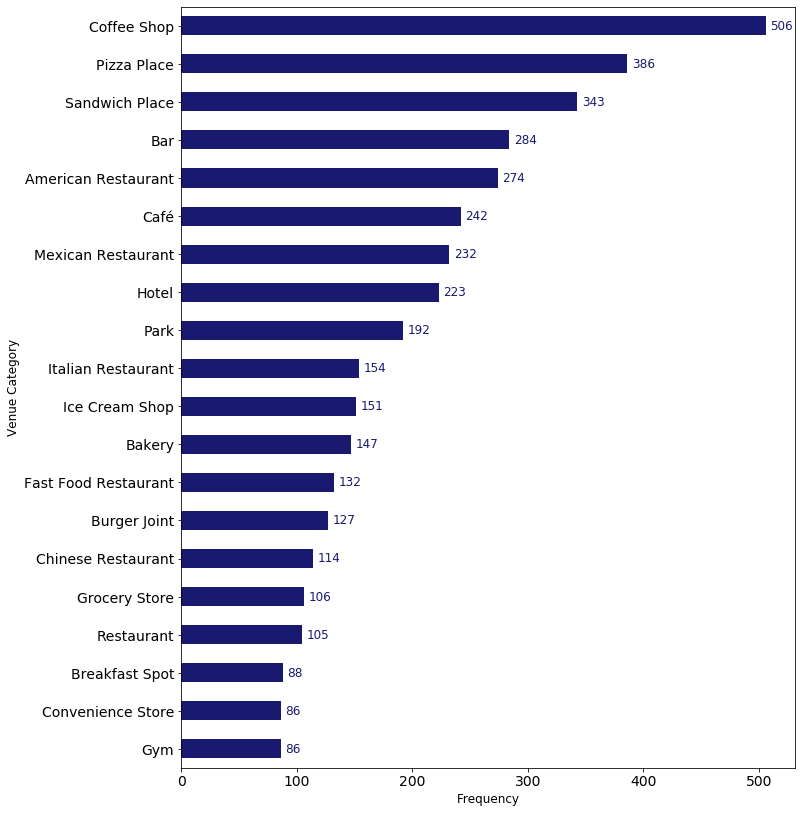

In [668]:
data = common_venues.set_index('Venue Category').head(20)['Frequency']
data = data[::-1]
color = 'midnightblue'
ax=data.plot(kind='barh', color=color, figsize=(11,14))
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Venue Category', fontsize=12)
plt.tick_params(labelsize=14)
#plt.title('The most common venues in the vicinity of US universities', fontsize=15)
# Annotate all bars:
for i in range(len(data)): # loop over all countries:
    plt.annotate(data[i], # text to display
    xy=(int(data[i]) + 4, i), # start the text at point (frequency + 10000 , index of the venue)
    va='center', # want the text to be vertically 'center' aligned
    ha='left', # want the text to be horizontally 'left' aligned
    fontsize=12,
    color=color
    )
plt.show()

## Clustering the universities?

In this part, we check if we could group the universities reasonably based on their venues.

K-means is a very popular clustering method, though choosing the right value of k is not always easy.

Naive approach: For several values of k, run k-means to cluster the universities into k clusters. 
Check the results to see if the resulting clusters can be characterized / interpreted reasonably. Otherwise, increase or decrease the number of clusters. 

I have started with 2 clusters, increased the number of clusters and observed how the clustering is changing:

- With 2 clusters, University of California in Merced, with only 4 venues (Lake, Food, Laundromat, Diner), occupies its own cluster; all other universities are grouped together.
- With 3 clusters, University of California in Merced still occupies its own cluster. Further, there are 2 big clusters without any obvious structure; for example, various pairs of universities don't share any common venues in their Top10; various pairs of universities in cluster 2 seem to only share a Coffee Shop in their Top10, but various universities in cluster 0 also have a Coffee Shop in their Top10.
- With 4 clusters, University of California in Merced keeps to occupy its own cluster. But now, University of California in Santa Cruz, another one having only 4 venues (Trail, Tree, Convenience Store, Farm) also gets its own cluster. It is not easy to characterize the two big clusters: Cluster 0 seems to be dominated by Coffee Shops and Sandwich Places (but both of them can be found in Top3 of many universities in Cluster 1, too); while in Cluster 1, it's mostly Bar and Pizza Place (and both of them can be found in Top3 of many universities in Cluster 0, too).
- With 5 clusters, the two Californian universities still keep their own clusters. Now we have another small cluster, composed of Texas A&M University and New Mexico Institute of Mining and Technology, both having Mexican Restaurant, Hotel and Convenience Store in their Top10. In the two big clusters, there are several universities having Mexican Restaurants as well as Hotel or Convenience Store in their Top10, but not all three of them. There is no obvious difference between the two clusters.
- With 6 clusters, the same two Californian universities still keep their own clusters. However, there are now four big clusters. All universities in Cluster 0 have Hotel in their Top10, combined with American Restaurant and/of Coffee Shop (however, there are also universities with this combination in other clusters). In Cluster 1, the combination Pizza Place + Bar + Coffee Shop or Sandwich Place seem to dominate. In Cluster 2, most of the universities have at least one of Sushi or Japanese or Mediterranean or Italian Restaurant or Ice Cream Place, but some pairs only share Hotel in their Top10. There is no obvious structure in Cluster 5, with many pairs of universities having completely different Top10 most common venues.
- When further increasing the number of clusters, the big clusters keep splitting but at least in some of them it is difficult to find any structure.

Conclusion: Using the naive approach, we were not able to find any reasonable clustering based on the most common venues of the universities.

Naive-approach K-Means clustering:

In [564]:
# set number of clusters
kclusters = 7

univ_grouped_clustering = univ_grouped.drop('Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(univ_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 4, 6, 6, 0, 6, 1, 6, 6, 0, 4, 4, 6, 1, 6, 6, 1, 6, 4, 6, 4, 6,
       4, 4, 6, 0, 6, 0, 0, 4, 6, 1, 5, 6, 6, 6, 4, 0, 0, 0, 1, 1, 0, 6,
       1, 0, 4, 6, 0, 1, 4, 0, 6, 0, 5, 4, 6, 1, 4, 0, 4, 1, 0, 6, 1, 1,
       0, 3, 0, 1, 0, 2, 1, 4, 1, 0, 0, 1, 0, 4, 1, 0, 6, 1, 1, 0, 1, 0,
       6, 1, 4, 4, 1, 4, 4, 1, 1, 4, 1, 6, 4, 1, 4, 1, 0, 4, 0, 6, 0, 1,
       4, 6, 4, 4, 0, 4, 4, 6, 1, 4, 6])

In [565]:
# add clustering labels as the first column:
# univ_venues_sorted.insert(univ_venues_sorted.shape[1], 'Cluster Labels', kmeans.labels_)    # this would insert the labels as the last column:
univ_venues_clustered = univ_venues_sorted.copy()
univ_venues_clustered.insert(1, 'Cluster Labels', kmeans.labels_)

In [566]:
univ_merged = univ_ll

# merge univ_grouped with univ_data to add latitude/longitude for each university
univ_merged = univ_merged.join(univ_venues_clustered.set_index('Name'), on='Name')

univ_merged.tail(10) # check the last column showing the cluster labels!

Rank                                               Name  \
111  401–500                             University of Kentucky   
112  401–500         University of Missouri, Columbia, Missouri   
113  401–500                    University of Missouri-St Louis   
114  401–500            University of Nebraska-Lincoln, Lincoln   
115  401–500  New Mexico Institute of Mining and Technology,...   
116  401–500                          Oklahoma State University   
117  401–500                   Rensselaer Polytechnic Institute   
118  401–500              University of South Carolina-Columbia   
119  401–500                 University of Texas at San Antonio   
120  401–500                                University of Tulsa   

     No. of FTE students  No. of students per staff  \
111                27078                       12.4   
112                28513                       13.3   
113                 7019                       16.0   
114                24610                       17.2   
115                 1809                       11.3   
116                21494                       15.8   
117                 7798                       15.6   
118                32291                       16.2   
119                24435                       24.5   
120                 5067                       12.4   

     International students ratio  Female Ratio  Overall  Teaching  Research  \
111                          0.04          0.55    40.55      37.0      24.9   
112                          0.06          0.53    40.55      34.9      24.2   
113                          0.06          0.58    40.55      30.0      24.7   
114                          0.11          0.48    40.55      30.1      28.0   
115                          0.08          0.30    40.55      22.3      14.6   
116                          0.07          0.50    40.55      24.1      21.5   
117                          0.20          0.32    40.55      30.0      28.7   
118                          0.05          0.55    40.55      33.2      25.5   
119                          0.04          0.51    40.55      18.1      21.1   
120                          0.16          0.45    40.55      33.5      16.2   

     Citations  ...  1st Most Common Venue  2nd Most Common Venue  \
111       55.5  ...            Coffee Shop           Burger Joint   
112       65.7  ...            Coffee Shop            Pizza Place   
113       70.3  ...                    Bar                  Hotel   
114       63.2  ...            Coffee Shop                    Bar   
115       70.6  ...     Mexican Restaurant                  Hotel   
116       71.1  ...         Sandwich Place   Fast Food Restaurant   
117       58.9  ...            Pizza Place                    Bar   
118       63.7  ...            Coffee Shop         Sandwich Place   
119       78.0  ...         Clothing Store         Cosmetics Shop   
120       68.9  ...         Sandwich Place     Mexican Restaurant   

     3rd Most Common Venue  4th Most Common Venue  5th Most Common Venue  \
111            Pizza Place                    Bar                   Park   
112                    Bar       Sushi Restaurant         Ice Cream Shop   
113            Coffee Shop           Hockey Arena         Scenic Lookout   
114                  Hotel         Sandwich Place                Brewery   
115      Convenience Store                  Motel          Big Box Store   
116                    Bar           Burger Joint         Cosmetics Shop   
117         Sandwich Place             Donut Shop      Convenience Store   
118    American Restaurant          Deli / Bodega                  Hotel   
119       Department Store         Sandwich Place   Fast Food Restaurant   
120    American Restaurant   Fast Food Restaurant            Pizza Place   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
111                 Hotel                   Pub        Farmers Market   
112               Theater         Grocer

In [567]:
univ_merged[np.isnan(univ_merged['Cluster Labels'])]

Empty DataFrame
Columns: [Rank, Name, No. of FTE students, No. of students per staff, International students ratio, Female Ratio, Overall, Teaching, Research, Citations, Industry Income, International Outlook, Latitude, Longitude, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []

[0 rows x 25 columns]

In [568]:
# now save the corrected data to a csv file:
#if save:
#    univ_merged.to_csv('Top_US_Universities_2020_Univ_Merged.csv', index=False)

In [569]:
#if save:
#    files.download('Top_US_Universities_2020_Univ_Merged.csv')

In [570]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_Univ_Merged.csv !!!

if load:
    #uploaded = files.upload()
    univ_merged = pd.read_csv('Top_US_Universities_2020_Univ_Merged.csv')
    univ_merged

In [571]:
# create map
map_clusters = folium.Map(location=[US_latitude, US_longitude], zoom_start=4)

# set color scheme for the clusters
#colors = ['mediumblue', 'gold', 'ivory', 'magenta', 'lawngreen', 'aqua', 'red', 'black']
colors = ['blue', 'beige', 'orange', 'purple', 'lightgreen', 'darkblue', 'black', 'red', 'darkgreen']
colors_l = ['skyblue', 'navajowhite', 'orange', 'mediumorchid', 'lightgreen', 'steelblue', 'black', 'crimson', 'darkgreen']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(univ_merged['Latitude'], univ_merged['Longitude'], univ_merged['Name'], univ_merged['Cluster Labels']) :
    label = folium.Popup('{} : Cluster {}'.format(poi, int(cluster)), parse_html=True)
    if (cluster == -1):    # originally non-clustered
      cluster = kclusters
    folium.Marker([lat,lon], popup=label, icon=folium.Icon(color=colors[int(cluster)], prefix='fa', icon='circle')).add_to(map_clusters)
    
legend_html = '''
     <div style = "position: fixed; top: 80px; left: 20px; width: 110px; height: 260px; border:2px solid grey; z-index:9999; font-size:14px; ">
     &nbsp; Legend: 
     <br>&nbsp; Cluster   0 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:skyblue"></i>
     <br>&nbsp; Cluster   1 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:navajowhite"></i>
     <br>&nbsp; Cluster   2 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:orange"></i>
     <br>&nbsp; Cluster   3 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:mediumorchid"></i>
     <br>&nbsp; Cluster   4 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:lightgreen"></i>
     <br>&nbsp; Cluster   5 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:steelblue"></i>
     <br>&nbsp; Cluster   6 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:black"></i>
     <br>&nbsp; Cluster   7 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:crimson"></i>
     <!-- <br>&nbsp; Cluster   8 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:darkgreen"></i> -->
      </div>
     '''
map_clusters.get_root().html.add_child(folium.Element(legend_html))
       
map_clusters

## Examine clusters

<div style = "font-size:20px; ">
     &nbsp; Cluster   0: &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:skyblue"></i>
</div>

In [572]:
univ_merged.loc[univ_merged['Cluster Labels'] == 0, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                                               Name  \
11        17              University of California, Los Angeles   
28       =57            University of California, Santa Barbara   
30       =62                  University of Southern California   
31        70                    Ohio State University, Columbus   
32        78                              Penn State University   
37       =91               University of Maryland, College Park   
41       104                              University of Arizona   
48      =134                                 Indiana University   
52      =168        Rutgers, the State University of New Jersey   
56      =175                 University of Florida, Gainesville   
60   201–250                                Brandeis University   
68   201–250  Virginia Polytechnic Institute and State Unive...   
72   251–300                University of California, Riverside   
74   251–300                             University of Delaware   
85   301–350                       Nova Southeastern University   
87   301–350                             Stony Brook University   
88   301–350                                  Temple University   
90   301–350                      University of Texas at Dallas   
94   351–400                                   Clark University   
95   351–400                          University of Connecticut   
97   351–400                                 Hofstra University   
98   351–400                              Iowa State University   
103  401–500                              University of Alabama   
109  401–500         University of Houston, Calhoun Rd, Houston   
110  401–500                               University of Kansas   
116  401–500                          Oklahoma State University   
117  401–500                   Rensselaer Polytechnic Institute   
120  401–500                                University of Tulsa   

     No. of FTE students  No. of students per staff  \
11                 41066                        9.4   
28                 24089                       27.6   
30                 36929                       11.7   
31                 54372                       12.5   
32                 46204                       15.3   
37                 33108                       16.6   
41                 39124                       18.4   
48                 66872                       13.6   
52                 44801                       11.2   
56                 46642                       16.8   
60                  5375                       12.2   
68                 32838                       18.3   
72                 22272                       18.0   
74                 20566                       17.0   
85                 17785                       23.4   
87                 24201                       10.5   
88                 35814                       13.0   
90                 22757                       21.6   
94                  3045                       11.5   
95                 32446                       15.2   
97                 10066                       13.9   
98                 32469                       18.8   
103                35120                       22.5   
109                44128                       25.7   
110                24526                        9.9   
116                21494                       15.8   
117                 7798                       15.6   
120                 5067                       12.4   

     International students ratio  Female Ratio  Overall  Cluster Labels  \
11                           0.17          0.54    86.80               0   
28                           0.16          0.52    69.60               0   
30                           0.25          0.53    68.10               0   
31                           0.13          0.50    66.10               0   
32                           0.16          0.46    64.20               0   
37          

<div style = "font-size:20px; ">
     &nbsp; Cluster   1 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:navajowhite"></i>
</div>

In [573]:
univ_merged.loc[univ_merged['Cluster Labels'] == 1, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                                         Name  \
0          2           California Institute of Technology   
1          4                          Stanford University   
6          9                        University of Chicago   
12        19                           Cornell University   
13        20                              Duke University   
19        31          University of California, San Diego   
22       =48   University of Illinois at Urbana-Champaign   
26        54  University of North Carolina at Chapel Hill   
27       =55              University of California, Davis   
35        84                    Michigan State University   
36        88             Purdue University West Lafayette   
39       =96             University of California, Irvine   
47       124               University of Colorado Boulder   
55      =173                      University of Rochester   
61   201–250               University of Hawai’i at Mānoa   
63   201–250                           University of Iowa   
65   201–250                          University of Miami   
66   201–250          University of South Florida (Tampa)   
67   201–250                           University of Utah   
78   251–300                         University of Oregon   
79   251–300         Oregon Health and Science University   
83   301–350       University of New Mexico (Main campus)   
91   301–350                            Tulane University   
92   351–400               University of Alaska Fairbanks   
96   351–400                         University of Denver   
99   351–400                      Oregon State University   
102  351–400                       Wayne State University   
104  401–500                          American University   
111  401–500                       University of Kentucky   
112  401–500   University of Missouri, Columbia, Missouri   

     No. of FTE students  No. of students per staff  \
0                   2240                        6.4   
1                  16135                        7.3   
6                  13833                        5.7   
12                 22319                        9.8   
13                 15309                        4.3   
19                 33579                       13.0   
22                 44916                       17.9   
26                 35419                        9.4   
27                 39164                       12.0   
35                 44789                       16.5   
36                 40451                       15.7   
39                 32706                       16.5   
47                 33186                       16.3   
55                  9824                        4.2   
61                 15054                       10.8   
63                 28945                       11.6   
65                 15971                        6.3   
66                 33885                       18.9   
67                 30365                       14.2   
78                 22143                       10.8   
79                  2895                        1.0   
83                 19382                       17.1   
91                 11185                        9.8   
92                  3593                        8.7   
96                  9535                       13.0   
99                 24798                       16.0   
102                22295                       11.3   
104                11750                       11.0   
111                27078                       12.4   
112                28513                       13.3   

     International students ratio  Female Ratio  Overall  Cluster Labels  \
0                            0.30          0.34    94.50               1   
1                            0.23          0.43    94.30               1   
6                            0.28          0.46    90.20               1   
12                           0.25          0.49    85.10               1   
13                           0

<div style = "font-size:20px; ">
     &nbsp; Cluster   2 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:orange"></i>
</div>

In [574]:
univ_merged.loc[univ_merged['Cluster Labels'] == 2, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                                  Name  No. of FTE students  \
58  =179  University of California, Santa Cruz                18783   

    No. of students per staff  International students ratio  Female Ratio  \
58                       23.0                           0.1           0.5   

    Overall  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
58     55.2               2                 Trail                  Tree   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
58     Convenience Store                  Farm                   NaN   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
58                   NaN                   NaN                   NaN   

   9th Most Common Venue 10th Most Common Venue  
58                   NaN                    NaN

<div style = "font-size:20px; ">
     &nbsp; Cluster   3 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:mediumorchid"></i>
</div>

In [575]:
univ_merged.loc[univ_merged['Cluster Labels'] == 3, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                              Name  No. of FTE students  \
93  351–400  University of California, Merced                 7324   

    No. of students per staff  International students ratio  Female Ratio  \
93                       20.9                          0.08          0.51   

    Overall  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
93     43.4               3                  Lake                  Food   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
93            Laundromat                 Diner                   NaN   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
93                   NaN                   NaN                   NaN   

   9th Most Common Venue 10th Most Common Venue  
93                   NaN                    NaN

<div style = "font-size:20px; ">
     &nbsp; Cluster   4 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:lightgreen"></i>
</div>

In [576]:
univ_merged.loc[univ_merged['Cluster Labels'] == 4, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                                        Name  No. of FTE students  \
8         12                    Johns Hopkins University                16171   
14        21            University of Michigan-Ann Arbor                42982   
15        22                     Northwestern University                17951   
20       =38             Georgia Institute of Technology                21372   
21       =38               University of Texas at Austin                49165   
23        51             University of Wisconsin-Madison                39154   
33        79                     University of Minnesota                61120   
42      =105                             Rice University                 6667   
43      =107        University of Virginia (Main campus)                23116   
44      =113  University of Pittsburgh-Pittsburgh campus                26652   
45       116                       Vanderbilt University                12006   
50      =155            Arizona State University (Tempe)                46683   
51      =157                    University of Notre Dame                12104   
53       172         University of Alabama at Birmingham                16927   
59      =198                George Washington University                23488   
69   201–250                      Wake Forest University                 7675   
70   201–250                              William & Mary                 8235   
71   251–300                       University at Buffalo                25849   
73   251–300                    University of Cincinnati                28434   
75   251–300                    Florida State University                38520   
82   301–350                    Colorado School of Mines                 5768   
89   301–350       The University of Tennessee-Knoxville                25907   
100  351–400         State University of New York Albany                15947   
101  351–400                 Washington State University                27957   
105  401–500     Colorado State University, Fort Collins                26014   
107  401–500                       University of Georgia                35164   
108  401–500                    Georgia State University                29290   
113  401–500             University of Missouri-St Louis                 7019   
114  401–500     University of Nebraska-Lincoln, Lincoln                24610   
118  401–500       University of South Carolina-Columbia                32291   

     No. of students per staff  International students ratio  Female Ratio  \
8                          4.5                          0.26          0.52   
14                         8.3                          0.17          0.49   
15                        12.8                          0.20          0.49   
20                        18.3                          0.27          0.33   
21                        17.2                          0.10          0.52   
23                        10.0                          0.13           NaN   
33                        12.4                          0.11          0.52   
42                         8.9                          0.28          0.42   
43                         8.6                          0.12          0.52   
44                         5.8                          0.11          0.51   
45                         3.0                          0.14          0.54   
50                        21.1                          0.21          0.43   
51                        13.7                          0.12          0.45   
53                        16.7                          0.06          0.62   
59                        13.1                          0.18          0.60   
69                         4.0                          0.09          0.53   
70                        11.4                          0.09          0.55   
71                        17.4                          0.17          0.44   
73            

<div style = "font-size:20px; ">
     &nbsp; Cluster   5 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:steelblue"></i>
</div>

In [577]:
univ_merged.loc[univ_merged['Cluster Labels'] == 5, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                                               Name  \
57       178                               Texas A&M University   
115  401–500  New Mexico Institute of Mining and Technology,...   

     No. of FTE students  No. of students per staff  \
57                 60818                       24.8   
115                 1809                       11.3   

     International students ratio  Female Ratio  Overall  Cluster Labels  \
57                           0.08          0.47    55.30               5   
115                          0.08          0.30    40.55               5   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
57     Mexican Restaurant  Fast Food Restaurant                   Bar   
115    Mexican Restaurant                 Hotel     Convenience Store   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
57                  Hotel              Pharmacy     Convenience Store   
115                 Motel         Big Box Store        Sandwich Place   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
57           Home Service          Burger Joint         Historic Site   
115        Hardware Store                Lounge                   Bar   

    10th Most Common Venue  
57                    Park  
115   Fast Food Restaurant

<div style = "font-size:20px; ">
     &nbsp; Cluster   6 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:black"></i>
</div>

In [578]:
univ_merged.loc[univ_merged['Cluster Labels'] == 6, univ_merged.columns[list(range(7)) + list(range(univ_merged.shape[1]-11, univ_merged.shape[1]))]]

Rank                                   Name  No. of FTE students  \
2          5  Massachusetts Institute of Technology                11247   
3          6                   Princeton University                 7983   
4          7                     Harvard University                20823   
5          8                        Yale University                12402   
7         11             University of Pennsylvania                20578   
9        =13     University of California, Berkeley                41081   
10        16                    Columbia University                26586   
16        26               University of Washington                45692   
17       =27             Carnegie Mellon University                13430   
18        29                    New York University                44466   
24        52      Washington University in St Louis                13401   
25        53                       Brown University                 9391   
29        61                      Boston University                25662   
34       =80                       Emory University                12735   
38       =94                      Dartmouth College                 6247   
40      =102                  Georgetown University                16279   
46       119        Case Western Reserve University                10654   
49      =139                       Tufts University                11017   
54      =173                Northeastern University                19575   
62   201–250                      Howard University                 8449   
64   201–250            University of Massachusetts                61204   
76   251–300                George Mason University                29377   
77   251–300      University of Illinois at Chicago                27031   
80   251–300                    Syracuse University                20236   
81   301–350                         Boston College                12904   
84   301–350        North Carolina State University                30231   
86   301–350                        Rush University                 2425   
106  401–500                      Drexel University                19801   
119  401–500     University of Texas at San Antonio                24435   

     No. of students per staff  International students ratio  Female Ratio  \
2                          8.6                          0.34          0.39   
3                          8.1                          0.25          0.45   
4                          9.2                          0.24          0.49   
5                          5.4                          0.20          0.50   
7                          6.5                          0.21          0.52   
9                         13.7                          0.17          0.50   
10                         5.8                          0.37           NaN   
16                        11.1                          0.16          0.53   
17                        13.6                          0.48          0.41   
18                         8.9                          0.33          0.57   
24                         7.5                          0.20           NaN   
25                        10.8                          0.20           NaN   
29                        11.6                          0.27          0.60   
34                         4.0                          0.20          0.58   
38                         7.7                          0.15          0.49   
40                         8.5                          0.18          0.54   
46                         8.8                          0.23          0.50   
49                         9.8                          0.16          0.55   
54                        13.9                          0.35          0.49   
62                         7.5                          0.08          0.65   
64                        13.0                          0.15          0.48   
76         

## Finding the best value of k for k-means clustering?

Reference for [choosing the optimal value of k in k-means](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In the previous part, we have chosen the value of k for the k-means clustering 'manually' based on experimenting with k, trying to find a value giving the results that could be interpreted reasonably. Several outliers were identified (mostly universities with just a few venues, lacking the usual venues such as Coffee Shop or Café, Pizza Place, Sandwich Place or American Restaurant) but except of that, we have not found any obvious structure.

Therefore, in the following part, we try to apply some visual as well as automated methods to find an optimal value of k. However, the results are not better; the venues of the universities are too diverse and don't show any similarity.

D:\lenka-hp\soft\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (119) found smaller than n_clusters (120). Possibly due to duplicate points in X.
  return_n_iter=True)


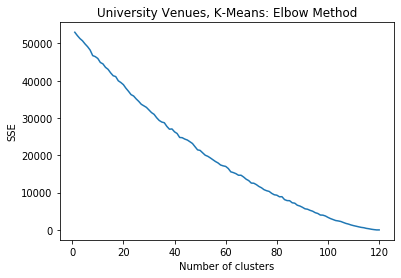

In [476]:
X = univ_grouped_count.drop('Name',1)
X = np.nan_to_num(X)
Xscaled = StandardScaler().fit_transform(X)

maxK = Xscaled.shape[0]    # equal to the number of universities we have at this moment

kmeans = [KMeans(n_clusters=i, max_iter=1000) for i in range(1,maxK)]
sse = [km.fit(Xscaled).inertia_ for km in kmeans]

plt.figure()
plt.plot(range(1,maxK), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("University Venues, K-Means: Elbow Method")
plt.show()

In [477]:
print('nr.clusters | SSE')
print('----------------------------')
for i in range(115,maxK):
    print('{:11d} | {:14.10f}'.format(i,sse[i-1]))

nr.clusters | SSE
----------------------------
        115 | 416.0499036457
        116 | 311.7452791210
        117 | 177.1687266637
        118 |  78.8774722265
        119 |   0.0000000000
        120 |   0.0000000000


In the plot, there is no elbow. We can see that KMeans suggests clustering into 119 clusters because with this number, SSE drop to zero for the first time. 

Let's check the silhouette score. It often gives a better idea concerning the optimal value of k than the elbow method.

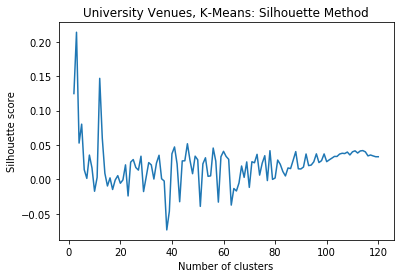

In [167]:
silhouette_score = [metrics.silhouette_score(Xscaled, km.labels_, metric='euclidean') for km in kmeans[1:]]

plt.figure()
plt.plot(range(2,maxK), silhouette_score)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("University Venues, K-Means: Silhouette Method")
plt.show()

In [168]:
print('nr.clusters | Silhouette score')
print('------------------------------')
for i in range(2,11):
    print('{:11d} | {: 13.10f}'.format(i,silhouette_score[i-2]))

nr.clusters | Silhouette score
------------------------------
          2 |  0.1247632069
          3 |  0.2138023946
          4 |  0.0528845833
          5 |  0.0803430069
          6 |  0.0142490426
          7 |  0.0016407662
          8 |  0.0354580224
          9 |  0.0168541760
         10 | -0.0170814385


[Silhouette score:](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)
> - The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
> - The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

[Silhouette analysis:](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)
>The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

We can see that the silhouette analysis also suggests that there is no clustering in the data. This is probably due to high dimensionality of the data.

DBSCAN also could not find any clusters:

In [169]:
>>> from sklearn.cluster import DBSCAN

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Xscaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xscaled, labels))

Estimated number of clusters: 0
Estimated number of noise points: 121


Let's try another clustering method, the [AffinityPropagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation).

Affinity Propagation also suggest clustering into 119 clusters meaning that there is no structure found in the data.

Estimated number of clusters: 119
Silhouette Coefficient: 0.033


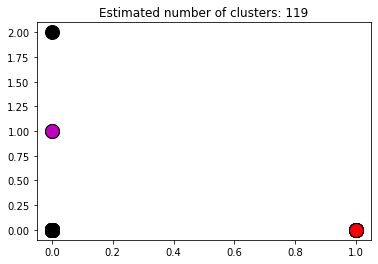

In [170]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

X = univ_grouped_count.drop('Name',1) #df.values[:,1:]
X = np.nan_to_num(X)
Xscaled = StandardScaler().fit_transform(X)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(Xscaled)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xscaled, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Unfortunately, the dimensionality reduction by PCA does not get us any better results. We can see a drop in the explained variance only after 118. Therefore, it is not surprising that DBSCAN applied to the PCA-reduced data does not give any better answer.

[1.33888894e+01 1.09470688e+01 1.04367647e+01 9.67122804e+00
 9.37189329e+00 9.09903887e+00 8.76182602e+00 8.47012277e+00
 8.28321577e+00 8.11507463e+00 7.85449641e+00 7.69807203e+00
 7.58189941e+00 7.44332429e+00 7.13800613e+00 7.08147394e+00
 6.89615908e+00 6.60898207e+00 6.43945840e+00 6.17854279e+00
 6.13036330e+00 5.92509935e+00 5.89126121e+00 5.73515045e+00
 5.68183149e+00 5.56771260e+00 5.54693516e+00 5.30857971e+00
 5.23481844e+00 5.11164763e+00 5.09468130e+00 4.98671530e+00
 4.84546435e+00 4.82753587e+00 4.62852953e+00 4.60510928e+00
 4.53838181e+00 4.52385940e+00 4.35148818e+00 4.28779477e+00
 4.25529505e+00 4.18431953e+00 4.17557296e+00 4.07258953e+00
 3.99296187e+00 3.93004331e+00 3.84296584e+00 3.79923692e+00
 3.73223599e+00 3.58465214e+00 3.57028729e+00 3.50385615e+00
 3.48470871e+00 3.44910330e+00 3.27087684e+00 3.24179920e+00
 3.22608848e+00 3.16792565e+00 3.11755450e+00 3.09599165e+00
 2.98748864e+00 2.95590374e+00 2.90964650e+00 2.85074811e+00
 2.79973502e+00 2.752393

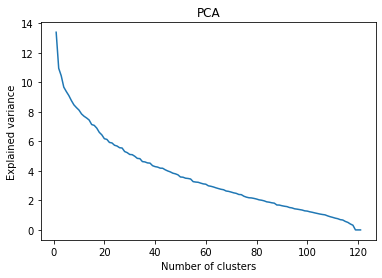

In [171]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(Xscaled)
print(pca.explained_variance_)  

plt.plot(range(1,122),pca.explained_variance_)
plt.xlabel("Number of clusters")
plt.ylabel("Explained variance")
plt.title('PCA')

pca.n_components
X_reduced = pca.fit_transform(Xscaled)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X_reduced)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

## Next, let's try to cluster the universities based on their scores.

In [172]:
univ_ll.head(2)

Rank                                Name  No. of FTE students  \
0    2  California Institute of Technology                 2240   
1    4                 Stanford University                16135   

   No. of students per staff  International students ratio  Female Ratio  \
0                        6.4                          0.30          0.34   
1                        7.3                          0.23          0.43   

   Overall  Teaching  Research  Citations  Industry Income  \
0     94.5      92.1      97.2       97.9             88.0   
1     94.3      92.8      96.4       99.9             66.2   

   International Outlook  Latitude  Longitude  
0                   82.5  34.13590 -118.12653  
1                   79.5  37.42907 -122.16978

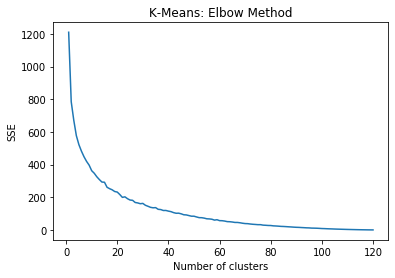

In [173]:
X = univ_ll.drop(columns = ['Rank','Name','Latitude','Longitude'])
X = np.nan_to_num(X)
Xscaled = StandardScaler().fit_transform(X)

maxK = Xscaled.shape[0]    # equal to the number of universities we have at this moment

kmeans = [KMeans(n_clusters=i, max_iter=1000) for i in range(1,maxK)]
sse = [km.fit(Xscaled).inertia_ for km in kmeans]

plt.figure()
plt.plot(range(1,maxK), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("K-Means: Elbow Method")
plt.show()

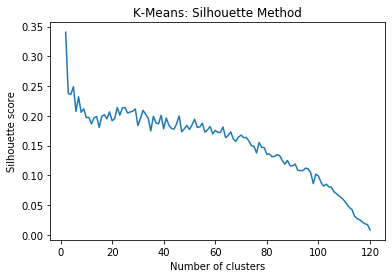

In [174]:
silhouette_score = [metrics.silhouette_score(Xscaled, km.labels_, metric='euclidean') for km in kmeans[1:]]

plt.figure()
plt.plot(range(2,maxK), silhouette_score)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("K-Means: Silhouette Method")
plt.show()

In [441]:
print('nr.clusters | Silhouette score')
print('------------------------------')
for i in range(2,11):
    print('{:11d} | {: 13.10f}'.format(i,silhouette_score[i-2]))

nr.clusters | Silhouette score
------------------------------
          2 |  0.3404724247
          3 |  0.2373229891
          4 |  0.2360976786
          5 |  0.2488301160
          6 |  0.2074746425
          7 |  0.2318983430
          8 |  0.2057609889
          9 |  0.2116477737
         10 |  0.1969028872


### Neither the clustering of the universities on the venues close by, nor the clustering based on their scores has revealed too much structure. 

### In the following parts, we will concentrate on the wishes of the rest of the family to identify the most suitable location.

### To conclude what we have learnt so far, let's visualize both the universities and the national parks, this time with corrected geographical coordinates of the universities:

In [442]:
# create a map of US using latitude and longitude values:
map_US = folium.Map(location=[US_latitude, US_longitude], zoom_start=3)

################################################
# VISUALIZING THE NATIONAL PARKS:
# define the color map to visualize a ratio:
key = 'Crowded'
vmin = 0
vmax = 5
colormap = branca.colormap.LinearColormap(colors=['green','red'],
                             index=[vmin,vmax],
                             vmin=vmin, 
                             vmax=vmax)
colormap = colormap.to_step(index=[0, 1, 2, 3, 4, 5])
colormap.caption = 'Visitor density (log10(number of visitors per year per km2))'
#colormap = colormap.to_step(index=[1, 10, 100, 1000, 10000, 100000],method='log') # logarithmic scale seems not to be working well
#colormap.caption = 'Visitor density (number of visitors per year per km2)'
#colormap.add_to(map_US)

# add markers to map
group0 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">national parks</span>')
for lat, lng, name, area, crowd in zip(parks['Latitude'], 
                                        parks['Longitude'], 
                                        parks['Name'], 
                                        parks['Area in km2'], 
                                        parks[key]):
    c = colormap(math.log10(crowd))
    #a = math.log10(area)+4
    a = 2*math.log10(area)+1
    label = '{}: \narea = {} km2, {} visitors per km2'.format(name, area, int(crowd))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=a,
        popup=label,
        key_on=parks[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.3,
        parse_html=False).add_to(group0)  
group0.add_to(map_US)

################################################
# VISUALIZING THE UNIVERSITIES:
# define the color map to visualize a ratio:
key = 'International students ratio'
vmin_u = 0.10 #univ_ll[key].min()
vmax_u = 0.40 #univ_ll[key].max()
colormap_u = branca.colormap.LinearColormap(colors=['darkblue','gold'],
                             index=[vmin_u,vmax_u],
                             vmin=vmin_u, 
                             vmax=vmax_u)
#colormap = branca.colormap.linear.YlOrRd_09.scale(0, 8500)
#colormap = colormap.to_step(index=[0, 1000, 3000, 5000, 8500])
colormap_u.caption = 'Ratio of International Students'
#colormap_u.add_to(map_US)

# add markers to map
group1 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">universities</span>')
for lat, lng, rank, univ, Nstudents, ratio in zip(univ_ll['Latitude'], 
                                        univ_ll['Longitude'], 
                                        univ_ll['Rank'],
                                        univ_ll['Name'], 
                                        univ_ll['No. of FTE students'], 
                                        univ_ll[key]):
    if (np.isnan(ratio)):
        c = 'black'
    else:
        c = colormap_u(ratio)
    label = '{}. {}: {} students, {}\% internationals'.format(rank, univ, Nstudents, int(ratio*100))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(math.sqrt(int(Nstudents))//20),
        popup=label,
        key_on=univ_ll[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,
        parse_html=False).add_to(group1)  
group1.add_to(map_US)

############################################
# SHOWING BOTH COLORMAPS AND THE LAYER CONTROL:
# add the colormap showing ratio of the international students:
map_US.add_child(colormap_u)    
# add the colormap showing visitor density of the national parks:
map_US.add_child(colormap)
# add the layer control:
folium.map.LayerControl('topright', collapsed=False).add_to(map_US)

map_US.save('map_parks_and_universities.html')

map_US

---

## Retrieving all data after, e.g., a kernel restart (to save unnecessary Foursquare queries)

In [179]:
# getting back the data generated so far, after a kernel restart etc, to spare Foursquare queries:
# upload 'Top_US_Universities_2020_National_Parks.csv' !!!

if load:
    #uploaded = files.upload()
    parks = pd.read_csv('Top_US_Universities_2020_National_Parks.csv')
    parks

In [180]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_LatLng_corrected.csv !!!

if load:
    #uploaded = files.upload()
    univ_ll = pd.read_csv('Top_US_Universities_2020_LatLng_corrected.csv')
    univ_ll

In [181]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_Venues_corrected.csv !!!

if load:
    #uploaded = files.upload()
    univ_venues = pd.read_csv('Top_US_Universities_2020_Venues_corrected.csv')
    univ_venues

---

# Part C: From a university to a national park: the distances

In this part, we will retrieve the distances (in km) between the universities and the national parks. For each university, we will find the minimal distance to a national park and the name of the closest national park.  
Doing so, we will only consider those national parks that are not over-crowded. To define what we mean by over-crowded, we will first check the descriptive statistics of the national parks.  

Reference: [Python | Calculate Distance between two places using Geopy](https://www.geeksforgeeks.org/python-calculate-distance-between-two-places-using-geopy/)

Let's recall the number of universities and the number of parks we have so far:

In [443]:
univ_ll.shape[0]

121

In [444]:
parks.shape[0]

61

### Let's recall the descriptive statistics of the national parks:

In [184]:
parks[['Area in km2','Visitors per year','Crowded']].describe()

Area in km2  Visitors per year       Crowded
count     61.000000       6.100000e+01     61.000000
mean    3476.854098       1.384678e+06   3749.629508
std     6686.383097       1.911755e+06   9686.138333
min       22.500000       9.591000e+03      0.310000
25%      261.800000       3.089620e+05    362.660000
50%      895.900000       6.449220e+05    971.890000
75%     3082.700000       1.663557e+06   2479.630000
max    33682.600000       1.142120e+07  66972.760000

We have seen that there are quite big differences between the parks concerning their area, number of visitors per year as well as visitor density.  
Which parks are the least and the most crowded?

In [185]:
parks[parks['Crowded'] == parks['Crowded'].min()]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
19  Gates of the Arctic      30448.1               9591     67.78     -153.3   

     State  Crowded  Cluster Labels K-Means  \
19  Alaska     0.31                       4   

    Cluster Labels Affinity Propagation  
19                                    2

In [186]:
parks[parks['Crowded'] == parks['Crowded'].max()]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
30  Hot Springs         22.5            1506887     34.51     -93.05   

       State   Crowded  Cluster Labels K-Means  \
30  Arkansas  66972.76                       2   

    Cluster Labels Affinity Propagation  
30                                    5

67 thousands visitors per year per km^2: that is definitely too much, according to Kayleigh! She wants to limit this number to max. 10 thousands. The table above shows that the third quartile of the visitor density is about 2500. Hence, visitor density <= 10000 is not overly limiting. The following parks will be left out:

In [187]:
parks[parks['Crowded'] > 10000]

Name  Area in km2  Visitors per year  Latitude  Longitude  \
0            Acadia        198.6            3537575   44.3500   -68.2100   
7      Bryce Canyon        145.0            2679478   37.5700  -112.1800   
14  Cuyahoga Valley        131.8            2096053   41.2400   -81.5500   
30      Hot Springs         22.5            1506887   34.5100   -93.0500   
31    Indiana Dunes         62.1            1756079   41.6533   -87.0524   

       State   Crowded  Cluster Labels K-Means  \
0      Maine  17812.56                       6   
7       Utah  18479.16                       6   
14      Ohio  15903.29                       6   
30  Arkansas  66972.76                       2   
31   Indiana  28278.24                       6   

    Cluster Labels Affinity Propagation  
0                                     0  
7                                     0  
14                                    0  
30                                    5  
31                                    0

For a moment, we were in doubts. Are we not too strict setting the limit to 10000? What about Acadia, for example? It is so beautiful!

![Acadia](https://cdn.pixabay.com/photo/2013/02/10/22/21/acadia-national-park-80357_960_720.jpg)

But then, we have read about [Traffic and Congestion](https://www.nps.gov/acad/traffic.htm) on the website of the NPS:
> Acadia National Park is among the top ten most popular national parks in the United States, welcoming more than 3.5 million people a year. Visitation has surged almost 60 percent in a decade, leading to severe crowding at most park attractions. Between June 28 and Sept 4, 2017, the road to the Cadillac Mountain summit closed 49 times – for as little as 13 minutes, or as long as 90 minutes – due to gridlock congestion and public safety concerns.  
[![Acadia Traffic Congestion](https://www.nps.gov/acad/images/Traffic_2.jpg?maxwidth=650&autorotate=false)](https://www.nps.gov/acad/images/Traffic_2.jpg?maxwidth=650&autorotate=false)

No, that's not good. But again, photographing sunrise and sunset is, of course, absolutely gorgeous and the number of visitors in very early and very late times of the day should be limited, shouldn't it? But the article says very explicitely:

> Avoid Cadillac Mountain crowds at sunrise and sunset...

While you may be ready to sacrifice your time and nerves as a tourist having once-in-a-lifetime opportunity to see the national park, Kayleigh does not want to spend hours in traffic congestions every week while -ironically- seeking for nature and tranquility together with her clients. Luckily, there are many more national parks!

In [188]:
parks_red = parks[parks['Crowded'] <= 10000].reset_index(drop=True)
parks_red

Name  Area in km2  Visitors per year  Latitude  \
0                 American Samoa         33.4              28626    -14.25   
1                         Arches        310.3            1663557     38.68   
2                       Badlands        982.4            1008942     43.75   
3                       Big Bend       3242.2             440091     29.25   
4                       Biscayne        700.0             469253     25.65   
5   Black Canyon of the Gunnison        124.6             308962     38.57   
6                    Canyonlands       1366.2             739449     38.20   
7                   Capitol Reef        979.0            1227627     38.20   
8             Carlsbad Caverns *        189.3             465912     32.17   
9                Channel Islands       1009.9             366250     34.01   
10                      Congaree        107.1             145929     33.78   
11                   Crater Lake        741.5             720659     42.94   
12                  Death Valley      13793.3            1678660     36.24   
13                        Denali      19185.8             594660     63.33   
14                  Dry Tortugas        261.8              56810     24.63   
15                    Everglades       6106.5             597124     25.32   
16           Gates of the Arctic      30448.1               9591     67.78   
17                       Glacier       4100.0            2965309     48.80   
18                   Glacier Bay      13044.6             597915     58.50   
19                Grand Canyon *       4862.9            6380495     36.06   
20                   Grand Teton       1254.7            3491151     43.73   
21                   Great Basin        312.3             153094     38.98   
22              Great Sand Dunes        434.4             442905     37.73   
23         Great Smoky Mountains       2114.2           11421200     35.68   
24           Guadalupe Mountains        349.5             172347     31.92   
25                     Haleakalā        134.6            1044084     20.72   
26             Hawaiʻi Volcanoes       1317.7            1116891     19.38   
27                   Isle Royale       2314.0              25798     48.10   
28                   Joshua Tree       3217.9            2942382     33.79   
29                        Katmai      14870.3              37818     58.50   
30                  Kenai Fjords       2710.0             321596     59.92   
31                  Kings Canyon       1869.2             699023     36.80   
32                  Kobuk Valley       7084.9              14937     67.55   
33                    Lake Clark      10602.0              14479     60.97   
34               Lassen Volcanic        431.4             499435     40.49   
35                  Mammoth Cave        218.6             533206     37.18   
36                  Mesa Verde *        212.4             563420     37.18   
37                 Mount Rainier        956.6            1518491     46.85   
38                North Cascades       2042.8              30085     48.70   
39                       Olympic       3733.8            3104455     47.97   
40              Petrified Forest        895.9             644922     35.07   
41                     Pinnacles        108.0             222152     36.48   
42                     Redwood *        562.5             482536     41.30   
43                Rocky Mountain       1075.7            4590493     40.40   
44                       Saguaro        371.2             957405     32.25   
45                       Sequoia       1635.2            1229594     36.43   
46                    Shenandoah        806.2            1264880     38.53   
47            Theodore Roosevelt        285.1             749389     46.97   
48                Virgin Islands         60.9             112287     18.33   
49                     Voyageurs        883.1             239656     48.50   
50                   White Sands        592.2     

In [189]:
dist = []
for u in range(univ_ll.shape[0]):    # index of the university
  distr = []
  for p in range(parks_red.shape[0]):
    d = round(geodesic((univ_ll.loc[u,'Latitude'],univ_ll.loc[u,'Longitude']),(parks_red.loc[p,'Latitude'],parks_red.loc[p,'Longitude'])).km)
    distr.append(d)
  dist.append(distr)

In [190]:
num_top_parks = 3
top_parks = []

distances = pd.DataFrame(dist,columns=parks_red['Name'])
distances['University'] = univ_ll['Name']
distances.set_index('University',inplace=True)

for univ in distances.index:
    # take only the row belonging to this university & transpose it:
    temp = distances[distances.index == univ].T.reset_index() 
    temp.columns = ['park','dist']
    temp['dist'] = temp['dist'].astype(int)
    aux = temp.sort_values('dist', ascending=True).reset_index(drop=True).head(num_top_parks)
    auxtop = [univ]
    for i in range(num_top_parks):
        auxtop.append(aux.loc[i,'park'])
        auxtop.append(aux.loc[i,'dist'])
    #print(aux)
    top_parks.append(auxtop)
aux = pd.DataFrame(top_parks,columns=['University','Closest NP','Min Distance to NP','Closest NP 2','Distance to NP 2','Closest NP 3','Distance to NP 3']).set_index('University')

distances = pd.concat([distances,aux],axis=1)
distances

American Samoa  Arches  Badlands  \
University                                                                
California Institute of Technology               7720     918      1720   
Stanford University                              7644    1114      1801   
Massachusetts Institute of Technology           11848    3258      2548   
Princeton University                            11529    2988      2324   
Harvard University                              11845    3255      2545   
...                                               ...     ...       ...   
Oklahoma State University                        9518    1141       965   
Rensselaer Polytechnic Institute                11640    3043      2332   
University of South Carolina-Columbia           10854    2603      2145   
University of Texas at San Antonio               9121    1426      1609   
University of Tulsa                              9614    1237      1012   

                                       Big Bend  Biscayne  \
University                                                  
California Institute of Technology         1509      3770   
Stanford University                        1976      4166   
Massachusetts Institute of Technology      3224      2028   
Princeton University                       2874      1706   
Harvard University                         3222      2028   
...                                         ...       ...   
Oklahoma State University                   957      1992   
Rensselaer Polytechnic Institute           3035      1983   
University of South Carolina-Columbia      2168       930   
University of Texas at San Antonio          451      1879   
University of Tulsa                        1027      1908   

                                       Black Canyon of the Gunnison  \
University                                                            
California Institute of Technology                             1055   
Stanford University                                            1274   
Massachusetts Institute of Technology                          3110   
Princeton University                                           2836   
Harvard University                                             3108   
...                                                             ...   
Oklahoma State University                                       981   
Rensselaer Polytechnic Institute                               2896   
University of South Carolina-Columbia                          2442   
University of Texas at San Antonio                             1302   
University of Tulsa                                            1076   

                                       Canyonlands  Capitol Reef  \
University                                                         
California Institute of Technology             864           771   
Stanford University                           1080           972   
Massachusetts Institute of Technology         3306          3408   
Princeton University                          3033          3137   
Harvard University                            3303          3405   
...                                            ...           ...   
Oklahoma State University                     1164          1272   
Rensselaer Polytechnic Institute              3091          3193   
University of South Carolina-Columbia         2633          2741   
University of Texas at San Antonio            1415          1501   
University of Tulsa                           1261          1369   

                                       Carlsbad Caverns *  Channel Islands  \
University                                                                   
California Institute of Technology                   1294              120   
Stanford University                                  1721              454   
Massachusetts Institute of Technology                3142             4275   
Princeton University                                 2810             

### Kayleigh will have to travel from a university city, their future living place, to a national park regularly. She would prefer to travel max. 150 km (`maxDistPark`).
Which universities satisfy this requirement?

In [192]:
maxDistPark = 150
distances[distances['Min Distance to NP'] <= maxDistPark]

American Samoa  Arches  Badlands  \
University                                                                  
California Institute of Technology                 7720     918      1720   
Stanford University                                7644    1114      1801   
University of California, Los Angeles              7688     950      1752   
University of Washington                           8368    1435      1598   
University of California, Santa Barbara            7608    1034      1818   
University of Southern California                  7700     937      1739   
University of Maryland, College Park              11314    2818      2193   
Georgetown University                             11302    2808      2186   
University of Arizona                              8177     726      1476   
University of Virginia (Main campus)              11164    2704      2112   
Vanderbilt University                             10397    2029      1581   
University of Colorado Boulder                     9033     399       475   
University of California, Santa Cruz               7621    1114      1817   
George Washington University                      11303    2810      2188   
Howard University                                 11306    2813      2190   
University of Miami                               10731    3094      2836   
University of California, Riverside                7753     887      1695   
George Mason University                           11280    2789      2170   
University of Oregon                               8059    1275      1649   
Colorado School of Mines                           9024     394       499   
Nova Southeastern University                      10747    3090      2825   
The University of Tennessee-Knoxville             10643    2284      1802   
University of California, Merced                   7761     964      1672   
University of Denver                               9040     413       497   
American University                               11301    2806      2184   
Colorado State University, Fort Collins            9076     439       412   
University of South Carolina-Columbia             10854    2603      2145   

                                         Big Bend  Biscayne  \
University                                                    
California Institute of Technology           1509      3770   
Stanford University                          1976      4166   
University of California, Los Angeles        1524      3791   
University of Washington                     2620      4417   
University of California, Santa Barbara      1670      3930   
University of Southern California            1519      3784   
University of Maryland, College Park         2644      1508   
Georgetown University                        2631      1497   
University of Arizona                         808      3085   
University of Virginia (Main campus)         2485      1381   
Vanderbilt University                        1718      1329   
University of Colorado Boulder               1207      2829   
University of California, Santa Cruz         1948      4151   
George Washington University                 2632      1497   
Howard University                            2636      1500   
University of Miami                          2300        21   
University of California, Riverside          1446      3710   
George Mason University                      2608      1485   
University of Oregon                         2404      4364   
Colorado School of Mines                     1179      2813   
Nova Southeastern University                 2305        32   
The University of Tennessee-Knoxville        1956      1202   
University of California, Merced             1832      4012   
University of Denver                         1167      2790   
American University                          2630      1500   
Colorado State University, Fort Collins      1268      2844   
University of South Carolina-Columbia      

### To the list of universities, we want to add the minimal distance to a national park (which we already have found above) and the name of the respective (closest) national park.
### Next, we will  reduce the list of universities to those within maxDistPark from a national park; that will help us to reduce the number of the following Foursquare queries.

In [193]:
parks_red.rename(columns={'Latitude':'Latitude NP','Longitude':'Longitude NP'},inplace=True)
parks_red.head(2)

Name  Area in km2  Visitors per year  Latitude NP  Longitude NP  \
0  American Samoa         33.4              28626       -14.25       -170.68   
1          Arches        310.3            1663557        38.68       -109.57   

            State  Crowded  Cluster Labels K-Means  \
0  American Samoa   857.07                       1   
1            Utah  5361.12                       1   

   Cluster Labels Affinity Propagation  
0                                    1  
1                                    6

In [194]:
univ_parks = pd.concat([univ_ll.set_index('Name'),distances[['Min Distance to NP', 'Closest NP', 'Distance to NP 2', 'Closest NP 2', 'Distance to NP 3', 'Closest NP 3']]],axis=1)
univ_parks = univ_parks[univ_parks['Min Distance to NP'] <= maxDistPark].rename_axis('Name').reset_index()
univ_parks

Name     Rank  No. of FTE students  \
0        California Institute of Technology        2                 2240   
1                       Stanford University        4                16135   
2     University of California, Los Angeles       17                41066   
3                  University of Washington       26                45692   
4   University of California, Santa Barbara      =57                24089   
5         University of Southern California      =62                36929   
6      University of Maryland, College Park      =91                33108   
7                     Georgetown University     =102                16279   
8                     University of Arizona      104                39124   
9      University of Virginia (Main campus)     =107                23116   
10                    Vanderbilt University      116                12006   
11           University of Colorado Boulder      124                33186   
12     University of California, Santa Cruz     =179                18783   
13             George Washington University     =198                23488   
14                        Howard University  201–250                 8449   
15                      University of Miami  201–250                15971   
16      University of California, Riverside  251–300                22272   
17                  George Mason University  251–300                29377   
18                     University of Oregon  251–300                22143   
19                 Colorado School of Mines  301–350                 5768   
20             Nova Southeastern University  301–350                17785   
21    The University of Tennessee-Knoxville  301–350                25907   
22         University of California, Merced  351–400                 7324   
23                     University of Denver  351–400                 9535   
24                      American University  401–500                11750   
25  Colorado State University, Fort Collins  401–500                26014   
26    University of South Carolina-Columbia  401–500                32291   

    No. of students per staff  International students ratio  Female Ratio  \
0                         6.4                          0.30          0.34   
1                         7.3                          0.23          0.43   
2                         9.4                          0.17          0.54   
3                        11.1                          0.16          0.53   
4                        27.6                          0.16          0.52   
5                        11.7                          0.25          0.53   
6                        16.6                          0.11          0.48   
7                         8.5                          0.18          0.54   
8                        18.4                          0.10          0.52   
9                         8.6                          0.12          0.52   
10                        3.0                          0.14          0.54   
11                       16.3                          0.11          0.44   
12                       23.0                          0.10          0.50   
13                       13.1                          0.18          0.60   
14                        7.5                          0.08          0.65   
15                        6.3                          0.16          0.52   
16                       18.0                          0.14          0.53   
17                       18.0                          0.10          0.54   
18                       10.8                          0.12          0.54   
19                       16.7                          0.11          0.29   
20                       23.4                          0.06          0.69   
21                       16.8                          0.05           NaN   
22                       20.9                          0.08          0.51   
23                       13.0     

In [195]:
if safe:
    distances.to_csv('Top_US_Universities_2020_Univ_Parks_Distances.csv', index=False)
    univ_parks.to_csv('Top_US_Universities_2020_Univ_Parks.csv', index=False)

---

# Part D: Family wishlist
In this part, we will explore the region surrounding the universities that are on our list so far, and check whether the rest of the family will be satisfied. Let's recall:

**_Father Brian is a passionate climber. He would like to live close to some nice rock-climbing area. Except of that, he wants to build a climbing gym specialized in youth training courses. Needless to say, it would be easier in a place where there are not yet many climbing gyms around._**  

**_Daughter Orla attends primary school. She loves animals and skating and therefore, she wants to live close to some zoo exhibits and a skating place._**

**_Grandmother Shauna is a passionate cook and an art lover. She wants to start her own Irish pub and thus, she would prefer a place without an abundance of Irish pubs or restaurants. In her free time, she loves to visit museums and art galleries._**

**Foursquare API:** In this part (and the following ones), we will use the Foursquare API again, with the regular calls `explore` and `search`. 

**Radius:** The radius will depend on the activity and thus, on what category we search for.  
While a Skating Rink and a Zoo or Zoo Exhibit for Orla, as well as an Art Gallery (#) for Shauna should be as close as possible to allow for spontaneous relatively short visits in the moment they feel for it (up to 5 km, real Zoo -compared to a smaller Zoo Exhibit- max. 10 km), a Rock Climbing Spot for Brian relates to a planned activity taking several hours anyway and thus, it may be a bit more distant (up to 30 km).  
Brian wants to build his own Climbing Gym and Shauna wants to open her Irish Pub, both of them preferably in a place where there are no venues of the same category within the radius of 5 km.  
(#) Note: In this study, we don't explore the museums (there are several of them close to each university, so we couldn't differentiate based on museums anyway) because Shauna prefers exhibitions that change relatively often, more probably to be found at art galleries.

**Intent:** The default value of `intent` is `checkin`, only returning venues where the user could check at the provided location at the current moment in time, which is not relevant in our business case (maybe the venue is closed just this day of week; we also don't want to have to take into account the local time when running the query). Hence, we will use `browse` which searches an entire region and also returns the venues that are not open at the current moment.

Reference:  
[Foursquare Search for Venues](https://developer.foursquare.com/docs/api/venues/search)  
[Foursquare Venue Categories](https://developer.foursquare.com/docs/resources/categories)  
Relevant category ID's:
- Climbing Gym: 503289d391d4c4b30a586d6a
- Rock Climbing Spot: 50328a4b91d4c4b30a586d6b
- Irish Pub: 52e81612bcbc57f1066b7a06
- Art Gallery: 4bf58dd8d48988d1e2931735
- Zoo: 4bf58dd8d48988d17b941735 (incl. sub-category Zoo Exhibit)
- Skating Rink: 4bf58dd8d48988d168941735 (both ice and non-ice)

Example query:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,latitude,longitude,VERSION,radius,LIMIT,INTENT,category_Id)  


@hidden_cell

https://api.foursquare.com/v2/venues/search?client_id=XXX&client_secret=XXX&ll=41.790010,-87.601270&v=20191209&radius=5000&limit=100&intent=browse&categoryId=4bf58dd8d48988d1e2931735

In [197]:
# @hidden_cell
#CLIENT_ID = 'your-client-ID' # your Foursquare ID
CLIENT_ID = 'XXX'
#CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
CLIENT_SECRET = 'XXX'

In [198]:
VERSION = '20191209' # Foursquare API version
LIMIT = 100
INTENT = 'browse'

catIDs = {"Climbing Gym": '503289d391d4c4b30a586d6a',
          "Rock Climbing Spot": '50328a4b91d4c4b30a586d6b',
          "Irish Pub": '52e81612bcbc57f1066b7a06',
          "Art Gallery": '4bf58dd8d48988d1e2931735',
          "Zoo": '4bf58dd8d48988d17b941735',
          "Zoo Exhibit": '4bf58dd8d48988d17b941735',    # we will use the same ID as for ZOO and filter the venues later
          "Skating Rink": '4bf58dd8d48988d168941735' }
radii = {"Climbing Gym": 5000,
         "Rock Climbing Spot": 30000,
         "Irish Pub": 5000,
         "Art Gallery": 5000,
         "Zoo": 10000,
         "Zoo Exhibit": 5000,
         "Skating Rink": 5000 }

In [199]:
def getNearbyVenuesCatID(names, latitudes, longitudes, radii, categoryIDs):   
    venues_list = []
    for cat_name, cat_ID in categoryIDs.items():
        print('##### '+cat_name+' #####')
        for name, lat, lng in zip(names, latitudes, longitudes):
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent={}&categoryId={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lng,
                VERSION,
                radii[cat_name],
                LIMIT,
                INTENT,
                cat_ID)           
            # make the GET request
            #print(requests.get(url).json()["response"])
            results = requests.get(url).json()["response"]['venues']
            
            if (len(results) == 0) :
                print('===>>>   ... No {} close to {}!!!'.format(cat_name,name))
            else:
                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'],
                    cat_name
                    ) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Search Category']
    
    return(nearby_venues)

In [200]:
# concerning the code, this is the efficient version of retrieving the family venues; 
# in case of problems with internet connection, the series of following queries (each venues category separately) is better to prevent spoiled Foursquare queries
#
#family_venues = getNearbyVenuesCatID(names=univ_parks['Name'], 
#                                         latitudes=univ_parks['Latitude'], 
#                                         longitudes=univ_parks['Longitude'], 
#                                         radii=radii, 
#                                         categoryIDs = catIDs)
#print('\n===>>> All retrieved!')

In [201]:
family_venues_climbing_gym = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Climbing Gym": '503289d391d4c4b30a586d6a'})
print('\n===>>> All retrieved!')

##### Climbing Gym #####
===>>>   ... No Climbing Gym close to California Institute of Technology!!!
===>>>   ... No Climbing Gym close to University of California, Santa Barbara!!!
===>>>   ... No Climbing Gym close to University of Arizona!!!
===>>>   ... No Climbing Gym close to Howard University!!!
===>>>   ... No Climbing Gym close to University of California, Riverside!!!
===>>>   ... No Climbing Gym close to George Mason University!!!
===>>>   ... No Climbing Gym close to Nova Southeastern University!!!
===>>>   ... No Climbing Gym close to The University of Tennessee-Knoxville!!!
===>>>   ... No Climbing Gym close to University of California, Merced!!!
===>>>   ... No Climbing Gym close to Colorado State University, Fort Collins!!!
===>>>   ... No Climbing Gym close to University of South Carolina-Columbia!!!

===>>> All retrieved!


In [202]:
family_venues_rock_climbing = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Rock Climbing Spot": '50328a4b91d4c4b30a586d6b'})
print('\n===>>> All retrieved!')

##### Rock Climbing Spot #####
===>>>   ... No Rock Climbing Spot close to University of Virginia (Main campus)!!!
===>>>   ... No Rock Climbing Spot close to University of Oregon!!!

===>>> All retrieved!


In [203]:
family_venues_irish_pub = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Irish Pub": '52e81612bcbc57f1066b7a06'})
print('\n===>>> All retrieved!')

##### Irish Pub #####
===>>>   ... No Irish Pub close to California Institute of Technology!!!
===>>>   ... No Irish Pub close to Stanford University!!!
===>>>   ... No Irish Pub close to University of California, Santa Barbara!!!
===>>>   ... No Irish Pub close to University of Maryland, College Park!!!
===>>>   ... No Irish Pub close to University of Arizona!!!
===>>>   ... No Irish Pub close to Vanderbilt University!!!
===>>>   ... No Irish Pub close to University of Colorado Boulder!!!
===>>>   ... No Irish Pub close to University of California, Santa Cruz!!!
===>>>   ... No Irish Pub close to University of Miami!!!
===>>>   ... No Irish Pub close to University of California, Riverside!!!
===>>>   ... No Irish Pub close to George Mason University!!!
===>>>   ... No Irish Pub close to Colorado School of Mines!!!
===>>>   ... No Irish Pub close to Nova Southeastern University!!!
===>>>   ... No Irish Pub close to The University of Tennessee-Knoxville!!!
===>>>   ... No Irish Pub clos

In [204]:
family_venues_art_gallery = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Art Gallery": '4bf58dd8d48988d1e2931735'})
print('\n===>>> All retrieved!')

##### Art Gallery #####

===>>> All retrieved!


In [205]:
family_venues_zoo = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Zoo": '4bf58dd8d48988d17b941735'})
print('\n===>>> All retrieved!')

##### Zoo #####
===>>>   ... No Zoo close to University of Maryland, College Park!!!
===>>>   ... No Zoo close to University of Virginia (Main campus)!!!
===>>>   ... No Zoo close to George Mason University!!!

===>>> All retrieved!


In [206]:
family_venues_zoo_exhibit = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Zoo Exhibit": '4bf58dd8d48988d17b941735'})
print('\n===>>> All retrieved!')

##### Zoo Exhibit #####
===>>>   ... No Zoo Exhibit close to University of Maryland, College Park!!!
===>>>   ... No Zoo Exhibit close to University of Virginia (Main campus)!!!
===>>>   ... No Zoo Exhibit close to Vanderbilt University!!!
===>>>   ... No Zoo Exhibit close to University of Miami!!!
===>>>   ... No Zoo Exhibit close to University of California, Riverside!!!
===>>>   ... No Zoo Exhibit close to George Mason University!!!
===>>>   ... No Zoo Exhibit close to Colorado School of Mines!!!
===>>>   ... No Zoo Exhibit close to University of California, Merced!!!

===>>> All retrieved!


In [207]:
family_venues_skating_rink = getNearbyVenuesCatID(names=univ_parks['Name'], 
                                         latitudes=univ_parks['Latitude'], 
                                         longitudes=univ_parks['Longitude'], 
                                         radii=radii, 
                                         categoryIDs = {"Skating Rink": '4bf58dd8d48988d168941735'})
print('\n===>>> All retrieved!')

##### Skating Rink #####
===>>>   ... No Skating Rink close to University of California, Santa Cruz!!!
===>>>   ... No Skating Rink close to University of Miami!!!
===>>>   ... No Skating Rink close to Colorado School of Mines!!!
===>>>   ... No Skating Rink close to Nova Southeastern University!!!
===>>>   ... No Skating Rink close to University of California, Merced!!!
===>>>   ... No Skating Rink close to University of South Carolina-Columbia!!!

===>>> All retrieved!


In [208]:
family_venues = pd.concat([family_venues_climbing_gym,family_venues_rock_climbing,family_venues_irish_pub,family_venues_art_gallery,family_venues_zoo,family_venues_zoo_exhibit,family_venues_skating_rink])
family_venues

Name  Latitude  Longitude  \
0                       Stanford University  37.42907 -122.16978   
1                       Stanford University  37.42907 -122.16978   
2     University of California, Los Angeles  33.92775 -118.37275   
3     University of California, Los Angeles  33.92775 -118.37275   
4                  University of Washington  47.65651 -122.31209   
..                                      ...       ...        ...   
50                     University of Denver  39.67850 -104.96662   
51                      American University  38.93844  -77.08666   
52  Colorado State University, Fort Collins  40.57807 -105.08155   
53  Colorado State University, Fort Collins  40.57807 -105.08155   
54  Colorado State University, Fort Collins  40.57807 -105.08155   

                                    Venue  Venue Latitude  Venue Longitude  \
0       Whiting Family Rock Climbing Wall       37.431310      -122.159202   
1                  Stanford Climbing Wall       37.426398      -122.177369   
2                          Sender One LAX       33.932492      -118.371679   
3           Hangar 18 Indoor Climbing Gym       33.900628      -118.364514   
4   The Mountaineers South Climbing Plaza       47.684769      -122.263698   
..                                    ...             ...              ...   
50                    Joy Burns Ice Arena       39.682934      -104.961353   
51            Washington Harbour Ice Rink       38.901434       -77.059980   
52                         Eagles country       40.592527      -105.032171   
53                      Old Town Ice Rink       40.587915      -105.075655   
54       Edora Pool and Ice Center (EPIC)       40.563206      -105.045343   

        Venue Category Search Category  
0         Climbing Gym    Climbing Gym  
1         Climbing Gym    Climbing Gym  
2   Rock Climbing Spot    Climbing Gym  
3         Climbing Gym    Climbing Gym  
4         Climbing Gym    Climbing Gym  
..                 ...             ...  
50        Skating Rink    Skating Rink  
51        Skating Rink    Skating Rink  
52        Skating Rink    Skating Rink  
53        Skating Rink    Skating Rink  
54            Gym Pool    Skating Rink  

[2044 rows x 8 columns]

In [209]:
# now save the new venues to a csv file:
if save:
    family_venues.to_csv('Top_US_Universities_2020_Family_Venues_orig.csv', index=False)

In [210]:
#if save:
#    files.download('Top_US_Universities_2020_Family_Venues_orig.csv')

In [211]:
# get the data back after, e.g., kernel restart:
# upload Top_US_Universities_2020_Family_Venues.csv !!!

if load:
    #uploaded = files.upload()
    family_venues = pd.read_csv('Top_US_Universities_2020_Family_Venues_orig.csv')
    family_venues

Note: When using the Google Colab, if the file doesn't download, you can find it via View -> Table of contents -> Files and download it via right-mouse-click.

---

### Back-up: For a quick restart (after running the previous code earlier), upload all of the following files and run the rest of the code.

In [ ]:
# get the geographical coordinates of United States:
address = 'United States'
g = geocoder.arcgis(address)
lat_lng_coords = g.latlng
latitude  = g.latlng[0]
longitude = g.latlng[1]

# we will need these coordinates later again:
US_latitude  = latitude
US_longitude = longitude

In [212]:
# get back the complete set of the data so far
# upload all the files needed for the next cell!!! (Ctrl+click)
# Google Colab:
#if load:
#    uploaded = files.upload()

In [ ]:
if load:
    parks = pd.read_csv('Top_US_Universities_2020_National_Parks.csv')
    #parks
    univ_ll = pd.read_csv('Top_US_Universities_2020_LatLng_corrected.csv')
    #univ_ll
    univ_venues = pd.read_csv('Top_US_Universities_2020_Venues_corrected.csv')
    #univ_venues
    univ_parks = pd.read_csv('Top_US_Universities_2020_Univ_Parks.csv')
    # univ_parks    # universities incl. the closest NP
    family_venues = pd.read_csv('Top_US_Universities_2020_Family_Venues.csv')
    family_venues

## Count the family venues: the second selection round

In [213]:
for univ in family_venues['Name'].unique():
    print("===>>> "+univ+':')
    # take only the row belonging to this university & transpose it:
    temp = family_venues[family_venues['Name'] == univ]
    print(temp.rename(columns={'Venue Category':'Count'}).groupby('Search Category').count()[['Count']])

===>>> Stanford University:
                    Count
Search Category          
Art Gallery            47
Climbing Gym            2
Rock Climbing Spot      8
Skating Rink            1
Zoo                     6
Zoo Exhibit             1
===>>> University of California, Los Angeles:
                    Count
Search Category          
Art Gallery            50
Climbing Gym            2
Irish Pub               1
Rock Climbing Spot     12
Skating Rink            4
Zoo                     7
Zoo Exhibit             2
===>>> University of Washington:
                    Count
Search Category          
Art Gallery            50
Climbing Gym            3
Irish Pub               5
Rock Climbing Spot      7
Skating Rink            3
Zoo                    50
Zoo Exhibit            50
===>>> University of Southern California:
                    Count
Search Category          
Art Gallery            50
Climbing Gym            1
Irish Pub               8
Rock Climbing Spot     15
Skating Rink       

## Inspecting the newly retrieved venues
Some retrieved venues have multiple categories and show a (primary) category that seems to be irrelevant, such as _Abc Kids Climbing_ in Boulder, Colorado, retrieved as 'Climbing Gym' but showing the primary category _Daycare_. Checking online shows that it really is a climbing gym.

On the other hand, some venues are misclassified. For example, _Maggie Daley Climbing Walls_ , categorized as _Rock Climbing Spot_ , is an artificial outdoor climbing wall, no rock climbing at all. Similarly, _Sender One LAX_ in Los Angeles is categorized as both _Rock Climbing Spot_ and _Climbing Gym_ while it is a climbing gym, no rock climbing.  

Within _Search Category_ _Zoo_ , we have several venues with _Venue Category_ , for example, _Science Museum_ , _Trail_ or _Gift Shop_. According to Orla, these don't qualify as a _Zoo_ / _Zoo Exhibit_.

Inspecting the retrieved results has shown that Foursquare only returns one venue category even for the venues that are included in multiple categories. For example, _Sender One LAX_ , mentioned above, shows in the results only the category _Rock Climbing Spot_ , independent on which category was used even when search query includes both categories. Therefore, we cannot filter the venues automatically based on multiple category names; comparing results of multiple queries (in both _Climbing Gym_ and _Rock Climbing Spot_ ) also does not help to solve this inexactness.

These examples show that some venues need to be verified, especially when there are just a few of them in a given category.

Note: The inexactness of the venue categories (e.g., _Daycare_ , _Building_ , _Recreation Center_ ) as mentioned above is the reason why, while retrieving, we have added 'Search Category' to the list for each venue, to make it possible to sort all venues according to the categories we are interested in.



### Cleaning the data:
- There are several art galleries close to every university (with one exception having only one art gallery and no skating rink, which will be filtered out anyway). Therefore, we don't need to care about art galleries anymore: let's drop them from the list to reduce the amount of data.
- For venues with _Search Category_ equal to _Rock Climbing Spot_ and the _Venue Category_ equal to _Climbing Gym, College Gym, Gym_ or _Athletic & Sports_ : change the _Search Category_ to _Climbing Gym_ ; drop duplicates.
- Drop all venues with _Search Category_ equal to _Rock Climbing Spot_ that have different _Venue Category_ , except of _Other Great Outdoors_. The rest can be checked manually at a later phase, if needed.
- Drop all venues with _Search Category_ equal to _Irish Pub_ that have _Venue Category_ equal to _American Restaurant_.
- Zoo:  We are interested in Zoo's at max. 10 km, or Zoo Exhibits at max. 5 km.
 * Drop all venues with _Search Category_ equal to _Zoo_ that have _Venue Category_ other than _Zoo_.
 * Drop all venues with _Search Category_ equal to _Zoo Exhibit_ (whereby we have searched, in fact, for a _Zoo_ again) that have _Venue Category_ other than _Zoo_ , _Zoo Exhibit_ or _Farm._
- Don't forget to reset the index!

In [214]:
# drop all Art Galleries:
family_venues_red = family_venues[family_venues['Search Category'] != 'Art Gallery'].copy()

# re-categorize gyms with Search Category equal to Rock Climbing Spot -> Climbing Gym:
aux_index = ((family_venues_red['Search Category'] == 'Rock Climbing Spot') & 
                  ((family_venues_red['Venue Category'] == 'Climbing Gym') | 
                   (family_venues_red['Venue Category'] == 'College Gym') | 
                   (family_venues_red['Venue Category'] == 'Gym') | 
                   (family_venues_red['Venue Category'] == 'Athletics & Sports')))
family_venues_red.loc[aux_index,'Search Category'] = 'Climbing Gym'

# drop duplicates:
family_venues_red.drop_duplicates(keep='first',inplace=True)

# drop the 'Rock Climbing Spots' that are something else ('Other Great Outdoors' accepted):
family_venues_red = family_venues_red[((family_venues_red['Search Category'] != 'Rock Climbing Spot') | (
    (family_venues_red['Venue Category'] == 'Rock Climbing Spot') | (family_venues_red['Venue Category'] == 'Other Great Outdoors')))]

# drop the 'Irish Pub' venues that are something else:
family_venues_red = family_venues_red[(family_venues_red['Search Category'] != 'Irish Pub') | (family_venues_red['Venue Category'] == 'Irish Pub')]

# drop the 'Zoo' venues that are anything else except of 'Zoo':
family_venues_red = family_venues_red[(family_venues_red['Search Category'] != 'Zoo') | (family_venues_red['Venue Category'] == 'Zoo')]

# drop the 'Zoo' venues that are anything else except of 'Zoo', 'Zoo Exhibit' or 'Farm':
family_venues_red = family_venues_red[(family_venues_red['Search Category'] != 'Zoo Exhibit') | (
    (family_venues_red['Venue Category'] == 'Zoo') | (family_venues_red['Venue Category'] == 'Zoo Exhibit') | (family_venues_red['Venue Category'] == 'Farm'))].reset_index(drop=True)

family_venues_red

Name  Latitude  Longitude  \
0                        Stanford University  37.42907 -122.16978   
1                        Stanford University  37.42907 -122.16978   
2      University of California, Los Angeles  33.92775 -118.37275   
3      University of California, Los Angeles  33.92775 -118.37275   
4                   University of Washington  47.65651 -122.31209   
..                                       ...       ...        ...   
585                     University of Denver  39.67850 -104.96662   
586                      American University  38.93844  -77.08666   
587  Colorado State University, Fort Collins  40.57807 -105.08155   
588  Colorado State University, Fort Collins  40.57807 -105.08155   
589  Colorado State University, Fort Collins  40.57807 -105.08155   

                                     Venue  Venue Latitude  Venue Longitude  \
0        Whiting Family Rock Climbing Wall       37.431310      -122.159202   
1                   Stanford Climbing Wall       37.426398      -122.177369   
2                           Sender One LAX       33.932492      -118.371679   
3            Hangar 18 Indoor Climbing Gym       33.900628      -118.364514   
4    The Mountaineers South Climbing Plaza       47.684769      -122.263698   
..                                     ...             ...              ...   
585                    Joy Burns Ice Arena       39.682934      -104.961353   
586            Washington Harbour Ice Rink       38.901434       -77.059980   
587                         Eagles country       40.592527      -105.032171   
588                      Old Town Ice Rink       40.587915      -105.075655   
589       Edora Pool and Ice Center (EPIC)       40.563206      -105.045343   

         Venue Category Search Category  
0          Climbing Gym    Climbing Gym  
1          Climbing Gym    Climbing Gym  
2    Rock Climbing Spot    Climbing Gym  
3          Climbing Gym    Climbing Gym  
4          Climbing Gym    Climbing Gym  
..                  ...             ...  
585        Skating Rink    Skating Rink  
586        Skating Rink    Skating Rink  
587        Skating Rink    Skating Rink  
588        Skating Rink    Skating Rink  
589            Gym Pool    Skating Rink  

[590 rows x 8 columns]

## How many venues per category, per university, were retrieved?

In [215]:
# one hot encoding
family_venues_onehot = pd.get_dummies(family_venues_red[['Search Category']], prefix="", prefix_sep="")
family_venues_onehot.insert(loc=0, column='Name', value=family_venues_red['Name'])    # add university-name column back to dataframe
family_venues_onehot.head(3)

Name  Climbing Gym  Irish Pub  \
0                    Stanford University             1          0   
1                    Stanford University             1          0   
2  University of California, Los Angeles             1          0   

   Rock Climbing Spot  Skating Rink  Zoo  Zoo Exhibit  
0                   0             0    0            0  
1                   0             0    0            0  
2                   0             0    0            0

In [216]:
# total number of family venues per university:
family_venues_grouped = family_venues_onehot.groupby('Name').sum()
family_venues_grouped

Climbing Gym  Irish Pub  \
Name                                                               
American University                                 2          4   
California Institute of Technology                  2          0   
Colorado School of Mines                            2          0   
Colorado State University, Fort Collins             0          1   
George Mason University                             1          0   
George Washington University                        2         11   
Georgetown University                               2          9   
Howard University                                   1          9   
Nova Southeastern University                        2          0   
Stanford University                                 3          0   
The University of Tennessee-Knoxville               1          0   
University of Arizona                               0          0   
University of California, Los Angeles               4          0   
University of California, Merced                    0          0   
University of California, Riverside                 1          0   
University of California, Santa Barbara             0          0   
University of California, Santa Cruz                1          0   
University of Colorado Boulder                      3          0   
University of Denver                                1          2   
University of Maryland, College Park                2          0   
University of Miami                                 3          0   
University of Oregon                                2          1   
University of South Carolina-Columbia               0          0   
University of Southern California                   3          8   
University of Virginia (Main campus)                1          1   
University of Washington                            4          5   
Vanderbilt University                               1          0   

                                         Rock Climbing Spot  Skating Rink  \
Name                                                                        
American University                                       4             1   
California Institute of Technology                        7             2   
Colorado School of Mines                                  8             0   
Colorado State University, Fort Collins                   3             3   
George Mason University                                   1             1   
George Washington University                              4             5   
Georgetown University                                     4             4   
Howard University                                         4             3   
Nova Southeastern University                              9             0   
Stanford University                                       7             1   
The University of Tennessee-Knoxville                     3             1   
University of Arizona                                     1             1   
University of California, Los Angeles                    10             4   
University of California, Merced                          1             0   
University of California, Riverside                       5             1   
University of California, Santa Barbara                   8             3   
University of California, Santa Cruz                      2             0   
University of Colorado Boulder                           13             8   
University of Denver                                      7             1   
University of Maryland, College Park                      5             1   
University of Miami                                       6             0   
University of Oregon                                      0             1   
University of South Carolina-Columbia                     2             0   
University of Southern California                        12             5   
University of Virginia (Main campus)                      0       

---

# Part E: Final selection
Now we have collected all the location data to choose the best locations according to the family wishlist.
In this step, we will filter the places so that in their region (specified by the radii given earlier), there is/there are:

- max. 2 climbing gyms, and
- max. 1 Irish pub, and
- at least one rock climbing spot, and
- at least one Zoo (at max. 10 km), or at least one Zoo Exhibit (at max. 5 km), and
- at least 1 skating rink.

For the Top 100 universities (taking into account the world ranking), we allow for one exception, and for Top 30, maximally two exceptions. 
- To do this, we need the rank as an integer. 
- Some universities have their rank given as a range (e.g., 201-250); in this case, we will use the lower boundary of the range (using the first part after the string has been split at the character '-').
- Some universities have their rank equal to other universities, shown as, e.g., '=57'; in this case, we need to remove the '=' before we can convert the string to an integer.

In [226]:
# count how many requirements on Family Venues are valid:
aux = pd.DataFrame()
aux['Climbing Gym'] = (family_venues_grouped['Climbing Gym'] <= 2).astype(int)
aux['Irish Pub'] = (family_venues_grouped['Irish Pub'] <= 1).astype(int)
aux['Rock Climbing Spot'] = (family_venues_grouped['Rock Climbing Spot'] >= 1).astype(int)
aux['Zoo'] = ((family_venues_grouped['Zoo'] >= 1) | (family_venues_grouped['Zoo Exhibit'] >= 1)).astype(int)
aux['Skating Rink'] = (family_venues_grouped['Skating Rink'] >= 1).astype(int)
auxscore = pd.DataFrame((aux['Climbing Gym'] + aux['Irish Pub'] + aux['Rock Climbing Spot'] + aux['Zoo'] + aux['Skating Rink']), columns=['Family Score'])

aux = pd.concat([univ_parks.set_index('Name'),auxscore],axis=1,join='inner').reset_index()
rank = aux['Rank'].str.split('–',n=1,expand=True)[0].str.split('=',n=1,expand=True)
rank.loc[pd.isnull(rank[1]),1] = rank[0]
aux['Rank'] = rank[1].astype(int)
selection = aux[(aux['Family Score'] == 5) | 
                ((aux['Family Score'] == 4) & (aux['Rank'] <= 100)) | 
                ((aux['Family Score'] == 3) & (aux['Rank'] <= 30))].reset_index(drop=True)
selection

Name  Rank  No. of FTE students  \
0        California Institute of Technology     2                 2240   
1                       Stanford University     4                16135   
2     University of California, Los Angeles    17                41066   
3                  University of Washington    26                45692   
4   University of California, Santa Barbara    57                24089   
5      University of Maryland, College Park    91                33108   
6                     University of Arizona   104                39124   
7                     Vanderbilt University   116                12006   
8       University of California, Riverside   251                22272   
9     The University of Tennessee-Knoxville   301                25907   
10  Colorado State University, Fort Collins   401                26014   

    No. of students per staff  International students ratio  Female Ratio  \
0                         6.4                          0.30          0.34   
1                         7.3                          0.23          0.43   
2                         9.4                          0.17          0.54   
3                        11.1                          0.16          0.53   
4                        27.6                          0.16          0.52   
5                        16.6                          0.11          0.48   
6                        18.4                          0.10          0.52   
7                         3.0                          0.14          0.54   
8                        18.0                          0.14          0.53   
9                        16.8                          0.05           NaN   
10                       16.3                          0.06          0.53   

    Overall  Teaching  Research  Citations  ...  International Outlook  \
0     94.50      92.1      97.2       97.9  ...                   82.5   
1     94.30      92.8      96.4       99.9  ...                   79.5   
2     86.80      83.1      88.6       97.3  ...                   64.1   
3     81.60      72.2      82.2       98.6  ...                   60.4   
4     69.60      47.9      63.6       96.4  ...                   68.1   
5     62.70      46.9      59.1       89.6  ...                   41.2   
6     61.80      52.6      53.7       85.3  ...                   40.2   
7     60.20      48.7      42.1       95.4  ...                   43.0   
8     48.45      31.2      30.3       85.9  ...                   64.7   
9     45.65      32.9      23.4       80.3  ...                   45.7   
10    40.55      27.8      25.3       64.1  ...                   38.4   

     Latitude   Longitude  Min Distance to NP             Closest NP  \
0   34.135900 -118.126530                 120        Channel Islands   
1   37.429070 -122.169780                 138              Pinnacles   
2   33.927750 -118.372750                  97        Channel Islands   
3   47.656510 -122.312090                  96                Olympic   
4   34.416300 -119.847360                  60        Channel Islands   
5   38.987850  -76.938900                 133             Shenandoah   
6   32.232100 -110.950950                  43                Saguaro   
7   36.148620  -86.804880                 131           Mammoth Cave   
8   33.911310 -117.498430                 149            Joshua Tree   
9   35.969736  -83.936213                  49  Great Smoky Mountains   
10  40.578070 -105.081550                  47         Rocky Mountain   

   Distance to NP 2           Closest NP 2 Distance to NP 3  \
0               209            Joshua Tree              259   
1               240             Yosemite *              329   
2               229            Joshua Tree              279   
3                99          Mount Rainier              142   
4               247                Sequoia              258   
5               673               Congaree              690   
6               333       Petr

The last two universities in the table above are ranked 300+ and both of them have a very low ratio of international students (less than 10%). Thus, we advise to choose one of the first 9 universities in this table. 

To make the final decision, the Cleirigh family will visit the respective cities and their surroundings to get a feel for the region; this is definitely a step that cannot be done on paper or online! Based on these visits, they will choose their next place to live.

## Visualize the final selection of the universities and the respective national parks

Let's make a list of the national parks that are within maxDistPark from the selected universities.

In [227]:
aux = set(selection['Closest NP']).union(
    set(selection.loc[selection['Distance to NP 2'] <= maxDistPark,'Closest NP 2'])).union(
    set(selection.loc[selection['Distance to NP 3'] <= maxDistPark,'Closest NP 3']))
parks_selected = parks_red[parks_red['Name'].isin(aux)].reset_index(drop=True).drop(
    ['Cluster Labels K-Means','Cluster Labels Affinity Propagation'],axis=1)
parks_selected

Name  Area in km2  Visitors per year  Latitude NP  \
0         Channel Islands       1009.9             366250        34.01   
1   Great Smoky Mountains       2114.2           11421200        35.68   
2             Joshua Tree       3217.9            2942382        33.79   
3            Mammoth Cave        218.6             533206        37.18   
4           Mount Rainier        956.6            1518491        46.85   
5          North Cascades       2042.8              30085        48.70   
6                 Olympic       3733.8            3104455        47.97   
7               Pinnacles        108.0             222152        36.48   
8          Rocky Mountain       1075.7            4590493        40.40   
9                 Saguaro        371.2             957405        32.25   
10             Shenandoah        806.2            1264880        38.53   

    Longitude NP                      State  Crowded  
0        -119.42                 California   362.66  
1         -83.53  North Carolina, Tennessee  5402.14  
2        -115.90                 California   914.38  
3         -86.10                   Kentucky  2439.19  
4        -121.75                 Washington  1587.38  
5        -121.20                 Washington    14.73  
6        -123.50                 Washington   831.45  
7        -121.16                 California  2056.96  
8        -105.58                   Colorado  4267.45  
9        -110.50                    Arizona  2579.22  
10        -78.35                   Virginia  1568.94

In [437]:
# create a map of US using latitude and longitude values:
map_US = folium.Map(location=[US_latitude, US_longitude], zoom_start=4)

################################################
# VISUALIZING THE NATIONAL PARKS:
# define the color map to visualize a ratio:
key = 'Crowded'
vmin = 0
vmax = 5
colormap = branca.colormap.LinearColormap(colors=['green','red'],
                             index=[vmin,vmax],
                             vmin=vmin, 
                             vmax=vmax)
colormap = colormap.to_step(index=[0, 1, 2, 3, 4, 5])
colormap.caption = 'Visitor density (log10(number of visitors per year per km2))'

# add markers to map
group0 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">national parks</span>')
for lat, lng, name, area, crowd in zip(parks_selected['Latitude NP'], 
                                        parks_selected['Longitude NP'], 
                                        parks_selected['Name'], 
                                        parks_selected['Area in km2'], 
                                        parks_selected[key]):
    c = colormap(math.log10(crowd))
    #a = math.log10(area)+6
    a = 3*math.log10(area)+1
    label = '{}: \narea = {} km2, {} visitors per km2'.format(name, area, int(crowd))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=a,
        popup=label,
        key_on=parks_selected[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.3,
        parse_html=False).add_to(group0)  
group0.add_to(map_US)

################################################
# VISUALIZING THE UNIVERSITIES:
# define the color map to visualize a ratio:
key = 'International students ratio'
vmin_u = 0.10 #univ_ll[key].min()
vmax_u = 0.40 #univ_ll[key].max()
colormap_u = branca.colormap.LinearColormap(colors=['darkblue','gold'],
                             index=[vmin_u,vmax_u],
                             vmin=vmin_u, 
                             vmax=vmax_u)
colormap_u.caption = 'Ratio of International Students'

# add markers to map
group1 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">universities</span>')
for lat, lng, rank, univ, Nstudents, ratio in zip(selection['Latitude'], 
                                        selection['Longitude'], 
                                        selection['Rank'],
                                        selection['Name'], 
                                        selection['No. of FTE students'], 
                                        selection[key]):
    if (np.isnan(ratio)):
        c = 'black'
    else:
        c = colormap_u(ratio)
    label = '{}. {}: {} students, {}\% internationals'.format(rank, univ, Nstudents, int(ratio*100))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(math.sqrt(Nstudents)//20)+2,
        popup=label,
        key_on=selection[key],
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7,
        parse_html=False).add_to(group1)  
group1.add_to(map_US)

############################################
# SHOWING BOTH COLORMAPS AND THE LAYER CONTROL:
# add the colormap showing ratio of the international students:
map_US.add_child(colormap_u)    
# add the colormap showing visitor density of the national parks:
map_US.add_child(colormap)
# add the layer control:
folium.map.LayerControl('topright', collapsed=False).add_to(map_US)

map_US.save('map_parks_and_universities.html')

map_US

### Finally, let's get some idea about how the universities and the respective closest national parks look like.

California Institute of Technology, University of California, Los Angeles and University of California, Santa Barbara, 'share' the Channel Islands NP.
#### California Institute of Technology
![California Institute of Technology](https://upload.wikimedia.org/wikipedia/commons/c/cc/Caltech_Entrance.jpg)
#### University of California, Los Angeles
![University of California, Los Angeles](https://live.staticflickr.com/7395/10135038994_4741dac001_b.jpg)
#### University of California, Santa Barbara
![University of California, Santa Barbara](https://upload.wikimedia.org/wikipedia/commons/d/de/UCSB_University_Center_and_Storke_Tower.jpg)
#### Channel Islands
![Channel Islands](https://live.staticflickr.com/4447/37996711492_78e99766d5_b.jpg)

Stanford University is close to the Pinnacles NP.
#### Stanford University
![Stanford University](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Stanford_Oval_May_2011_panorama.jpg/1280px-Stanford_Oval_May_2011_panorama.jpg)
#### Pinnacles
![Pinnacles](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Pinnacles_National_Park_view.jpeg/1280px-Pinnacles_National_Park_view.jpeg)

University of Washington has 3 national parks within the distance of 150 km: Olympic, Mount Rainier and North Cascades.
#### University of Washington
![University of Washington](https://www.goodfreephotos.com/albums/united-states/washington/seattle/university-of-washington-quad-in-spring-in-seattle.jpg)
#### Olympic
![Olympic](https://www.goodfreephotos.com/albums/united-states/washington/olympic-national-park/scenery-from-olympic-national-park-washington.jpg)
#### Mount Rainier
![Mount Rainier](https://live.staticflickr.com/672/22805065805_d2e17b084b_b.jpg)
#### North Cascades
![North Cascades](https://upload.wikimedia.org/wikipedia/commons/c/cd/Mount_Shuksan_at_North_Cascades_National_Park_in_Washington_1.jpg)

University of Maryland is close to the Shenandoah NP.
#### University of Maryland
![University of Maryland](https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/University_of_Maryland%2C_College_Park%2C_United_States_%28Unsplash%29.jpg/1280px-University_of_Maryland%2C_College_Park%2C_United_States_%28Unsplash%29.jpg)
#### Shenandoah
![Shenandoah](https://www.nps.gov/im/images/C6226B77-1DD8-B71B-0B437B66109591DDHiResProxy.jpg)

University of Arizona is not far away from the Saguaro NP.
#### University of Arizona
![University of Arizona](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/University_of_Arizona_May_2019_09_%28Old_Main%29.jpg/1280px-University_of_Arizona_May_2019_09_%28Old_Main%29.jpg)
#### Saguaro
![Saguaro](https://www.nps.gov/sagu/learn/nature/images/IMG_1608.jpg)

Vanderbilt University is close to the Mammoth Cave NP.
#### Vanderbilt University
![Vanderbilt University](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Gymnasium%2C_Vanderbilt_University%2C_Nashville.JPG/774px-Gymnasium%2C_Vanderbilt_University%2C_Nashville.JPG)
#### Mammoth Cave
![Mammoth Cave](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Mammoth_Cave_River_Styx.png/800px-Mammoth_Cave_River_Styx.png)

The University of California, Riverside, is close to the Joshua Tree NP.
#### University of California, Riverside
![University of California, Riverside](https://upload.wikimedia.org/wikipedia/en/6/67/UV_Image.jpg)
#### Joshua Tree
![Joshua Tree](https://upload.wikimedia.org/wikipedia/commons/9/90/JOSHUA_TREE_NATIONAL_PARK_%2815112433079%29.jpg)

The University of Tennessee-Knoxville is very close to the Great Smoky Mountains.
#### The University of Tennessee-Knoxville
![The University of Tennessee-Knoxville](https://live.staticflickr.com/4050/4249294748_3a0135d517_b.jpg)
#### Great Smoky Mountains
![Great Smoky Mountains](https://www.nps.gov/articles/images/grsm1.jpg)

Colorado State University, Fort Collins, is not far away from the Rocky Mountain NP.
#### Colorado State University, Fort Collins
![Colorado State University, Fort Collins](https://upload.wikimedia.org/wikipedia/commons/5/5d/CSU_University_Center_for_the_Arts.jpg)
#### Rocky Mountain
![Rocky Mountain](https://live.staticflickr.com/3892/14870124007_cc087ae888_b.jpg)